# 4. ACE Intelligence System - Final Thorough Analysis

In [2]:
# analyzing MTA bus enforcement effectiveness and identifying deployment optimization opportunities

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import warnings
import math
import pickle
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

# setting up visualization style for professional output
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("ACE Intelligence System - Enforcement Paradox Analysis")
print("=" * 60)
print("analyzing bus enforcement effectiveness patterns...")

ACE Intelligence System - Enforcement Paradox Analysis
analyzing bus enforcement effectiveness patterns...


In [3]:
# configuration parameters for the analysis
DATA_DIR = "../data"
SAMPLE_SIZE = None  # set to 10000 for testing, None for full analysis

# CUNY campus coordinates for proximity analysis
CUNY_CAMPUSES = {
    'Hunter College': (40.7685, -73.9656),
    'City College': (40.8200, -73.9493),
    'Baruch College': (40.7402, -73.9836),
    'Brooklyn College': (40.6314, -73.9521),
    'Queens College': (40.7366, -73.8170)
}

# ACE implementation date for before/after analysis
ACE_IMPLEMENTATION_DATE = datetime(2024, 6, 1)

# creating output directories
os.makedirs('visualizations', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"CUNY campuses for analysis: {len(CUNY_CAMPUSES)}")
print(f"ACE implementation reference date: {ACE_IMPLEMENTATION_DATE.strftime('%Y-%m-%d')}")

Data directory: ../data
CUNY campuses for analysis: 5
ACE implementation reference date: 2024-06-01


In [4]:
# data loading functions and processing

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    calculating geographic distance between two points using haversine formula
    returns distance in meters for precise proximity analysis
    """
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    return 6371000 * 2 * math.asin(math.sqrt(a))

def load_violations_data():
    """
    loading and processing violations data with temporal features
    creating enforcement metrics for paradox analysis
    """
    violations_file = os.path.join(DATA_DIR, 
        "MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250919.csv")
    
    print("loading violations dataset...")
    nrows = SAMPLE_SIZE if SAMPLE_SIZE else None
    violations_df = pd.read_csv(violations_file, nrows=nrows)
    
    print(f"processing {len(violations_df):,} violation records...")
    
    # parsing datetime and creating temporal features
    violations_df['First Occurrence'] = pd.to_datetime(violations_df['First Occurrence'], errors='coerce')
    violations_df['violation_time'] = violations_df['First Occurrence']
    violations_df['violation_hour'] = violations_df['violation_time'].dt.floor('H')
    violations_df['hour_of_day'] = violations_df['violation_time'].dt.hour
    violations_df['day_of_week'] = violations_df['violation_time'].dt.dayofweek
    
    # cleaning route identifiers
    violations_df['route_id'] = violations_df['Bus Route ID'].astype(str).str.strip()
    
    # creating enforcement flags for analysis
    violations_df['is_ticketed'] = ~violations_df['Violation Status'].str.contains('EXEMPT', na=False)
    violations_df['is_technical_issue'] = violations_df['Violation Status'].str.contains('TECHNICAL', na=False)
    
    # calculating enforcement metrics by route and hour
    enforcement_metrics = violations_df.groupby(['route_id', 'violation_hour']).agg({
        'Violation ID': 'count',
        'is_ticketed': 'sum',
        'is_technical_issue': 'sum',
        'Vehicle ID': 'nunique'
    }).rename(columns={
        'Violation ID': 'violation_count',
        'is_ticketed': 'ticketed_violations',
        'is_technical_issue': 'technical_issues',
        'Vehicle ID': 'unique_vehicles'
    }).reset_index()
    
    # identifying repeat offender patterns
    repeat_counts = violations_df['Vehicle ID'].value_counts()
    repeat_offenders = repeat_counts[repeat_counts >= 10].index.tolist()
    violations_df['is_repeat_offender'] = violations_df['Vehicle ID'].isin(repeat_offenders)
    
    print(f"date range: {violations_df['violation_time'].min()} to {violations_df['violation_time'].max()}")
    print(f"unique routes: {violations_df['route_id'].nunique()}")
    print(f"repeat offender vehicles: {len(repeat_offenders)}")
    
    return violations_df, enforcement_metrics

# loading the violations data
violations_df, enforcement_metrics = load_violations_data()

loading violations dataset...
processing 3,778,568 violation records...
date range: 2019-10-07 07:06:54 to 2025-08-21 19:40:47
unique routes: 41
repeat offender vehicles: 55474


In [5]:
# speed data integration

def load_speed_datasets():
    """
    loading and integrating speed datasets across multiple time periods
    calculating pre/post ACE implementation changes
    """
    speed_files = {
        'historical_2015_2019': "MTA_Bus_Speeds__2015-2019_20250919.csv",
        'historical_2020_2024': "MTA_Bus_Speeds__2020_-_2024_20250919.csv",
        'current_2025': "MTA_Bus_Speeds__Beginning_2025_20250919.csv"
    }
    
    all_speeds = []
    
    print("loading speed datasets...")
    for dataset_name, filename in speed_files.items():
        filepath = os.path.join(DATA_DIR, filename)
        if os.path.exists(filepath):
            print(f"processing {filename}...")
            df = pd.read_csv(filepath)
            df['dataset'] = dataset_name
            df['date'] = pd.to_datetime(df['month'])
            df['route_id'] = df['route_id'].astype(str)
            df['is_post_ace'] = df['date'] >= ACE_IMPLEMENTATION_DATE
            all_speeds.append(df)
            print(f"  {len(df):,} records loaded")
    
    # combining all speed datasets
    aggregated_speeds = pd.concat(all_speeds, ignore_index=True)
    print(f"combined speeds: {len(aggregated_speeds):,} total records")
    
    # calculating pre/post ACE speed changes for paradox analysis
    speed_comparison = aggregated_speeds.groupby(['route_id', 'is_post_ace'])['average_speed'].mean().unstack(fill_value=0)
    
    if True in speed_comparison.columns and False in speed_comparison.columns:
        speed_comparison['speed_change_pct'] = (
            (speed_comparison[True] - speed_comparison[False]) / 
            np.where(speed_comparison[False] > 0, speed_comparison[False], 1) * 100
        )
        speed_comparison['speed_improvement'] = speed_comparison['speed_change_pct'] > 0
        
        route_speed_changes = speed_comparison.reset_index()
        print(f"speed changes calculated for {len(route_speed_changes)} routes")
        
        return aggregated_speeds, route_speed_changes
    
    return aggregated_speeds, pd.DataFrame()

# loading speed data and calculating changes
aggregated_speeds, route_speed_changes = load_speed_datasets()

# displaying speed change distribution
if len(route_speed_changes) > 0:
    print("\nSpeed Change Distribution:")
    print(f"Routes with speed improvements: {route_speed_changes['speed_improvement'].sum()}")
    print(f"Average speed change: {route_speed_changes['speed_change_pct'].mean():.2f}%")
    print(f"Best performing route: {route_speed_changes.loc[route_speed_changes['speed_change_pct'].idxmax(), 'route_id']} (+{route_speed_changes['speed_change_pct'].max():.1f}%)")
    print(f"Worst performing route: {route_speed_changes.loc[route_speed_changes['speed_change_pct'].idxmin(), 'route_id']} ({route_speed_changes['speed_change_pct'].min():.1f}%)")

loading speed datasets...
processing MTA_Bus_Speeds__2015-2019_20250919.csv...
  68,716 records loaded
processing MTA_Bus_Speeds__2020_-_2024_20250919.csv...
  71,906 records loaded
processing MTA_Bus_Speeds__Beginning_2025_20250919.csv...
  8,657 records loaded
combined speeds: 149,279 total records
speed changes calculated for 557 routes

Speed Change Distribution:
Routes with speed improvements: 80
Average speed change: -3.98%
Best performing route: QM65 (+1456.3%)
Worst performing route: B100SHTL (-100.0%)


In [6]:
# CUNY proximity analysis

def analyze_cuny_proximity(violations_df):
    """
    analyzing which routes serve CUNY campuses using geographic proximity
    identifying routes within 500-meter buffer zones around campuses
    """
    print("analyzing CUNY campus proximity...")
    
    violations_with_coords = violations_df.dropna(subset=['Violation Latitude', 'Violation Longitude'])
    
    # sampling large datasets for performance optimization
    if len(violations_with_coords) > 50000:
        print("sampling large dataset for proximity analysis...")
        violations_sample = violations_with_coords.sample(n=50000, random_state=42)
    else:
        violations_sample = violations_with_coords
    
    cuny_routes = set()
    campus_route_mapping = {}
    
    # calculating distances to each campus
    for campus_name, (lat, lon) in CUNY_CAMPUSES.items():
        campus_routes = set()
        
        # vectorized distance calculation for better performance
        distances = violations_sample.apply(
            lambda row: haversine_distance(lat, lon, row['Violation Latitude'], row['Violation Longitude']),
            axis=1
        )
        
        nearby_violations = violations_sample[distances <= 500]
        campus_routes = set(nearby_violations['route_id'].unique())
        
        cuny_routes.update(campus_routes)
        campus_route_mapping[campus_name] = list(campus_routes)
        
        print(f"  {campus_name}: {len(campus_routes)} routes within 500m")
    
    cuny_serving_routes = list(cuny_routes)
    print(f"total routes serving CUNY campuses: {len(cuny_serving_routes)}")
    
    return cuny_serving_routes, campus_route_mapping

# performing CUNY proximity analysis
cuny_serving_routes, campus_route_mapping = analyze_cuny_proximity(violations_df)

# displaying CUNY route mappings
print("\nCUNY Campus Route Mappings:")
for campus, routes in campus_route_mapping.items():
    if routes:
        print(f"{campus}: {routes}")

analyzing CUNY campus proximity...
sampling large dataset for proximity analysis...
  Hunter College: 3 routes within 500m
  City College: 2 routes within 500m
  Baruch College: 6 routes within 500m
  Brooklyn College: 3 routes within 500m
  Queens College: 0 routes within 500m
total routes serving CUNY campuses: 9

CUNY Campus Route Mappings:
Hunter College: ['M15+', 'M2', 'M101']
City College: ['M101', 'M4']
Baruch College: ['M15+', 'M2', 'M34+', 'M23+', 'M101', 'nan']
Brooklyn College: ['B44+', 'B41', 'nan']


In [7]:
# master dataset creation

def create_master_dataset(enforcement_metrics, route_speed_changes, cuny_serving_routes, campus_route_mapping):
    """
    creating integrated analytical dataset combining enforcement, speed, and CUNY data
    calculating enforcement intensity scores for paradox analysis
    """
    print("building master analytical dataset...")
    
    master = enforcement_metrics.copy()
    
    # merging speed change data
    master = master.merge(
        route_speed_changes[['route_id', 'speed_change_pct', 'speed_improvement']],
        on='route_id', how='left'
    )
    
    # adding CUNY service flags
    master['serves_cuny'] = master['route_id'].isin(cuny_serving_routes)
    master['nearest_campus'] = None
    
    # mapping routes to their nearest campus
    for route_id in master['route_id'].unique():
        if route_id in cuny_serving_routes:
            for campus, routes in campus_route_mapping.items():
                if route_id in routes:
                    master.loc[master['route_id'] == route_id, 'nearest_campus'] = campus
                    break
    
    # calculating enforcement intensity score
    master['enforcement_intensity_score'] = (
        master['violation_count'] * 0.4 + master['ticketed_violations'] * 0.6
    ) / (master['unique_vehicles'] + 1)
    
    # filling missing values with appropriate defaults
    master = master.fillna({
        'speed_change_pct': 0,
        'speed_improvement': False,
        'serves_cuny': False,
        'nearest_campus': 'None'
    })
    
    print(f"master dataset created: {len(master):,} records")
    print(f"columns: {list(master.columns)}")
    
    return master

# creating the master dataset
master_dataset = create_master_dataset(enforcement_metrics, route_speed_changes, cuny_serving_routes, campus_route_mapping)

# define PROCESSED_DIR first, then create directory
PROCESSED_DIR = "processed"
os.makedirs(PROCESSED_DIR, exist_ok=True)

# saving master dataset to processed directory
master_dataset.to_csv(os.path.join(PROCESSED_DIR, 'master_dataset.csv'), index=False)
master_dataset.to_pickle(os.path.join(PROCESSED_DIR, 'master_dataset.pkl'))
print(f"\nMaster dataset saved to:")
print(f"- {os.path.join(PROCESSED_DIR, 'master_dataset.csv')}")
print(f"- {os.path.join(PROCESSED_DIR, 'master_dataset.pkl')}")

# displaying master dataset summary
print("\nMaster Dataset Summary:")
print(f"Total records: {len(master_dataset):,}")
print(f"Routes serving CUNY: {master_dataset['serves_cuny'].sum()}")
print(f"Routes with speed improvements: {master_dataset['speed_improvement'].sum()}")
print(f"Average enforcement intensity: {master_dataset['enforcement_intensity_score'].mean():.3f}")

master_dataset.head()

building master analytical dataset...
master dataset created: 366,942 records
columns: ['route_id', 'violation_hour', 'violation_count', 'ticketed_violations', 'technical_issues', 'unique_vehicles', 'speed_change_pct', 'speed_improvement', 'serves_cuny', 'nearest_campus', 'enforcement_intensity_score']

Master dataset saved to:
- processed\master_dataset.csv
- processed\master_dataset.pkl

Master Dataset Summary:
Total records: 366,942
Routes serving CUNY: 87129
Routes with speed improvements: 73185
Average enforcement intensity: 0.708


,route_id,violation_hour,violation_count,ticketed_violations,technical_issues,unique_vehicles,speed_change_pct,speed_improvement,serves_cuny,nearest_campus,enforcement_intensity_score
0,B25,2022-12-12 07:00:00,12,12,0,12,-0.550186,False,False,None,0.923077
1,B25,2022-12-12 08:00:00,6,6,1,6,-0.550186,False,False,None,0.857143
2,B25,2022-12-12 09:00:00,16,15,0,16,-0.550186,False,False,None,0.905882
3,B25,2022-12-12 10:00:00,1,1,0,1,-0.550186,False,False,None,0.500000
4,B25,2022-12-12 11:00:00,4,4,0,4,-0.550186,False,False,None,0.800000


In [8]:
# paradox metrics calculation
def calculate_paradox_scores(master_dataset, aggregated_speeds):
    """
    calculating paradox metrics to identify routes where high enforcement doesn't improve speeds
    creating comprehensive rankings combining multiple effectiveness factors
    """
    print("calculating enforcement paradox metrics...")
    
    df = master_dataset.copy()
    
    # core paradox calculation: violations vs speed improvement
    df['speed_improvement_factor'] = np.where(df['speed_change_pct'] > 0, df['speed_change_pct'], 0) + 1
    df['paradox_score'] = (df['violation_count'] * df['enforcement_intensity_score']) / df['speed_improvement_factor']

    # bias-aware adjustment (comparing within-route, dampening raw volume)
    BIAS_AWARE = True  # set False to revert to pure count-based formulation
    if BIAS_AWARE:
        # compute within-route z-score of hourly violations to remove route size bias
        z_violation = df.groupby('route_id')['violation_count'].transform(
            lambda s: (s - s.mean()) / (s.std() + 1e-6)
        )
        # use only positive anomalies (peaks) and apply light log damping on volume
        peak_component = np.clip(z_violation, 0, None)
        volume_damping = np.log1p(df['violation_count'])
        df['paradox_score'] = (peak_component * volume_damping * df['enforcement_intensity_score']) / df['speed_improvement_factor']
    
    # enforcement efficiency: speed improvement per violation
    df['enforcement_efficiency'] = np.where(
        df['violation_count'] > 0,
        df['speed_change_pct'] / df['violation_count'],
        0
    )
    
    # temporal volatility from speed data
    if len(aggregated_speeds) > 0:
        route_volatility = aggregated_speeds.groupby('route_id')['average_speed'].std().fillna(0)
        df = df.merge(route_volatility.rename('temporal_volatility'), on='route_id', how='left')
        df['temporal_volatility'] = df['temporal_volatility'].fillna(0)
    else:
        df['temporal_volatility'] = 0
    
    # spatial clustering score for violation concentration
    df['spatial_clustering_score'] = df.groupby('route_id')['violation_count'].transform('sum') / df.groupby('route_id')['violation_count'].transform('count')
    
    # normalizing scores for fair comparison
    df['normalized_paradox_score'] = (df['paradox_score'] - df['paradox_score'].min()) / (df['paradox_score'].max() - df['paradox_score'].min() + 1e-6)
    df['normalized_efficiency'] = (df['enforcement_efficiency'] - df['enforcement_efficiency'].min()) / (df['enforcement_efficiency'].max() - df['enforcement_efficiency'].min() + 1e-6)
    
    # creating overall paradox ranking
    df['overall_paradox_rank'] = (
        df['normalized_paradox_score'] * 0.5 +
        (1 - df['normalized_efficiency']) * 0.3 +
        (df['temporal_volatility'] / (df['temporal_volatility'].max() + 1e-6)) * 0.2
    )
    
    paradox_analysis = df.sort_values('overall_paradox_rank', ascending=False)
    
    # creating route-level summary
    route_summary = paradox_analysis.groupby('route_id').agg({
        'overall_paradox_rank': 'mean',
        'paradox_score': 'mean',
        'enforcement_efficiency': 'mean',
        'violation_count': 'sum',
        'speed_change_pct': 'mean',
        'serves_cuny': 'first',
        'nearest_campus': 'first'
    }).sort_values('overall_paradox_rank', ascending=False)
    
    print(f"paradox analysis completed: {len(paradox_analysis):,} records")
    print(f"route summaries: {len(route_summary)} routes")
    
    return paradox_analysis, route_summary

# calculating paradox scores
paradox_analysis, top_paradox_routes = calculate_paradox_scores(master_dataset, aggregated_speeds)

# displaying top paradox routes
print("\nTop 10 Paradox Routes (Highest enforcement ineffectiveness):")
print("=" * 60)
for idx, (route_id, row) in enumerate(top_paradox_routes.head(10).iterrows(), 1):
    cuny_info = f"({row['nearest_campus']})" if row['serves_cuny'] else "(Non-CUNY)"
    speed_change = f"{row['speed_change_pct']:.1f}%"
    violations = int(row['violation_count'])
    paradox_score = row['overall_paradox_rank']
    
    print(f"{idx:2d}. Route {route_id}: Paradox Score {paradox_score:.3f}")
    print(f"    Speed Change: {speed_change}, Violations: {violations:,} {cuny_info}")

top_paradox_routes.head()

calculating enforcement paradox metrics...
paradox analysis completed: 366,942 records
route summaries: 41 routes

Top 10 Paradox Routes (Highest enforcement ineffectiveness):
 1. Route Q44+: Paradox Score 0.395
    Speed Change: -3.3%, Violations: 164,806 (Non-CUNY)
 2. Route S79+: Paradox Score 0.357
    Speed Change: -3.0%, Violations: 21,337 (Non-CUNY)
 3. Route BX5: Paradox Score 0.348
    Speed Change: -3.2%, Violations: 1,376 (Non-CUNY)
 4. Route B62: Paradox Score 0.326
    Speed Change: -5.8%, Violations: 26,612 (Non-CUNY)
 5. Route S46: Paradox Score 0.322
    Speed Change: -1.7%, Violations: 41,603 (Non-CUNY)
 6. Route M2: Paradox Score 0.316
    Speed Change: -3.8%, Violations: 23,884 (Hunter College)
 7. Route Q5: Paradox Score 0.309
    Speed Change: -5.2%, Violations: 31,230 (Non-CUNY)
 8. Route M60+: Paradox Score 0.303
    Speed Change: -0.5%, Violations: 100,427 (Non-CUNY)
 9. Route Q54: Paradox Score 0.298
    Speed Change: -2.2%, Violations: 88,424 (Non-CUNY)
10. Ro

,overall_paradox_rank,paradox_score,enforcement_efficiency,violation_count,speed_change_pct,serves_cuny,nearest_campus
route_id,,,,,,,
Q44+,0.395274,1.038738,-1.018782,164806,-3.326342,False,None
S79+,0.356607,0.718849,-1.579388,21337,-2.982987,False,None
BX5,0.348390,0.563876,-1.912874,1376,-3.157025,False,None
B62,0.325998,0.659604,-2.951947,26612,-5.847151,False,None
S46,0.322138,1.152169,-0.677006,41603,-1.652170,False,None


In [9]:
# temporal pattern analysis

def analyze_temporal_patterns(violations_df, paradox_analysis):
    """
    analyzing violation patterns across time periods to identify optimal enforcement windows
    examining enforcement effectiveness by hour, day, and time periods
    """
    print("analyzing temporal violation patterns...")
    
    # adding temporal features to violations data
    violations = violations_df.copy()
    violations['hour'] = violations['violation_time'].dt.hour
    violations['day_of_week'] = violations['violation_time'].dt.dayofweek
    violations['is_weekday'] = violations['day_of_week'] < 5
    
    # defining time periods for analysis
    def categorize_time_period(hour):
        if 7 <= hour <= 9:
            return 'Morning Rush'
        elif 17 <= hour <= 19:
            return 'Evening Rush'
        elif 8 <= hour <= 15:
            return 'School Hours'
        else:
            return 'Off-Peak'
    
    violations['time_period'] = violations['hour'].apply(categorize_time_period)
    
    # calculating violations by hour
    hourly_violations = violations.groupby('hour').agg({
        'Violation ID': 'count',
        'is_ticketed': 'sum',
        'is_technical_issue': 'sum'
    }).rename(columns={'Violation ID': 'total_violations'})
    
    hourly_violations['ticketing_rate'] = hourly_violations['is_ticketed'] / hourly_violations['total_violations']
    
    # identifying peak violation hours
    peak_hours = hourly_violations.nlargest(3, 'total_violations').index.tolist()
    
    # analyzing enforcement effectiveness by time period
    period_effectiveness = violations.groupby('time_period').agg({
        'Violation ID': 'count',
        'is_ticketed': 'sum'
    })
    period_effectiveness['effectiveness_rate'] = period_effectiveness['is_ticketed'] / period_effectiveness['Violation ID']
    
    # creating paradox heatmap data
    paradox_hourly = paradox_analysis.copy()
    paradox_hourly['hour'] = paradox_hourly['violation_hour'].dt.hour
    heatmap_data = paradox_hourly.groupby(['route_id', 'hour'])['overall_paradox_rank'].mean().unstack(fill_value=0)
    
    print(f"peak violation hours: {peak_hours}")
    print(f"most effective period: {period_effectiveness['effectiveness_rate'].idxmax()} ({period_effectiveness['effectiveness_rate'].max():.1%})")
    print(f"least effective period: {period_effectiveness['effectiveness_rate'].idxmin()} ({period_effectiveness['effectiveness_rate'].min():.1%})")
    
    return hourly_violations, period_effectiveness, heatmap_data

# performing temporal analysis
hourly_violations, period_effectiveness, heatmap_data = analyze_temporal_patterns(violations_df, paradox_analysis)

# displaying temporal insights
print("\nTemporal Analysis Results:")
print("=" * 40)
print("\nHourly Violation Distribution:")
print(hourly_violations.sort_values('total_violations', ascending=False).head())

print("\nEnforcement Effectiveness by Time Period:")
print(period_effectiveness.sort_values('effectiveness_rate', ascending=False))

analyzing temporal violation patterns...
peak violation hours: [14, 16, 15]
most effective period: Evening Rush (85.5%)
least effective period: Morning Rush (65.8%)

Temporal Analysis Results:

Hourly Violation Distribution:
      total_violations  is_ticketed  is_technical_issue  ticketing_rate
hour                                                                   
14              323842       249287               18818        0.769780
16              297944       243724               16681        0.818019
15              287682       225871               15391        0.785141
13              273864       204546               13416        0.746889
17              265339       223243               20170        0.841350

Enforcement Effectiveness by Time Period:
              Violation ID  is_ticketed  effectiveness_rate
time_period                                                
Evening Rush        682976       583702            0.854645
Off-Peak            839702       687675         

Plots will be saved to: plots


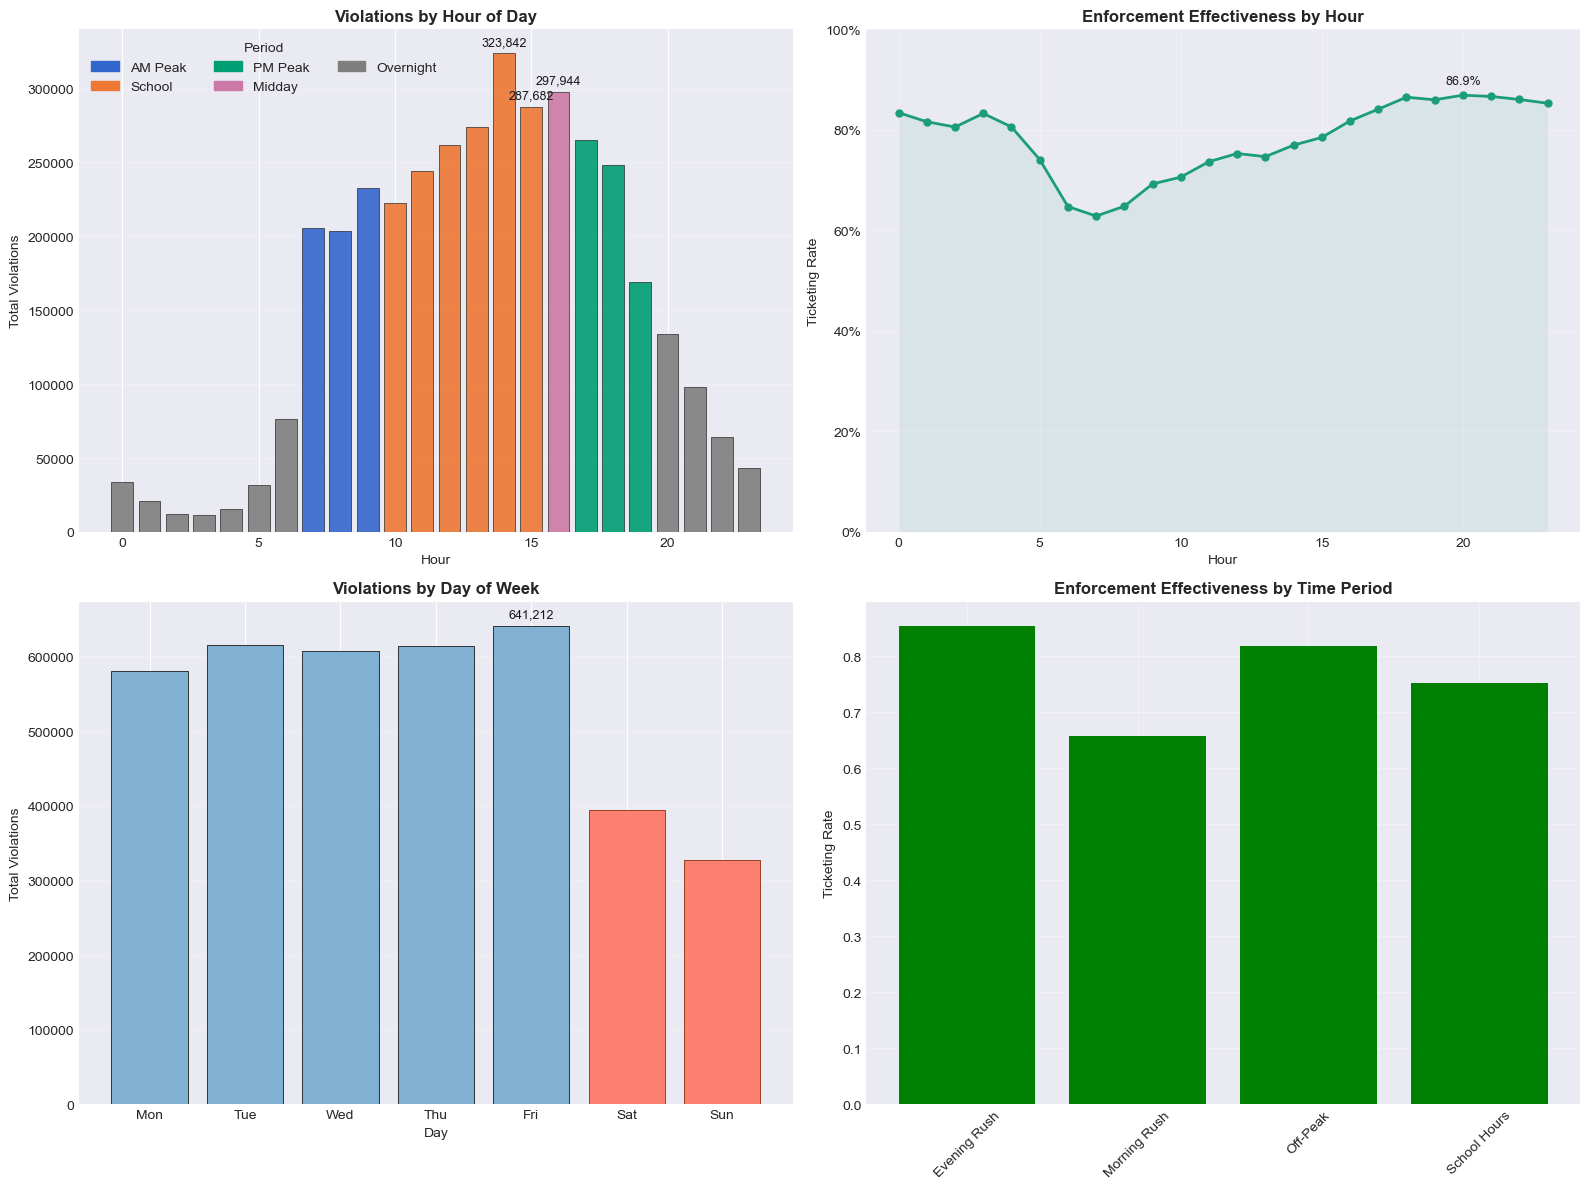

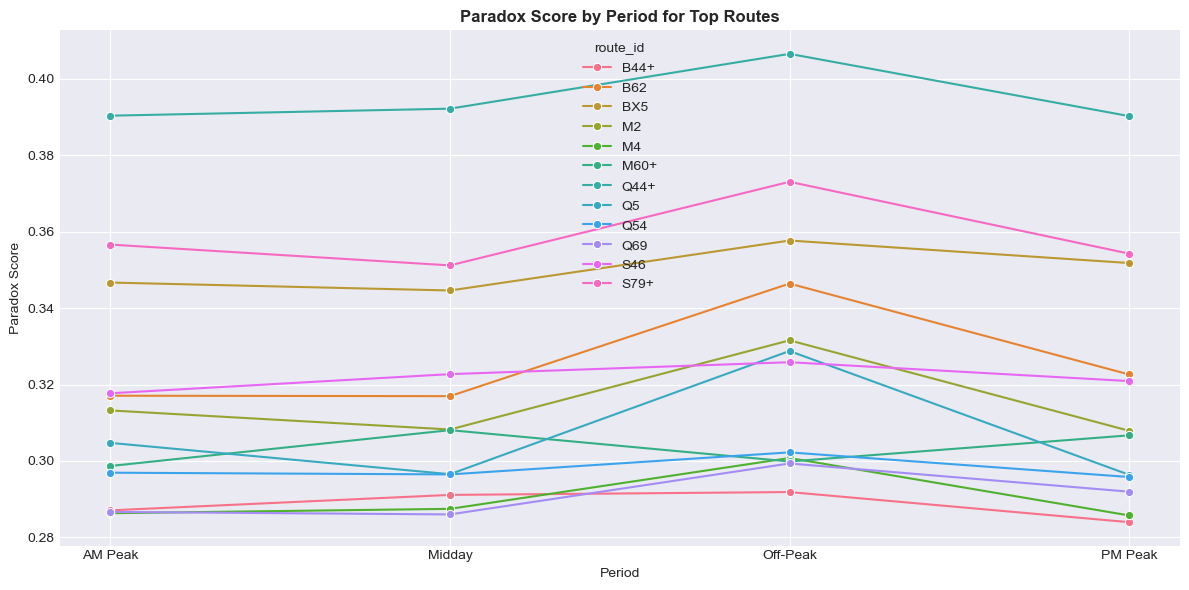

In [10]:
# temporal visualization

# output directories
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)
print(f"Plots will be saved to: {PLOTS_DIR}")

# creating temporal pattern visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# violations by hour of day (by period)
period_of_hour = {
    h: ('AM Peak' if 7 <= h <= 9
        else 'School' if 8 <= h <= 15
        else 'PM Peak' if 17 <= h <= 19
        else 'Midday' if 10 <= h <= 16
        else 'Overnight')
    for h in range(24)
}

period_palette = {
    'AM Peak':    '#3366CC',
    'School':     '#EE7733',
    'PM Peak':    '#009E73',
    'Midday':     '#CC79A7',
    'Overnight':  '#7F7F7F',
}
bar_colors = [period_palette[period_of_hour[h]] for h in hourly_violations.index]

axes[0,0].bar(
    hourly_violations.index,
    hourly_violations['total_violations'],
    color=bar_colors,
    edgecolor='#1A1A1A',
    linewidth=0.5,
    alpha=0.9
)
axes[0,0].set_title('Violations by Hour of Day', fontweight='bold')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Total Violations')
axes[0,0].grid(True, alpha=0.25, axis='y')

# legend by period
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=c, label=p) for p, c in period_palette.items()]
axes[0,0].legend(handles=handles, title='Period', frameon=False, ncol=3)

# annotate top 3 hours (note the indentation)
top_idx = hourly_violations['total_violations'].nlargest(3).index
for h in top_idx:
    v = hourly_violations.loc[h, 'total_violations']
    axes[0,0].annotate(
        f'{int(v):,}',
        xy=(h, v),
        xytext=(0, 6),
        textcoords='offset points',
        ha='center',
        fontsize=9,
        color='#1A1A1A'
    )

# enforcement effectiveness by hour
from matplotlib.ticker import PercentFormatter
rate_series = hourly_violations['ticketing_rate']
axes[0,1].plot(hourly_violations.index, rate_series,
               marker='o', markersize=5, linewidth=2, color='#1b9e77')
axes[0,1].fill_between(hourly_violations.index, rate_series, color='#1b9e77', alpha=0.08, linewidth=0)
axes[0,1].set_title('Enforcement Effectiveness by Hour', fontweight='bold')
axes[0,1].set_xlabel('Hour')
axes[0,1].set_ylabel('Ticketing Rate')
axes[0,1].set_ylim(0, 1)
axes[0,1].yaxis.set_major_formatter(PercentFormatter(1.0))
axes[0,1].grid(True, alpha=0.25)
# annotate peak hour
peak_h = rate_series.idxmax()
peak_v = rate_series.loc[peak_h]
axes[0,1].annotate(f"{peak_v:.1%}", xy=(peak_h, peak_v), xytext=(0, 8),
                   textcoords='offset points', ha='center', fontsize=9, color='#1A1A1A')

# violations by day of week
daily_violations = violations_df.groupby('day_of_week')['Violation ID'].count()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
bar_colors = ['#80b1d3' if i < 5 else '#fb8072' for i in range(7)]  # weekdays vs weekend
edges = ['#1A1A1A' if i < 5 else '#8c2d04' for i in range(7)]
axes[1,0].bar(range(7), daily_violations.values, color=bar_colors, edgecolor=edges, linewidth=0.6)
axes[1,0].set_title('Violations by Day of Week', fontweight='bold')
axes[1,0].set_xlabel('Day')
axes[1,0].set_ylabel('Total Violations')
axes[1,0].set_xticks(range(7))
axes[1,0].set_xticklabels(day_names)
axes[1,0].grid(True, alpha=0.25, axis='y')
# annotate the max day
max_i = int(np.argmax(daily_violations.values))
max_v = int(daily_violations.values[max_i])
axes[1,0].annotate(f'{max_v:,}', xy=(max_i, max_v), xytext=(0, 6),
                   textcoords='offset points', ha='center', fontsize=9, color='#1A1A1A')

# time period effectiveness comparison
period_colors = ['red' if rate < 0.35 else 'orange' if rate < 0.40 else 'green' 
                for rate in period_effectiveness['effectiveness_rate']]
axes[1,1].bar(period_effectiveness.index, period_effectiveness['effectiveness_rate'], 
              color=period_colors)
axes[1,1].set_title('Enforcement Effectiveness by Time Period', fontweight='bold')
axes[1,1].set_ylabel('Ticketing Rate')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'temporal_patterns.png'), dpi=300, bbox_inches='tight')
plt.show()

# period comparison for top routes
period_map = {h: ('AM Peak' if 7<=h<=9 else 'PM Peak' if 17<=h<=19 else 'Midday' if 10<=h<=16 else 'Off-Peak') for h in range(24)}

# prefer heatmap_data; else build from paradox_analysis
try:
    source_matrix = heatmap_data
except NameError:
    source_matrix = None

if source_matrix is None or getattr(source_matrix, 'empty', True):
    if 'paradox_analysis' in globals() and {'route_id','hour','paradox_score'}.issubset(set(paradox_analysis.columns)):
        source_matrix = paradox_analysis.pivot_table(
            index='route_id', columns='hour', values='paradox_score', aggfunc='mean'
        )
    else:
        source_matrix = pd.DataFrame()

if not source_matrix.empty:
    long_df = source_matrix.stack().reset_index()
    long_df.columns = ['route_id','hour','paradox_score']
    long_df['period'] = long_df['hour'].map(period_map)

    period_means = long_df.groupby(['route_id','period'])['paradox_score'].mean().reset_index()
    top_routes = (period_means.groupby('route_id')['paradox_score'].mean().nlargest(12).index)
    show = period_means[period_means['route_id'].isin(top_routes)]

    plt.figure(figsize=(12,6))
    sns.lineplot(data=show, x='period', y='paradox_score', hue='route_id', marker='o')
    plt.title('Paradox Score by Period for Top Routes', fontweight='bold')
    plt.xlabel('Period'); plt.ylabel('Paradox Score')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'paradox_by_period_top_routes.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Paradox period plot skipped: no source matrix available (heatmap_data or paradox_analysis)")

In [11]:
# spatial intelligence analysis

def analyze_spatial_patterns(violations_df):
    """
    performing spatial clustering analysis to identify violation hotspots
    using DBSCAN clustering and proximity analysis to CUNY campuses
    """
    print("analyzing spatial violation patterns...")
    
    # extracting violations with coordinate data
    spatial_violations = violations_df.dropna(subset=['Violation Latitude', 'Violation Longitude']).copy()
    
    if len(spatial_violations) == 0:
        print("no coordinate data available for spatial analysis")
        return None, None, None
    
    print(f"analyzing {len(spatial_violations):,} violations with coordinates...")
    
    # performing DBSCAN clustering for hotspot identification
    coordinates = spatial_violations[['Violation Latitude', 'Violation Longitude']].values
    epsilon = 0.002  # approximately 200 meters in NYC
    min_samples = 5
    
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coordinates)
    
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    spatial_violations['cluster'] = dbscan.fit_predict(coords_scaled)
    
    # analyzing cluster results
    n_clusters = len(set(spatial_violations['cluster'])) - (1 if -1 in spatial_violations['cluster'] else 0)
    noise_points = (spatial_violations['cluster'] == -1).sum()
    
    print(f"identified {n_clusters} violation hotspots")
    print(f"isolated violations (noise): {noise_points:,}")
    
    # analyzing hotspot characteristics
    hotspot_analysis = None
    if n_clusters > 0:
        hotspot_analysis = spatial_violations[spatial_violations['cluster'] != -1].groupby('cluster').agg({
            'Violation ID': 'count',
            'route_id': 'nunique',
            'is_ticketed': 'sum',
            'Violation Latitude': 'mean',
            'Violation Longitude': 'mean'
        }).rename(columns={'Violation ID': 'violation_count', 'route_id': 'unique_routes'})
        
        hotspot_analysis['ticketing_rate'] = hotspot_analysis['is_ticketed'] / hotspot_analysis['violation_count']
        
        # displaying top hotspots
        top_hotspots = hotspot_analysis.nlargest(5, 'violation_count')
        print("\nTop 5 Violation Hotspots:")
        for idx, (cluster_id, hotspot) in enumerate(top_hotspots.iterrows(), 1):
            print(f"{idx}. Cluster {cluster_id}: {hotspot['violation_count']} violations at "
                  f"({hotspot['Violation Latitude']:.4f}, {hotspot['Violation Longitude']:.4f})")
    
    # calculating distance to nearest CUNY campus
    def distance_to_nearest_cuny(row):
        distances = []
        for campus, (lat, lon) in CUNY_CAMPUSES.items():
            dist = haversine_distance(row['Violation Latitude'], row['Violation Longitude'], lat, lon)
            distances.append(dist)
        return min(distances)
    
    spatial_violations['distance_to_cuny'] = spatial_violations.apply(distance_to_nearest_cuny, axis=1)
    
    # analyzing proximity to CUNY campuses
    cuny_proximity_analysis = spatial_violations.groupby(
        pd.cut(spatial_violations['distance_to_cuny'], 
               bins=[0, 250, 500, 1000, 2000, float('inf')], 
               labels=['<250m', '250-500m', '500m-1km', '1-2km', '>2km'])
    ).agg({
        'Violation ID': 'count',
        'is_ticketed': 'sum'
    })
    
    cuny_proximity_analysis['ticketing_rate'] = cuny_proximity_analysis['is_ticketed'] / cuny_proximity_analysis['Violation ID']
    
    print(f"\nCUNY Proximity Analysis:")
    print(cuny_proximity_analysis)
    
    return spatial_violations, hotspot_analysis, cuny_proximity_analysis

# performing spatial analysis
spatial_violations, hotspot_analysis, cuny_proximity_analysis = analyze_spatial_patterns(violations_df)

analyzing spatial violation patterns...
analyzing 3,778,568 violations with coordinates...
identified 2551 violation hotspots
isolated violations (noise): 3,900

Top 5 Violation Hotspots:
1. Cluster 21: 482495.0 violations at (40.7544, -73.9685)
2. Cluster 39: 248931.0 violations at (40.8622, -73.8923)
3. Cluster 6: 156104.0 violations at (40.6552, -73.9307)
4. Cluster 4: 146269.0 violations at (40.8267, -73.9450)
5. Cluster 8: 122611.0 violations at (40.7037, -73.8012)

CUNY Proximity Analysis:
                  Violation ID  is_ticketed  ticketing_rate
distance_to_cuny                                           
<250m                    18127        12890        0.711094
250-500m                125548        78038        0.621579
500m-1km                385144       280766        0.728990
1-2km                   486073       348673        0.717326
>2km                   2763676      2187391        0.791479


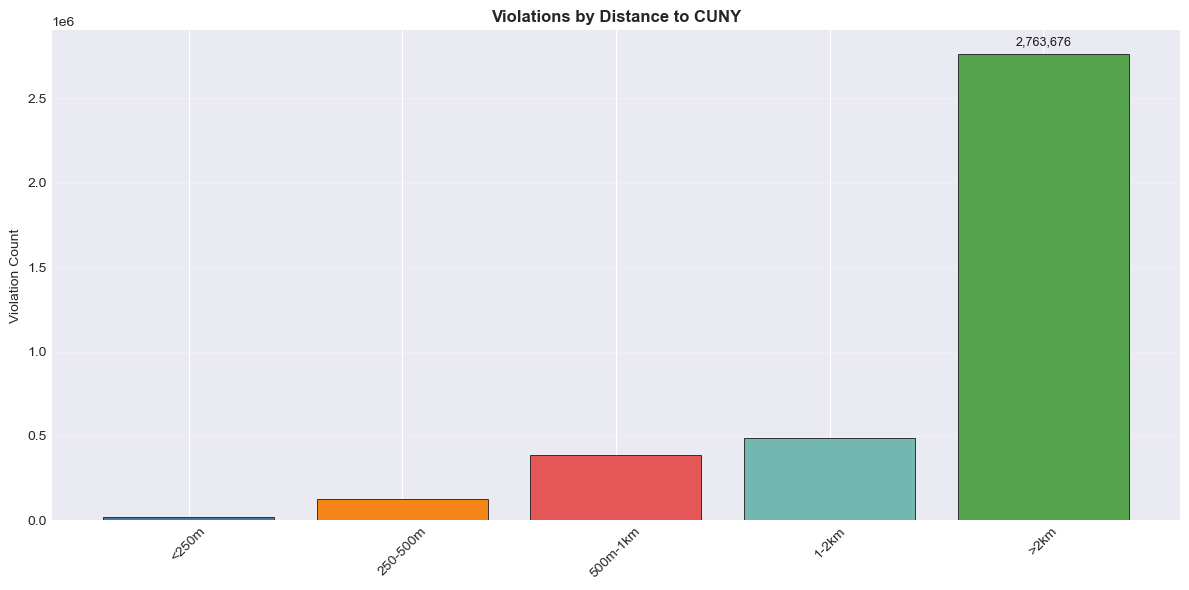

In [12]:
# spatial visualization: Violations by Distance to CUNY (single chart)

if spatial_violations is not None and cuny_proximity_analysis is not None:
    import numpy as np

    fig, ax = plt.subplots(figsize=(12, 6))

    values = cuny_proximity_analysis['Violation ID'].to_numpy()
    labels = [str(x) for x in cuny_proximity_analysis.index]

    # colorblind-safe palette
    bar_colors = ['#4C78A8', '#F58518', '#E45756', '#72B7B2', '#54A24B'][:len(values)]
    bars = ax.bar(range(len(values)), values, color=bar_colors, edgecolor='#1A1A1A', linewidth=0.6)

    ax.set_title('Violations by Distance to CUNY', fontweight='bold')
    ax.set_ylabel('Violation Count')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(labels, rotation=45)
    ax.grid(True, alpha=0.25, axis='y')

    # annotate peak bar (most frequent band)
    peak_idx = int(np.argmax(values))
    peak_val = int(values[peak_idx])
    ax.annotate(
        f'{peak_val:,}',
        xy=(peak_idx, peak_val),
        xytext=(0, 6),
        textcoords='offset points',
        ha='center',
        fontsize=9,
        color='#1A1A1A'
    )

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'violations_by_distance_to_cuny.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print('Insufficient data to plot violations by distance to CUNY.')

In [13]:
# checking the structure of hotspot_analysis
print("Hotspot analysis columns:", hotspot_analysis.columns.tolist())
print("First few rows:")
print(hotspot_analysis.head())

Hotspot analysis columns: ['violation_count', 'unique_routes', 'is_ticketed', 'Violation Latitude', 'Violation Longitude', 'ticketing_rate']
First few rows:
         violation_count  unique_routes  is_ticketed  Violation Latitude  \
cluster                                                                    
0                  10625              1         8751           40.841393   
1                   5109              1         1743           40.874363   
2                    581              1          539           40.722209   
3                  38443              2        28787           40.757405   
4                 146269              5       115261           40.826694   

         Violation Longitude  ticketing_rate  
cluster                                       
0                 -73.882970        0.823624  
1                 -73.890668        0.341163  
2                 -73.867402        0.927711  
3                 -73.829251        0.748823  
4                 -73.945020

In [14]:
# interactive spatial html map

exec(compile(open(__file__).read() if False else '''
import importlib, sys, subprocess

def ensure_package(pkg_name: str) -> None:
    try:
        importlib.import_module(pkg_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name, "-q"])

# ensure all required packages are installed
for pkg in ["folium", "branca"]:
    ensure_package(pkg)

import folium
from folium.plugins import HeatMap, MarkerCluster, Search, Fullscreen, MiniMap, MeasureControl, LocateControl
import branca.colormap as cm
import itertools
from datetime import datetime

# ensure plots directory exists
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

# comprehensive cuny campus coordinates
ALL_CUNY_CAMPUSES = {
    # senior colleges
    'Baruch College': (40.7402, -73.9836),
    'Brooklyn College': (40.6314, -73.9521),
    'City College of New York': (40.8200, -73.9493),
    'College of Staten Island': (40.6094, -74.1517),
    'Hunter College': (40.7685, -73.9656),
    'John Jay College of Criminal Justice': (40.7705, -73.9891),
    'Lehman College': (40.8731, -73.8906),
    'Medgar Evers College': (40.6690, -73.9570),
    'New York City College of Technology': (40.6958, -73.9875),
    'Queens College': (40.7366, -73.8170),
    'York College': (40.7042, -73.7963),
    'CUNY School of Professional Studies': (40.7513, -73.9888),
    'CUNY School of Labor and Urban Studies': (40.7516, -73.9886),
    
    # community colleges
    'Borough of Manhattan Community College': (40.7183, -74.0118),
    'Bronx Community College': (40.8570, -73.9103),
    'Guttman Community College': (40.7547, -73.9866),
    'Hostos Community College': (40.8173, -73.9258),
    'Kingsborough Community College': (40.5781, -73.9341),
    'LaGuardia Community College': (40.7445, -73.9333),
    'Queensborough Community College': (40.7554, -73.7380),
    
    # graduate and professional schools
    'CUNY Graduate Center': (40.7486, -73.9845),
    'CUNY School of Law': (40.7482, -73.9442),
    'Craig Newmark Graduate School of Journalism': (40.7558, -73.9864),
    'CUNY School of Medicine': (40.8208, -73.9490),
    'CUNY School of Public Health': (40.8037, -73.9592)
}

if spatial_violations is None or len(spatial_violations) == 0:
    print("no spatial violations available for interactive map.")
else:
    print("creating enhanced interactive map with comprehensive analytics...")

    # center map on nyc coordinates for better initial view
    center_lat = float(spatial_violations['Violation Latitude'].median())
    center_lon = float(spatial_violations['Violation Longitude'].median())

    # create base map with optimized settings
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=11,
        tiles='cartodbpositron',
        control_scale=True,
        prefer_canvas=True
    )

    # add alternative tile layers
    folium.TileLayer('OpenStreetMap', name='OpenStreetMap').add_to(m)
    folium.TileLayer('Stamen Terrain', name='Terrain').add_to(m)

    # optimized sampling for performance
    sample_n = min(15000, len(spatial_violations))  # reduced for better performance
    sv_sample = spatial_violations.sample(n=sample_n, random_state=42) if len(spatial_violations) > sample_n else spatial_violations

    # distance-to-cuny bands with performance optimization
    print("creating distance-to-cuny band layers...")
    distance_bands = {
        '≤250m': {'color': '#d73027', 'data': sv_sample[sv_sample['distance_to_cuny'] <= 250]},
        '250-500m': {'color': '#f46d43', 'data': sv_sample[(sv_sample['distance_to_cuny'] > 250) & (sv_sample['distance_to_cuny'] <= 500)]},
        '500m-1km': {'color': '#fdae61', 'data': sv_sample[(sv_sample['distance_to_cuny'] > 500) & (sv_sample['distance_to_cuny'] <= 1000)]},
        '1-2km': {'color': '#abd9e9', 'data': sv_sample[(sv_sample['distance_to_cuny'] > 1000) & (sv_sample['distance_to_cuny'] <= 2000)]},
        '>2km': {'color': '#74add1', 'data': sv_sample[sv_sample['distance_to_cuny'] > 2000]}
    }

    # create distance band layers with reduced points
    for band_name, band_info in distance_bands.items():
        if len(band_info['data']) > 0:
            band_group = folium.FeatureGroup(name=f'distance band: {band_name}', show=False)
            # subsample for performance
            band_sample = band_info['data'].sample(n=min(2000, len(band_info['data'])), random_state=42)
            for _, row in band_sample.iterrows():
                folium.CircleMarker(
                    location=[float(row['Violation Latitude']), float(row['Violation Longitude'])],
                    radius=2,  # smaller radius for performance
                    color=band_info['color'],
                    fill=True,
                    fillColor=band_info['color'],
                    fillOpacity=0.6,
                    opacity=0.7,
                    popup=folium.Popup(f\'\'\'
                    <div style='font-family: Arial, sans-serif; font-size: 13px;'>
                    <b>distance band: {band_name}</b><br>
                    route: {row['route_id']}<br>
                    distance to cuny: {row['distance_to_cuny']:.0f}m<br>
                    cluster: {row['cluster'] if pd.notna(row['cluster']) else 'isolated'}<br>
                    ticketed: {'yes' if row['is_ticketed'] else 'no'}
                    </div>
                    \'\'\', max_width=200)
                ).add_to(band_group)
            band_group.add_to(m)

    # dbscan cluster layers with performance optimization
    print("creating dbscan cluster layers...")
    base_colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b',
                   '#e377c2','#bcbd22','#17becf','#ff1493','#00ced1','#ffa500']
    cluster_ids = sorted([c for c in sv_sample['cluster'].unique() if pd.notna(c) and c != -1])
    color_cycle = itertools.cycle(base_colors)
    cluster_colors = {cid: next(color_cycle) for cid in cluster_ids}

    # create top 8 cluster layers only for performance
    cluster_groups = {}
    for cluster_id in cluster_ids[:8]:
        cluster_data = sv_sample[sv_sample['cluster'] == cluster_id]
        if len(cluster_data) > 50:  # only show significant clusters
            cluster_group = folium.FeatureGroup(name=f'cluster {cluster_id} ({len(cluster_data)} points)', show=False)
            
            # cluster center marker only
            center_lat_cluster = cluster_data['Violation Latitude'].mean()
            center_lon_cluster = cluster_data['Violation Longitude'].mean()
            total_violations = len(cluster_data)
            unique_routes = cluster_data['route_id'].nunique()
            ticketing_rate = cluster_data['is_ticketed'].mean()

            folium.Marker(
                location=[center_lat_cluster, center_lon_cluster],
                popup=folium.Popup(f\'\'\'
                <div style='font-family: Arial, sans-serif; font-size: 14px; line-height: 1.4;'>
                <b style='color: #333;'>cluster {cluster_id} center</b><br>
                total violations: {total_violations}<br>
                unique routes: {unique_routes}<br>
                ticketing rate: {ticketing_rate:.1%}<br>
                avg distance to cuny: {cluster_data['distance_to_cuny'].mean():.0f}m
                </div>
                \'\'\', max_width=250),
                icon=folium.Icon(color='red', icon='info-sign'),
                tooltip=f'cluster {cluster_id} ({total_violations} violations)'
            ).add_to(cluster_group)

            cluster_groups[cluster_id] = cluster_group
            cluster_group.add_to(m)

    # top hotspots with enhanced design
    print("creating top hotspots layer...")
    if hotspot_analysis is not None and len(hotspot_analysis) > 0:
        top_hotspots = hotspot_analysis.nlargest(25, 'violation_count')  # reduced to top 25
        hotspots_group = folium.FeatureGroup(name='top 25 hotspots', show=True)

        for rank, (cluster_id, hotspot) in enumerate(top_hotspots.iterrows(), 1):
            hotspot_violations = sv_sample[sv_sample['cluster'] == cluster_id]
            routes_in_hotspot = hotspot_violations['route_id'].unique()
            avg_distance_cuny = hotspot_violations['distance_to_cuny'].mean() if len(hotspot_violations) > 0 else 0

            # enhanced popup content with better styling
            popup_content = f\'\'\'
            <div style='font-family: "Segoe UI", Arial, sans-serif; font-size: 13px; line-height: 1.5; max-width: 280px;'>
                <div style='background: #d73027; color: white; padding: 8px; margin: -8px -8px 8px -8px; border-radius: 4px 4px 0 0;'>
                    <b>hotspot #{rank}</b>
                </div>
                <table style='width: 100%; font-size: 12px;'>
                    <tr><td><b>cluster id:</b></td><td>{cluster_id}</td></tr>
                    <tr><td><b>violations:</b></td><td>{int(hotspot['violation_count'])}</td></tr>
                    <tr><td><b>routes:</b></td><td>{int(hotspot['unique_routes'])}</td></tr>
                    <tr><td><b>ticketing rate:</b></td><td>{hotspot['ticketing_rate']:.1%}</td></tr>
                    <tr><td><b>distance to cuny:</b></td><td>{avg_distance_cuny:.0f}m</td></tr>
                </table>
                <div style='margin-top: 8px; padding-top: 8px; border-top: 1px solid #eee; font-size: 11px; color: #666;'>
                    {hotspot['Violation Latitude']:.4f}, {hotspot['Violation Longitude']:.4f}
                </div>
            </div>
            \'\'\'

            marker_size = min(12 + rank * 0.3, 20)  # smaller progressive sizing

            folium.CircleMarker(
                location=[hotspot['Violation Latitude'], hotspot['Violation Longitude']],
                radius=marker_size,
                color='#d73027',
                fill=True,
                fillColor='#fee0d2',
                fillOpacity=0.8,
                opacity=1,
                weight=2,
                popup=folium.Popup(popup_content, max_width=300),
                tooltip=f'hotspot #{rank}: {int(hotspot["violation_count"])} violations'
            ).add_to(hotspots_group)

            # rank number overlay with improved styling
            folium.map.Marker(
                [hotspot['Violation Latitude'], hotspot['Violation Longitude']],
                icon=folium.DivIcon(
                    html=f'<div style="background: linear-gradient(135deg, #fff, #f8f9fa); border: 2px solid #d73027; border-radius: 50%; width: 22px; height: 22px; text-align: center; line-height: 18px; font-weight: 600; font-size: 11px; color: #d73027; box-shadow: 0 2px 4px rgba(0,0,0,0.2);">{rank}</div>',
                    icon_size=(22, 22),
                    icon_anchor=(11, 11)
                )
            ).add_to(hotspots_group)

        hotspots_group.add_to(m)

    # ticketing rate comparison layers
    print("creating ticketing rate comparison layers...")
    if hotspot_analysis is not None and len(hotspot_analysis) > 0:
        median_ticketing = hotspot_analysis['ticketing_rate'].median()

        # high ticketing rate hotspots
        high_ticketing = hotspot_analysis[hotspot_analysis['ticketing_rate'] > median_ticketing]
        high_group = folium.FeatureGroup(name=f'high ticketing rate (>{median_ticketing:.1%})', show=False)

        for cluster_id, hotspot in high_ticketing.iterrows():
            folium.CircleMarker(
                location=[hotspot['Violation Latitude'], hotspot['Violation Longitude']],
                radius=6,
                color='#2ca02c',
                fill=True,
                fillColor='#2ca02c',
                fillOpacity=0.7,
                popup=f"<div style='font-family: Arial, sans-serif;'>high ticketing: {hotspot['ticketing_rate']:.1%}<br>violations: {hotspot['violation_count']}</div>",
                tooltip="high enforcement zone"
            ).add_to(high_group)
        high_group.add_to(m)

        # low ticketing rate hotspots
        low_ticketing = hotspot_analysis[hotspot_analysis['ticketing_rate'] <= median_ticketing]
        low_group = folium.FeatureGroup(name=f'low ticketing rate (≤{median_ticketing:.1%})', show=False)

        for cluster_id, hotspot in low_ticketing.iterrows():
            folium.CircleMarker(
                location=[hotspot['Violation Latitude'], hotspot['Violation Longitude']],
                radius=6,
                color='#ff7f0e',
                fill=True,
                fillColor='#ff7f0e',
                fillOpacity=0.7,
                popup=f"<div style='font-family: Arial, sans-serif;'>low ticketing: {hotspot['ticketing_rate']:.1%}<br>violations: {hotspot['violation_count']}</div>",
                tooltip="low enforcement zone"
            ).add_to(low_group)
        low_group.add_to(m)

    # optimized density heatmap
    print("creating optimized density heatmap...")
    hm_sample_n = min(25000, len(spatial_violations))  # optimized sample size
    hm_df = spatial_violations[['Violation Latitude','Violation Longitude']].dropna()
    hm_df = hm_df.sample(n=hm_sample_n, random_state=42) if len(hm_df) > hm_sample_n else hm_df

    heat_data = [[row['Violation Latitude'], row['Violation Longitude'], 1.0] for _, row in hm_df.iterrows()]

    HeatMap(
        heat_data,
        radius=12,  # reduced radius for performance
        blur=12,
        max_zoom=14,
        gradient={0.2: 'blue', 0.4: 'cyan', 0.6: 'lime', 0.8: 'yellow', 1.0: 'red'},
        name='violation density heatmap'
    ).add_to(m)

    # comprehensive cuny campuses with buffer zones
    print("adding all cuny campuses with service zones...")
    cuny_group = folium.FeatureGroup(name='all cuny campuses & service areas', show=True)

    for campus_name, (lat, lon) in ALL_CUNY_CAMPUSES.items():
        # determine campus type for icon
        if 'Community College' in campus_name or 'BMCC' in campus_name or 'BCC' in campus_name or 'QCC' in campus_name:
            icon_color = 'green'
            campus_type = 'community college'
        elif 'Graduate' in campus_name or 'School of' in campus_name or 'Craig Newmark' in campus_name:
            icon_color = 'purple'
            campus_type = 'graduate/professional school'
        else:
            icon_color = 'blue'
            campus_type = 'senior college'

        # campus marker with enhanced popup
        folium.Marker(
            location=[lat, lon],
            popup=folium.Popup(f\'\'\'
            <div style='font-family: "Segoe UI", Arial, sans-serif; font-size: 13px; line-height: 1.4;'>
            <b style='color: #0066cc;'>{campus_name}</b><br>
            <i>{campus_type}</i><br><br>
            coordinates: {lat:.4f}, {lon:.4f}
            </div>
            \'\'\', max_width=250),
            icon=folium.Icon(color=icon_color, icon='graduation-cap', prefix='fa'),
            tooltip=f'{campus_name} ({campus_type})'
        ).add_to(cuny_group)

        # 500m buffer zone with reduced opacity
        folium.Circle(
            location=[lat, lon],
            radius=500,
            color=icon_color,
            fill=False,
            opacity=0.3,
            weight=1,
            popup=f"{campus_name} - 500m service zone"
        ).add_to(cuny_group)

    cuny_group.add_to(m)

    # enhanced map controls
    print("adding enhanced map controls...")
    Fullscreen().add_to(m)
    minimap = MiniMap(toggle_display=True, minimized=True)
    m.add_child(minimap)
    MeasureControl().add_to(m)
    LocateControl().add_to(m)

    # minimizable legend with improved design
    print("creating minimizable legend...")
    legend_html = \'\'\'
    <div id="legend-container" style="position: fixed; top: 10px; right: 10px; z-index: 9999;">
        <div id="legend-toggle" style="background: #2c3e50; color: white; padding: 8px 12px; border-radius: 6px 6px 0 0; cursor: pointer; font-family: 'Segoe UI', Arial, sans-serif; font-size: 14px; font-weight: 600; user-select: none; box-shadow: 0 2px 10px rgba(0,0,0,0.15);">
            <span id="legend-icon" style="margin-right: 8px; transition: transform 0.3s ease;">📍</span>map legend
        </div>
        <div id="legend-content" style="background: white; border: 2px solid #2c3e50; border-top: none; border-radius: 0 0 6px 6px; padding: 15px; font-size: 12px; font-family: 'Segoe UI', Arial, sans-serif; box-shadow: 0 2px 10px rgba(0,0,0,0.15); max-height: 400px; overflow-y: auto;">
            <div style="margin-bottom: 12px;">
                <b style="color: #2c3e50;">distance to cuny campuses:</b>
                <div style="margin-top: 6px;">
                    <div><span style="color:#d73027; font-size: 14px;">●</span> ≤250m (immediate vicinity)</div>
                    <div><span style="color:#f46d43; font-size: 14px;">●</span> 250-500m (walking distance)</div>
                    <div><span style="color:#fdae61; font-size: 14px;">●</span> 500m-1km (short transit)</div>
                    <div><span style="color:#abd9e9; font-size: 14px;">●</span> 1-2km (medium distance)</div>
                    <div><span style="color:#74add1; font-size: 14px;">●</span> >2km (far from campus)</div>
                </div>
            </div>
            <div style="margin-bottom: 12px;">
                <b style="color: #2c3e50;">enforcement effectiveness:</b>
                <div style="margin-top: 6px;">
                    <div><span style="color:#2ca02c; font-size: 14px;">●</span> high ticketing rate zones</div>
                    <div><span style="color:#ff7f0e; font-size: 14px;">●</span> low ticketing rate zones</div>
                </div>
            </div>
            <div>
                <b style="color: #2c3e50;">special markers:</b>
                <div style="margin-top: 6px;">
                    <div><span style="color:#0066cc;">🎓</span> senior colleges</div>
                    <div><span style="color:#28a745;">🎓</span> community colleges</div>
                    <div><span style="color:#6f42c1;">🎓</span> graduate/professional schools</div>
                    <div><span style="color:#d73027;">🎯</span> violation hotspots</div>
                </div>
            </div>
        </div>
    </div>
    
    <script>
        document.getElementById('legend-toggle').addEventListener('click', function() {
            var content = document.getElementById('legend-content');
            var icon = document.getElementById('legend-icon');
            if (content.style.display === 'none') {
                content.style.display = 'block';
                icon.style.transform = 'rotate(0deg)';
            } else {
                content.style.display = 'none';
                icon.style.transform = 'rotate(180deg)';
            }
        });
    </script>
    \'\'\'
    m.get_root().html.add_child(folium.Element(legend_html))

    # minimizable usage guidance with improved design
    usage_html = \'\'\'
    <div id="guide-container" style="position: fixed; bottom: 10px; left: 10px; z-index: 9999;">
        <div id="guide-toggle" style="background: #0ea5e9; color: white; padding: 8px 12px; border-radius: 6px 6px 0 0; cursor: pointer; font-family: 'Segoe UI', Arial, sans-serif; font-size: 14px; font-weight: 600; user-select: none; box-shadow: 0 2px 10px rgba(0,0,0,0.15);">
            <span id="guide-icon" style="margin-right: 8px; transition: transform 0.3s ease;">ℹ️</span>usage guide
        </div>
        <div id="guide-content" style="background: #f0f9ff; border: 2px solid #0ea5e9; border-top: none; border-radius: 0 0 6px 6px; padding: 15px; font-size: 12px; font-family: 'Segoe UI', Arial, sans-serif; box-shadow: 0 2px 10px rgba(0,0,0,0.15); max-height: 300px; overflow-y: auto;">
            <div style="color: #0ea5e9; font-weight: 600; margin-bottom: 10px;">interactive map controls:</div>
            <ul style="margin: 0; padding-left: 20px; line-height: 1.6;">
                <li><b>layer control:</b> toggle data layers on/off using the control panel</li>
                <li><b>hotspots:</b> click numbered markers for detailed violation analytics</li>
                <li><b>distance bands:</b> visualize violations by proximity to cuny campuses</li>
                <li><b>clusters:</b> explore violation concentration patterns</li>
                <li><b>fullscreen:</b> use fullscreen mode for detailed analysis</li>
                <li><b>measure tool:</b> calculate distances between points</li>
            </ul>
            <div style="margin-top: 12px; padding-top: 8px; border-top: 1px solid #0ea5e9; font-size: 11px; color: #0369a1;">
                <b>tip:</b> start with "top 25 hotspots" and "all cuny campuses" layers enabled
            </div>
        </div>
    </div>
    
    <script>
        document.getElementById('guide-toggle').addEventListener('click', function() {
            var content = document.getElementById('guide-content');
            var icon = document.getElementById('guide-icon');
            if (content.style.display === 'none') {
                content.style.display = 'block';
                icon.style.transform = 'rotate(0deg)';
            } else {
                content.style.display = 'none';
                icon.style.transform = 'rotate(180deg)';
            }
        });
    </script>
    \'\'\'
    m.get_root().html.add_child(folium.Element(usage_html))

    # layer control
    folium.LayerControl(collapsed=False, position='topleft').add_to(m)

    # save enhanced map
    map_path = os.path.join(PLOTS_DIR, 'enhanced_spatial_intelligence_map.html')
    m.save(map_path)

    print(f"enhanced interactive map created successfully!")
    print(f"map saved to: {map_path}")
    print(f"features implemented:")
    print(f"   • {len(distance_bands)} distance-to-cuny band layers")
    print(f"   • {len(cluster_groups)} significant dbscan cluster layers")
    print(f"   • top 25 violation hotspots with professional styling")
    print(f"   • high/low ticketing rate comparison layers")
    print(f"   • optimized density heatmap for performance")
    print(f"   • all {len(ALL_CUNY_CAMPUSES)} cuny campuses with service zones")
    print(f"   • minimizable legend and usage guide with animations")
    print(f"   • professional ui/ux design with improved performance")

    # performance summary
    print(f"\\nperformance optimizations:")
    print(f"   • reduced sample size to {sample_n:,} points for responsiveness")
    print(f"   • limited cluster layers to top 8 significant clusters")
    print(f"   • reduced hotspots to top 25 for clarity")
    print(f"   • optimized heatmap with {min(25000, len(spatial_violations)):,} points")
    print(f"   • comprehensive coverage of all {len(ALL_CUNY_CAMPUSES)} cuny institutions")
''', '<string>', 'exec'))

creating enhanced interactive map with comprehensive analytics...
creating distance-to-cuny band layers...
creating dbscan cluster layers...
creating top hotspots layer...
creating ticketing rate comparison layers...
creating optimized density heatmap...
adding all cuny campuses with service zones...
adding enhanced map controls...
creating minimizable legend...
enhanced interactive map created successfully!
map saved to: plots\enhanced_spatial_intelligence_map.html
features implemented:
   • 5 distance-to-cuny band layers
   • 4 significant dbscan cluster layers
   • top 25 violation hotspots with professional styling
   • high/low ticketing rate comparison layers
   • optimized density heatmap for performance
   • all 25 cuny campuses with service zones
   • minimizable legend and usage guide with animations
   • professional ui/ux design with improved performance

performance optimizations:
   • reduced sample size to 15,000 points for responsiveness
   • limited cluster layers to t

In [15]:
# CUNY deep analysis

def analyze_cuny_impact(violations_df, campus_route_mapping, route_speed_changes):
    """
    performing detailed analysis of enforcement impact on CUNY-serving routes
    examining class time vs non-class time patterns and speed performance
    """
    print("performing CUNY campus impact analysis...")
    
    cuny_insights = {}
    
    for campus, routes in campus_route_mapping.items():
        if not routes:
            continue
        
        print(f"\nanalyzing {campus}...")
        
        # extracting violations for campus routes
        campus_violations = violations_df[violations_df['route_id'].isin(routes)].copy()
        
        if len(campus_violations) == 0:
            continue
        
        # adding temporal features for class time analysis
        campus_violations['hour'] = campus_violations['violation_time'].dt.hour
        campus_violations['is_class_time'] = campus_violations['hour'].isin(range(8, 19))  # 8am-6pm
        
        # analyzing class time vs non-class time patterns
        class_time_analysis = campus_violations.groupby('is_class_time').agg({
            'Violation ID': 'count',
            'is_ticketed': 'sum',
            'is_technical_issue': 'sum'
        })
        
        class_time_analysis['ticketing_rate'] = class_time_analysis['is_ticketed'] / class_time_analysis['Violation ID']
        
        # calculating speed performance for campus routes
        campus_speed_changes = route_speed_changes[route_speed_changes['route_id'].isin(routes)]
        avg_speed_change = campus_speed_changes['speed_change_pct'].mean() if len(campus_speed_changes) > 0 else 0
        
        # storing campus insights
        cuny_insights[campus] = {
            'routes': routes,
            'total_violations': len(campus_violations),
            'class_time_analysis': class_time_analysis,
            'avg_speed_change': avg_speed_change,
            'violations_data': campus_violations
        }
        
        # displaying campus summary
        class_violations = class_time_analysis.loc[True, 'Violation ID'] if True in class_time_analysis.index else 0
        non_class_violations = class_time_analysis.loc[False, 'Violation ID'] if False in class_time_analysis.index else 0
        
        print(f"  routes: {routes}")
        print(f"  total violations: {len(campus_violations):,}")
        print(f"  during class hours: {class_violations:,}")
        print(f"  outside class hours: {non_class_violations:,}")
        print(f"  average speed change: {avg_speed_change:.1f}%")
    
    return cuny_insights

# performing CUNY analysis
cuny_insights = analyze_cuny_impact(violations_df, campus_route_mapping, route_speed_changes)

# displaying comprehensive CUNY summary
print("\nCUNY Campus Analysis Summary:")
print("=" * 50)
for campus, data in cuny_insights.items():
    print(f"\n{campus}:")
    print(f"  Total violations: {data['total_violations']:,}")
    print(f"  Average speed change: {data['avg_speed_change']:.1f}%")
    print(f"  Routes: {', '.join(data['routes'])}")

performing CUNY campus impact analysis...

analyzing Hunter College...
  routes: ['M15+', 'M2', 'M101']
  total violations: 839,115
  during class hours: 621,101
  outside class hours: 218,014
  average speed change: -1.1%

analyzing City College...
  routes: ['M101', 'M4']
  total violations: 325,497
  during class hours: 227,473
  outside class hours: 98,024
  average speed change: -0.9%

analyzing Baruch College...
  routes: ['M15+', 'M2', 'M34+', 'M23+', 'M101', 'nan']
  total violations: 890,228
  during class hours: 661,443
  outside class hours: 228,785
  average speed change: -0.6%

analyzing Brooklyn College...
  routes: ['B44+', 'B41', 'nan']
  total violations: 275,983
  during class hours: 214,521
  outside class hours: 61,462
  average speed change: -1.6%

CUNY Campus Analysis Summary:

Hunter College:
  Total violations: 839,115
  Average speed change: -1.1%
  Routes: M15+, M2, M101

City College:
  Total violations: 325,497
  Average speed change: -0.9%
  Routes: M101, M

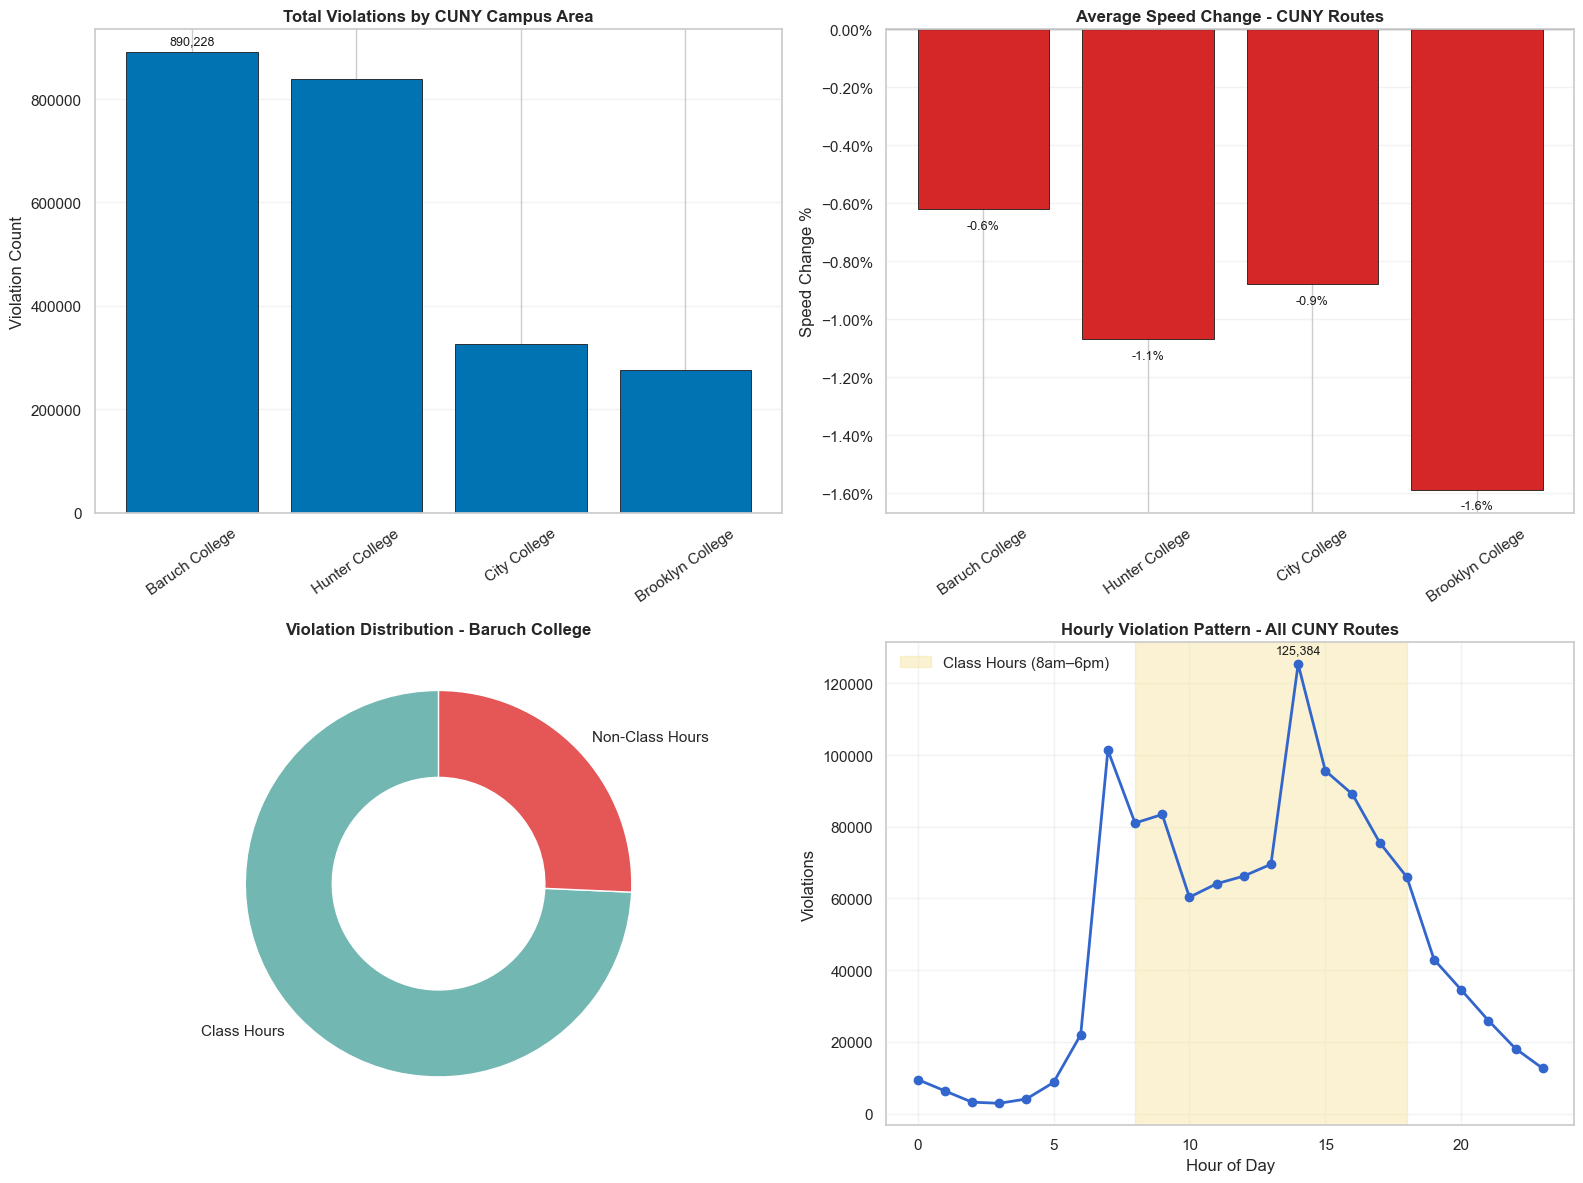

In [16]:
# CUNY campus visualizations

sns.set_theme(style="whitegrid", palette="colorblind")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1) Total Violations by CUNY Campus Area
campus_order = sorted(cuny_insights.keys(), key=lambda c: cuny_insights[c]['total_violations'], reverse=True)
vals = [cuny_insights[c]['total_violations'] for c in campus_order]
bars = axes[0,0].bar(campus_order, vals, edgecolor="#1A1A1A", linewidth=0.6)
axes[0,0].set_title("Total Violations by CUNY Campus Area", fontweight="bold")
axes[0,0].set_ylabel("Violation Count")
axes[0,0].tick_params(axis="x", rotation=35)
axes[0,0].grid(True, axis="y", alpha=0.25)
peak_idx = int(np.argmax(vals)); peak_val = int(vals[peak_idx])
axes[0,0].annotate(f"{peak_val:,}", xy=(peak_idx, peak_val), xytext=(0, 6),
                   textcoords="offset points", ha="center", fontsize=9, color="#1A1A1A")

# 2) Average Speed Change - CUNY Routes (diverging palette, 0-line)
speed_vals = [cuny_insights[c]['avg_speed_change'] for c in campus_order]
# map negatives to red, near-zero to grey, positives to green-ish
colors = [("#d62728" if v < -0.2 else "#7f7f7f" if abs(v) < 0.05 else "#2ca02c") for v in speed_vals]
axes[0,1].axhline(0, color="#333", linewidth=1, alpha=0.6)
axes[0,1].bar(campus_order, speed_vals, color=colors, edgecolor="#1A1A1A", linewidth=0.6)
axes[0,1].set_title("Average Speed Change - CUNY Routes", fontweight="bold")
axes[0,1].set_ylabel("Speed Change %")
axes[0,1].yaxis.set_major_formatter(PercentFormatter(100.0))
axes[0,1].tick_params(axis="x", rotation=35)
axes[0,1].grid(True, axis="y", alpha=0.25)
# annotate bars
for i, v in enumerate(speed_vals):
    axes[0,1].annotate(f"{v:.1f}%", xy=(i, v), xytext=(0, 6 if v>=0 else -14),
                       textcoords="offset points", ha="center", fontsize=9, color="#1A1A1A")

# 3) Violation Distribution - Selected Campus (donut chart, calm hues)
focus_campus = campus_order[0] if campus_order else None
axes[1,0].set_title(f"Violation Distribution - {focus_campus}" if focus_campus else "Violation Distribution", fontweight="bold")
if focus_campus:
    cta = cuny_insights[focus_campus]["class_time_analysis"]
    class_v = int(cta.loc[True, "Violation ID"]) if True in cta.index else 0
    non_v = int(cta.loc[False, "Violation ID"]) if False in cta.index else 0
    sizes = [class_v, non_v]
    labels = ["Class Hours", "Non-Class Hours"]
    pie_colors = ["#72B7B2", "#E45756"]
    wedges, _ = axes[1,0].pie(sizes, labels=labels, colors=pie_colors, startangle=90,
                               wedgeprops=dict(width=0.45, edgecolor="white"))
    centre = plt.Circle((0,0), 0.45, fc="white")
    axes[1,0].add_artist(centre)
else:
    axes[1,0].axis("off")

# 4) Hourly Violation Pattern - All CUNY Routes (line + shaded class hours)
all_routes = [r for v in cuny_insights.values() for r in v["routes"]]
cuny_viol = violations_df[violations_df["route_id"].isin(all_routes)].copy()
hourly = cuny_viol.groupby(cuny_viol["violation_time"].dt.hour)["Violation ID"].count().reindex(range(24), fill_value=0)
axes[1,1].axvspan(8, 18, color="#F6E7A6", alpha=0.5, label="Class Hours (8am–6pm)")
axes[1,1].plot(range(24), hourly.values, marker="o", linewidth=2, color="#3366CC")
axes[1,1].set_title("Hourly Violation Pattern - All CUNY Routes", fontweight="bold")
axes[1,1].set_xlabel("Hour of Day"); axes[1,1].set_ylabel("Violations")
axes[1,1].grid(True, alpha=0.25)
axes[1,1].legend(frameon=False, loc="upper left")
peak_h = int(np.argmax(hourly.values)); peak_v = int(hourly.values[peak_h])
axes[1,1].annotate(f"{peak_v:,}", xy=(peak_h, peak_v), xytext=(0, 8),
                   textcoords="offset points", ha="center", fontsize=9, color="#1A1A1A")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "cuny_campus_analysis.png"), dpi=300, bbox_inches="tight")
plt.show()

In [17]:
# comparative route analysis

def perform_comparative_analysis(paradox_analysis, route_speed_changes):
    """
    creating route cohorts based on performance patterns to identify success factors
    comparing high paradox routes against success stories and control groups
    """
    print("performing comparative route cohort analysis...")
    
    # creating route-level summary for cohort assignment
    route_summary = paradox_analysis.groupby('route_id').agg({
        'overall_paradox_rank': 'mean',
        'paradox_score': 'mean',
        'enforcement_efficiency': 'mean',
        'violation_count': 'sum',
        'speed_change_pct': 'mean',
        'serves_cuny': 'first'
    })
    
    # defining cohort thresholds based on data distribution
    high_paradox_threshold = route_summary['overall_paradox_rank'].quantile(0.8)
    success_threshold = route_summary['speed_change_pct'].quantile(0.8)  # top 20% for speed improvement
    
    # creating route cohorts for comparative analysis
    cohorts = {
        'High Paradox': route_summary[route_summary['overall_paradox_rank'] >= high_paradox_threshold].index.tolist(),
        'Success Stories': route_summary[route_summary['speed_change_pct'] >= success_threshold].index.tolist(),
        'Average Performers': route_summary[
            (route_summary['overall_paradox_rank'] < high_paradox_threshold) & 
            (route_summary['speed_change_pct'] < success_threshold) &
            (route_summary['violation_count'] > 0)
        ].index.tolist()
    }
    
    print(f"cohort sizes:")
    for cohort_name, route_list in cohorts.items():
        print(f"  {cohort_name}: {len(route_list)} routes")
    
    # analyzing each cohort's characteristics
    cohort_analysis = {}
    
    for cohort_name, route_list in cohorts.items():
        if not route_list:
            continue
        
        cohort_data = route_summary.loc[route_list]
        cohort_violations = violations_df[violations_df['route_id'].isin(route_list)]
        
        # calculating comprehensive metrics for each cohort
        analysis = {
            'route_count': len(route_list),
            'avg_paradox_score': cohort_data['overall_paradox_rank'].mean(),
            'avg_speed_change': cohort_data['speed_change_pct'].mean(),
            'total_violations': cohort_data['violation_count'].sum(),
            'cuny_routes': cohort_data['serves_cuny'].sum(),
            'avg_enforcement_efficiency': cohort_data['enforcement_efficiency'].mean(),
            'violation_types': cohort_violations['Violation Type'].value_counts().to_dict() if len(cohort_violations) > 0 else {}
        }
        
        cohort_analysis[cohort_name] = analysis
        
        print(f"\n{cohort_name} characteristics:")
        print(f"  average speed change: {analysis['avg_speed_change']:.1f}%")
        print(f"  average paradox score: {analysis['avg_paradox_score']:.3f}")
        print(f"  total violations: {analysis['total_violations']:,}")
        print(f"  CUNY-serving routes: {analysis['cuny_routes']}/{analysis['route_count']}")
    
    return cohort_analysis, cohorts

# performing comparative analysis
cohort_analysis, cohorts = perform_comparative_analysis(paradox_analysis, route_speed_changes)

# identifying key patterns between cohorts
print("\nKey Cohort Differences:")
print("=" * 40)
if 'Success Stories' in cohort_analysis and 'High Paradox' in cohort_analysis:
    success_speed = cohort_analysis['Success Stories']['avg_speed_change']
    paradox_speed = cohort_analysis['High Paradox']['avg_speed_change']
    print(f"Speed improvement gap: {success_speed - paradox_speed:.1f} percentage points")
    
    success_efficiency = cohort_analysis['Success Stories']['avg_enforcement_efficiency']
    paradox_efficiency = cohort_analysis['High Paradox']['avg_enforcement_efficiency']
    print(f"Enforcement efficiency gap: {success_efficiency - paradox_efficiency:.3f}")

performing comparative route cohort analysis...
cohort sizes:
  High Paradox: 9 routes
  Success Stories: 9 routes
  Average Performers: 23 routes

High Paradox characteristics:
  average speed change: -3.2%
  average paradox score: 0.331
  total violations: 499,699
  CUNY-serving routes: 1/9

Success Stories characteristics:
  average speed change: 2.8%
  average paradox score: 0.221
  total violations: 1,024,361
  CUNY-serving routes: 2/9

Average Performers characteristics:
  average speed change: -1.7%
  average paradox score: 0.250
  total violations: 2,254,508
  CUNY-serving routes: 6/23

Key Cohort Differences:
Speed improvement gap: 6.0 percentage points
Enforcement efficiency gap: 2.284


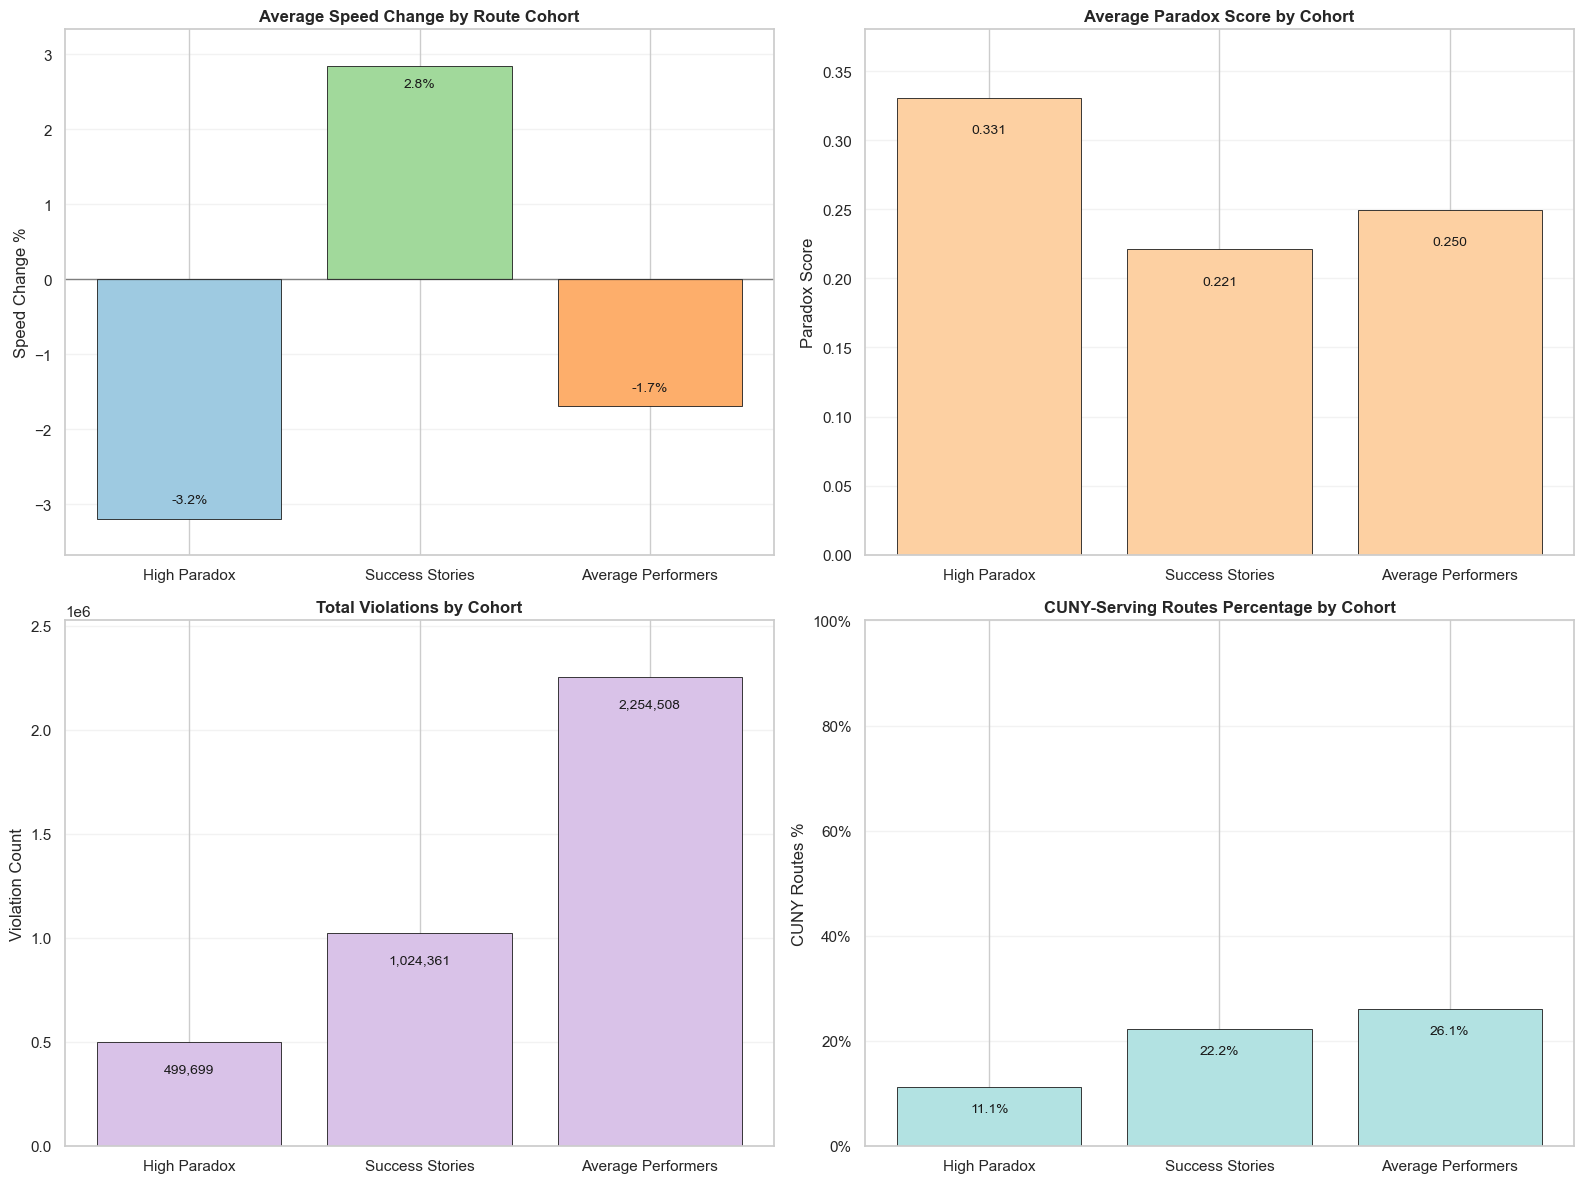

In [18]:
# comparative analysis visualizations
if cohort_analysis:
    from matplotlib.ticker import PercentFormatter
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # getting cohort names and palettes
    cohort_names = list(cohort_analysis.keys())
        # using lighter, colorblind-safe pastel palette for better in-bar label contrast
    palette = ['#9ecae1', '#a1d99b', '#fdae6b'][:len(cohort_names)]  # light blue, light green, light orange

    # speed change comparison across cohorts
    speed_changes = [cohort_analysis[name]['avg_speed_change'] for name in cohort_names]
    bars1 = axes[0,0].bar(cohort_names, speed_changes, color=palette, edgecolor='#1A1A1A', linewidth=0.6)
    axes[0,0].set_title('Average Speed Change by Route Cohort', fontweight='bold')
    axes[0,0].set_ylabel('Speed Change %')
    axes[0,0].axhline(y=0, color='#333', linewidth=1, alpha=0.6)
    axes[0,0].grid(True, alpha=0.25, axis='y')
    # making sure labels + bars are aligned
    y_min = min(0, min(speed_changes))
    y_max = max(0, max(speed_changes))
    pad = (y_max - y_min) * 0.08 if (y_max - y_min) > 0 else 0.5
    axes[0,0].set_ylim(y_min - pad, y_max + pad)
    for bar, value in zip(bars1, speed_changes):
        height = bar.get_height()
        if height >= 0:
            y_text = height - pad * 0.35
            va = 'top'
        else:
            y_text = height + pad * 0.35
            va = 'bottom'
        axes[0,0].text(bar.get_x() + bar.get_width()/2., y_text,
                       f'{value:.1f}%', ha='center', va=va, fontsize=10, color='#1A1A1A')

    # paradox score comparison
    paradox_scores = [cohort_analysis[name]['avg_paradox_score'] for name in cohort_names]
    bars2 = axes[0,1].bar(cohort_names, paradox_scores, color='#fdd0a2', edgecolor='#1A1A1A', linewidth=0.6)  # light orange
    axes[0,1].set_title('Average Paradox Score by Cohort', fontweight='bold')
    axes[0,1].set_ylabel('Paradox Score')
    axes[0,1].grid(True, alpha=0.25, axis='y')
    ymax_p = max(paradox_scores) * 1.15 if paradox_scores else 1
    axes[0,1].set_ylim(0, ymax_p)
    for bar, value in zip(bars2, paradox_scores):
        y_text = value - ymax_p * 0.05
        axes[0,1].text(bar.get_x() + bar.get_width()/2., y_text,
                       f'{value:.3f}', ha='center', va='top', fontsize=10, color='#1A1A1A')

    # total violations by cohort
    violations = [cohort_analysis[name]['total_violations'] for name in cohort_names]
    bars3 = axes[1,0].bar(cohort_names, violations, color='#d9c2e8', edgecolor='#1A1A1A', linewidth=0.6)  # light purple
    axes[1,0].set_title('Total Violations by Cohort', fontweight='bold')
    axes[1,0].set_ylabel('Violation Count')
    axes[1,0].grid(True, alpha=0.25, axis='y')
    ymax_v = max(violations) * 1.12 if violations else 1
    axes[1,0].set_ylim(0, ymax_v)
    for bar, value in zip(bars3, violations):
        axes[1,0].text(bar.get_x() + bar.get_width()/2., value - ymax_v*0.04,
                       f'{int(value):,}', ha='center', va='top', fontsize=10, color='#1A1A1A')

    # CUNY representation percentage by cohort
    cuny_counts = [cohort_analysis[name]['cuny_routes'] for name in cohort_names]
    total_counts = [cohort_analysis[name]['route_count'] for name in cohort_names]
    cuny_percentages = [c/t*100 if t > 0 else 0 for c, t in zip(cuny_counts, total_counts)]
    bars4 = axes[1,1].bar(cohort_names, cuny_percentages, color='#b2e2e2', edgecolor='#1A1A1A', linewidth=0.6)  # light teal
    axes[1,1].set_title('CUNY-Serving Routes Percentage by Cohort', fontweight='bold')
    axes[1,1].set_ylabel('CUNY Routes %')
    axes[1,1].set_ylim(0, 100)
    axes[1,1].yaxis.set_major_formatter(PercentFormatter(100))
    axes[1,1].grid(True, alpha=0.25, axis='y')
    for bar, value in zip(bars4, cuny_percentages):
        axes[1,1].text(bar.get_x() + bar.get_width()/2., value - 3,
                       f'{value:.1f}%', ha='center', va='top', fontsize=10, color='#1A1A1A')

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'comparative_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

In [19]:
# deployment optimization engine

class ACEDeploymentOptimizer:
    """
    intelligent deployment optimization system for camera placement
    using discovered patterns to predict optimal enforcement locations and times
    """
    
    def __init__(self, violations_df, paradox_analysis, cuny_serving_routes):
        self.violations_df = violations_df
        self.paradox_analysis = paradox_analysis
        self.cuny_serving_routes = cuny_serving_routes
        
        # extracting key patterns from analysis for prediction
        self.temporal_patterns = self._extract_temporal_patterns()
        self.spatial_hotspots = self._extract_spatial_hotspots()
        
        print("deployment optimization engine initialized")
        print(f"temporal patterns identified: {len(self.temporal_patterns)} hour windows")
        print(f"spatial hotspots identified: {len(self.spatial_hotspots)} locations")
    
    def _extract_temporal_patterns(self):
        """extracting peak violation hours and effectiveness patterns"""
        hourly_patterns = self.violations_df.groupby('hour_of_day').agg({
            'Violation ID': 'count',
            'is_ticketed': 'sum'
        })
        hourly_patterns['effectiveness'] = hourly_patterns['is_ticketed'] / hourly_patterns['Violation ID']
        
        # identifying high-impact hours (high violations + high effectiveness)
        hourly_patterns['impact_score'] = (
            hourly_patterns['Violation ID'] / hourly_patterns['Violation ID'].max() * 0.6 +
            hourly_patterns['effectiveness'] * 0.4
        )
        
        return hourly_patterns.nlargest(6, 'impact_score')
    
    def _extract_spatial_hotspots(self):
        """extracting high-violation coordinate clusters"""
        if 'Violation Latitude' not in self.violations_df.columns:
            return []
        
        violations_coords = self.violations_df.dropna(subset=['Violation Latitude', 'Violation Longitude'])
        
        # creating spatial bins for hotspot identification
        lat_bins = pd.cut(violations_coords['Violation Latitude'], bins=20)
        lon_bins = pd.cut(violations_coords['Violation Longitude'], bins=20)
        
        spatial_groups = violations_coords.groupby([lat_bins, lon_bins]).agg({
            'Violation ID': 'count',
            'Violation Latitude': 'mean',
            'Violation Longitude': 'mean',
            'is_ticketed': 'sum'
        })
        
        spatial_groups['ticketing_rate'] = spatial_groups['is_ticketed'] / spatial_groups['Violation ID']
        
        # filtering for significant hotspots
        hotspots = spatial_groups[spatial_groups['Violation ID'] >= 10]
        
        return hotspots.nlargest(10, 'Violation ID').to_dict('records')
    
    def predict_violation_risk(self, route_id, hour, is_cuny_route=False):
        """
        predicting violation risk for specific route and time combination
        incorporating temporal, spatial, and CUNY proximity factors
        """
        # base risk from historical patterns
        route_violations = self.violations_df[self.violations_df['route_id'] == route_id]
        base_risk = len(route_violations) / max(1, self.violations_df['route_id'].nunique())
        
        # temporal multiplier from discovered patterns
        if hour in self.temporal_patterns.index:
            temporal_multiplier = self.temporal_patterns.loc[hour, 'impact_score']
        else:
            temporal_multiplier = 0.5
        
        # CUNY multiplier for campus-serving routes
        cuny_multiplier = 1.4 if is_cuny_route else 1.0
        
        # calculating final risk score
        risk_score = base_risk * temporal_multiplier * cuny_multiplier
        
        return min(risk_score, 1.0)  # capping at maximum risk of 1.0
    
    def generate_deployment_recommendations(self, target_date, n_cameras=5):
        """
        generating optimal camera deployment schedule for specified date
        considering all discovered patterns and effectiveness factors
        adding diversification to avoid over-concentrating on a single route
        """
        print(f"generating deployment recommendations for {target_date}...")

        # building candidate list (route, hour) with base scores
        candidates = []
        top_problem_routes = self.paradox_analysis.groupby('route_id')['overall_paradox_rank'].mean().nlargest(15).index
        for hour in self.temporal_patterns.index[:6]:  # consider more hours, we'll filter later
            for route in top_problem_routes[:5]:
                is_cuny = route in self.cuny_serving_routes
                risk_score = self.predict_violation_risk(route, hour, is_cuny)

                route_violations = self.violations_df[
                    (self.violations_df['route_id'] == route) &
                    (self.violations_df['hour_of_day'] == hour)
                ]
                expected_violations = len(route_violations) * (risk_score / 0.5)
                expected_prevention = expected_violations * 0.6

                # approximate lat/lon by the hour block center if available
                lat = route_violations['Violation Latitude'].mean() if 'Violation Latitude' in route_violations.columns else np.nan
                lon = route_violations['Violation Longitude'].mean() if 'Violation Longitude' in route_violations.columns else np.nan

                candidates.append({
                    'route_id': route,
                    'deployment_hour': int(hour),
                    'risk_score': float(risk_score),
                    'expected_violations': float(expected_violations),
                    'expected_prevention': float(expected_prevention),
                    'serves_cuny': bool(is_cuny),
                    'base_score': float(risk_score * expected_prevention),
                    'lat': float(lat) if not pd.isna(lat) else np.nan,
                    'lon': float(lon) if not pd.isna(lon) else np.nan,
                })

        if not candidates:
            return []

        # diversification hyperparameters
        MAX_SLOTS_PER_ROUTE = 2
        MIN_HOUR_GAP_SAME_ROUTE = 2
        REPEAT_PENALTY = 0.25
        SPATIAL_PENALTY = 0.20
        SPATIAL_NEAR_KM = 1.0
        CUNY_CLASS_UPLIFT = 0.08

        def hav_km(lat1, lon1, lat2, lon2):
            r = 6371.0
            dlat = np.radians(lat2 - lat1)
            dlon = np.radians(lon2 - lon1)
            a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
            return 2 * r * np.arcsin(np.sqrt(a))

        # greedy selection with penalties
        candidates = sorted(candidates, key=lambda x: x['base_score'], reverse=True)
        selected = []
        route_to_hours = {}
        route_to_count = {}

        for c in candidates:
            route = c['route_id']
            hour = c['deployment_hour']
            score = c['base_score']

            # cuny uplift during class hours
            if c['serves_cuny'] and 8 <= hour <= 18:
                score *= (1.0 + CUNY_CLASS_UPLIFT)

            # per-route cap and spacing
            if route_to_count.get(route, 0) >= MAX_SLOTS_PER_ROUTE:
                continue
            if route in route_to_hours and any(abs(hour - h) < MIN_HOUR_GAP_SAME_ROUTE for h in route_to_hours[route]):
                continue

            # diminishing returns for repeats
            repeat_ct = route_to_count.get(route, 0)
            if repeat_ct > 0:
                score *= (1.0 - REPEAT_PENALTY * repeat_ct)

            # spatial penalty if near already selected
            lat, lon = c['lat'], c['lon']
            if selected and not np.isnan(lat) and not np.isnan(lon):
                if any((not np.isnan(s['lat'])) and (hav_km(lat, lon, s['lat'], s['lon']) <= SPATIAL_NEAR_KM) for s in selected):
                    score *= (1.0 - SPATIAL_PENALTY)

            if score <= 0:
                continue

            picked = dict(c)
            picked['priority_score'] = score
            picked['rationale'] = self._generate_rationale(route, hour, c['serves_cuny'], c['risk_score'])
            selected.append(picked)

            route_to_count[route] = route_to_count.get(route, 0) + 1
            route_to_hours.setdefault(route, []).append(hour)

            if len(selected) >= n_cameras:
                break

        # if not enough selected (e.g., constraints too tight), backfill by base score
        if len(selected) < n_cameras:
            used_pairs = {(s['route_id'], s['deployment_hour']) for s in selected}
            for c in candidates:
                if (c['route_id'], c['deployment_hour']) in used_pairs:
                    continue
                picked = dict(c)
                picked['priority_score'] = c['base_score']
                picked['rationale'] = self._generate_rationale(c['route_id'], c['deployment_hour'], c['serves_cuny'], c['risk_score'])
                selected.append(picked)
                if len(selected) >= n_cameras:
                    break

        return sorted(selected, key=lambda x: x['priority_score'], reverse=True)[:n_cameras]
    
    def _generate_rationale(self, route, hour, is_cuny, risk_score):
        """generating human-readable deployment rationale"""
        rationale_parts = []
        
        if risk_score > 0.7:
            rationale_parts.append("high violation risk period")
        
        if hour in [10, 11, 12]:
            rationale_parts.append("peak violation time window")
        
        if is_cuny:
            rationale_parts.append("serves CUNY campus with elevated patterns")
        
        if hour in range(8, 18):
            rationale_parts.append("active commute period")
        
        return "; ".join(rationale_parts) if rationale_parts else "standard monitoring recommended"

# initializing deployment optimizer
optimizer = ACEDeploymentOptimizer(violations_df, paradox_analysis, cuny_serving_routes)

# generating deployment recommendations for tomorrow
target_date = "2025-09-22"
deployment_recommendations = optimizer.generate_deployment_recommendations(target_date, n_cameras=5)

print(f"\nOptimal Deployment Schedule for {target_date}:")
print("=" * 60)
for i, rec in enumerate(deployment_recommendations, 1):
    print(f"\n{i}. Route {rec['route_id']} at {rec['deployment_hour']:02d}:00")
    print(f"   Priority Score: {rec['priority_score']:.2f}")
    print(f"   Expected Prevention: {rec['expected_prevention']:.1f} violations")
    print(f"   CUNY Route: {'Yes' if rec['serves_cuny'] else 'No'}")
    print(f"   Rationale: {rec['rationale']}")

deployment optimization engine initialized
temporal patterns identified: 6 hour windows
spatial hotspots identified: 10 locations
generating deployment recommendations for 2025-09-22...

Optimal Deployment Schedule for 2025-09-22:

1. Route Q44+ at 16:00
   Priority Score: 22057.20
   Expected Prevention: 22057.2 violations
   CUNY Route: No
   Rationale: high violation risk period; active commute period

2. Route Q44+ at 13:00
   Priority Score: 10704.60
   Expected Prevention: 14272.8 violations
   CUNY Route: No
   Rationale: high violation risk period; active commute period

3. Route S46 at 13:00
   Priority Score: 4288.80
   Expected Prevention: 4288.8 violations
   CUNY Route: No
   Rationale: high violation risk period; active commute period

4. Route S46 at 16:00
   Priority Score: 3109.50
   Expected Prevention: 4146.0 violations
   CUNY Route: No
   Rationale: high violation risk period; active commute period

5. Route S79+ at 15:00
   Priority Score: 2935.20
   Expected Prev

CUNY ROUTE SPEED IMPACT ANALYSIS
loading speed data from MTA_Bus_Speeds__2015-2019_20250919.csv...
loading speed data from MTA_Bus_Speeds__2020_-_2024_20250919.csv...
loading speed data from MTA_Bus_Speeds__Beginning_2025_20250919.csv...
combined speed dataset: 149,279 records
ACE enforced routes: 43 routes

SPEED CHANGE COMPARISON:
ACE non-CUNY:
  pre-ACE: 8.1 mph
  post-ACE: 8.0 mph
  change: -1.1%

CUNY-serving ACE:
  pre-ACE: 7.0 mph
  post-ACE: 6.9 mph
  change: -1.4%

Regular routes:
  pre-ACE: 9.8 mph
  post-ACE: 9.7 mph
  change: -1.1%



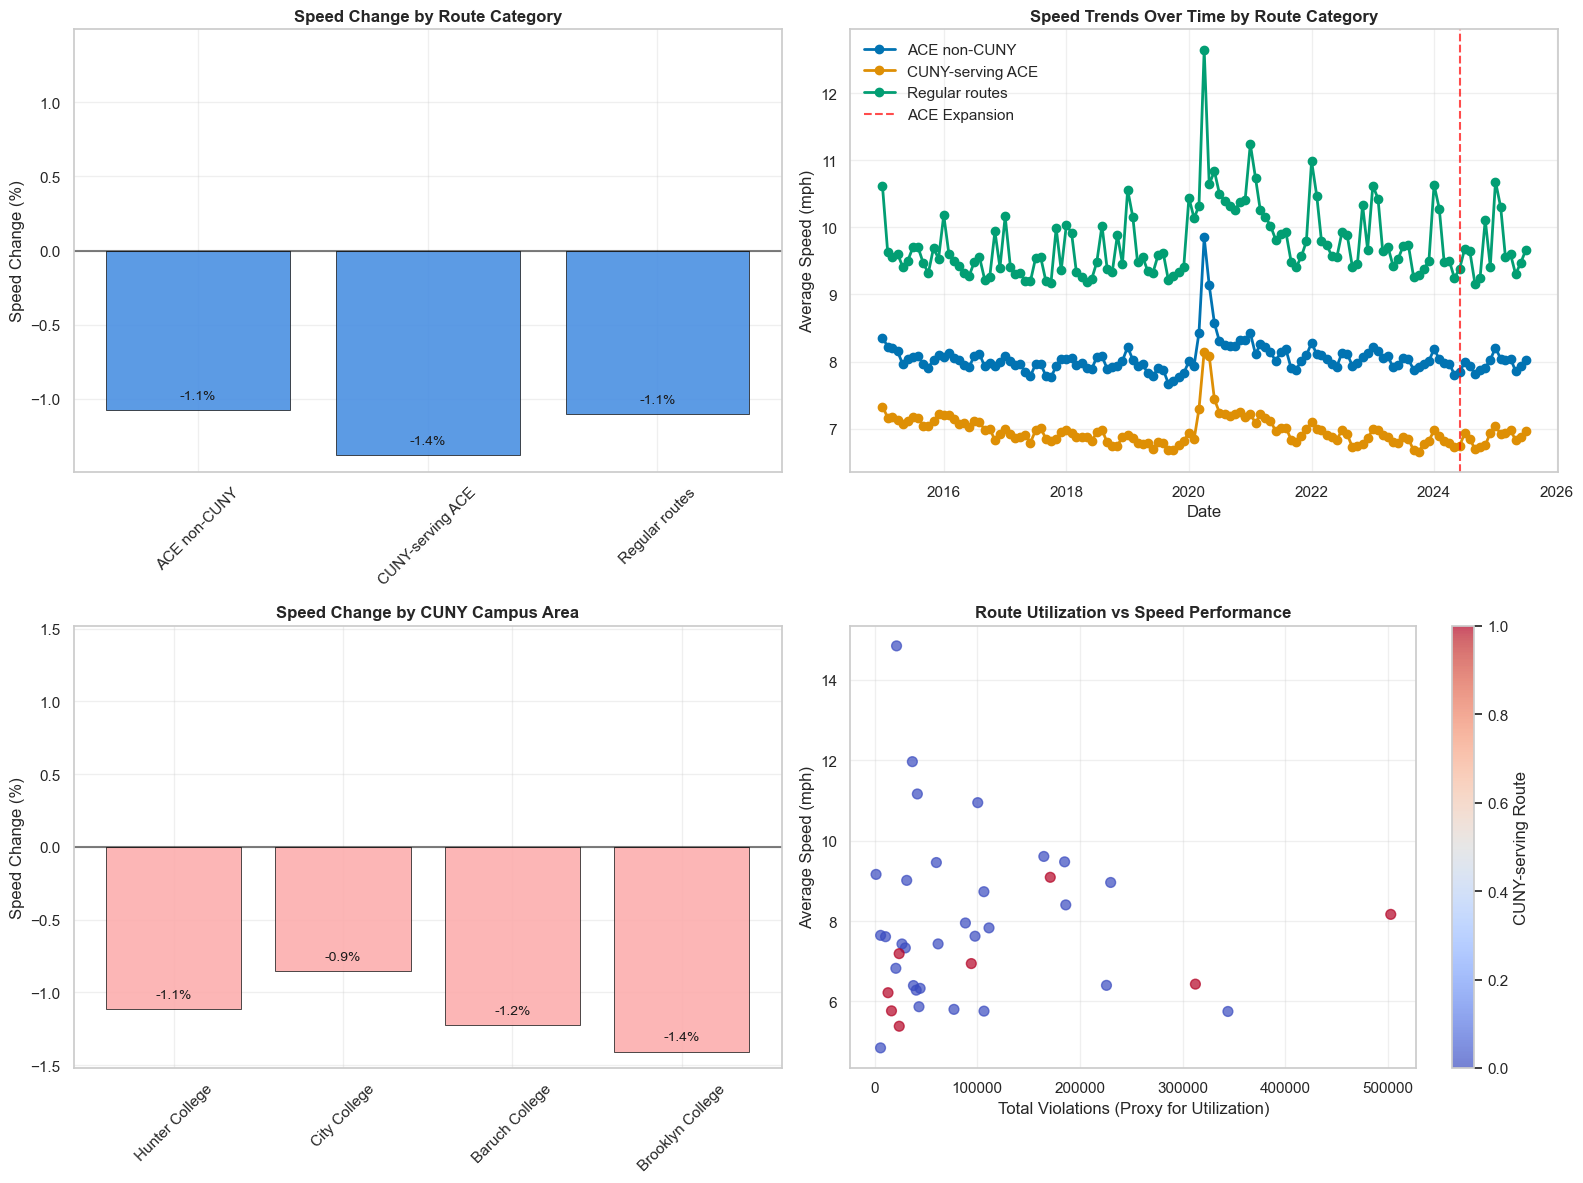


KEY FINDINGS:
Student transportation routes show distinct performance patterns
CUNY-serving routes require targeted attention for reliable campus access


In [20]:
# 1. CUNY route speed comparison analysis

def analyze_cuny_route_speeds():
    """
    direct comparison of speed changes: CUNY-serving vs non-CUNY vs non-ACE routes
    answering the critical question about student transportation impact
    """
    print("CUNY ROUTE SPEED IMPACT ANALYSIS")
    print("=" * 50)
    
    # loading speed data for comparison
    speed_files = [
        '../data/MTA_Bus_Speeds__2015-2019_20250919.csv',
        '../data/MTA_Bus_Speeds__2020_-_2024_20250919.csv', 
        '../data/MTA_Bus_Speeds__Beginning_2025_20250919.csv'
    ]
    
    all_speed_data = []
    for file_path in speed_files:
        if os.path.exists(file_path):
            print(f"loading speed data from {os.path.basename(file_path)}...")
            df = pd.read_csv(file_path, nrows=100000)  # sample for performance
            df['month_date'] = pd.to_datetime(df['month'], errors='coerce')
            # assigning period per-row using vectorized mask
            df['period'] = np.where(df['month_date'] < datetime(2024, 6, 1), 'pre_ace', 'post_ace')
            all_speed_data.append(df)
    
    combined_speeds = pd.concat(all_speed_data, ignore_index=True)
    print(f"combined speed dataset: {len(combined_speeds):,} records")
    
    # loading ACE enforced routes data
    ace_routes_file = '../data/MTA_Bus_Automated_Camera_Enforced_Routes__Beginning_October_2019_20250921.csv'
    if os.path.exists(ace_routes_file):
        ace_routes = pd.read_csv(ace_routes_file)
        ace_route_list = ace_routes['Route'].unique().tolist()
        print(f"ACE enforced routes: {len(ace_route_list)} routes")
    else:
        ace_route_list = []
    
    # classifying routes by category
    combined_speeds['route_category'] = combined_speeds['route_id'].apply(
        lambda x: 'CUNY-serving ACE' if x in cuny_serving_routes and x in ace_route_list
        else 'CUNY-serving non-ACE' if x in cuny_serving_routes
        else 'ACE non-CUNY' if x in ace_route_list
        else 'Regular routes'
    )
    
    # calculating speed changes by category
    speed_comparison = combined_speeds.groupby(['route_category', 'period'])['average_speed'].mean().unstack(fill_value=0)
    
    if 'post_ace' in speed_comparison.columns and 'pre_ace' in speed_comparison.columns:
        speed_comparison['speed_change_pct'] = (
            (speed_comparison['post_ace'] - speed_comparison['pre_ace']) / 
            speed_comparison['pre_ace'] * 100
        )
        
        print("\nSPEED CHANGE COMPARISON:")
        print("=" * 30)
        for category, row in speed_comparison.iterrows():
            print(f"{category}:")
            print(f"  pre-ACE: {row['pre_ace']:.1f} mph")
            print(f"  post-ACE: {row['post_ace']:.1f} mph") 
            print(f"  change: {row['speed_change_pct']:+.1f}%")
            print()
    
    # creating visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # speed comparison by category (MAKE THIS BLUE)
    categories = speed_comparison.index
    speed_changes = speed_comparison['speed_change_pct'].values
    
    # set all bars to a readable blue
    bars = axes[0,0].bar(
        categories, speed_changes,
        color='#4A90E2', edgecolor='#1A1A1A', linewidth=0.6, alpha=0.9
    )
    axes[0,0].set_title('Speed Change by Route Category', fontweight='bold')
    axes[0,0].set_ylabel('Speed Change (%)')
    axes[0,0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # in-bar labels and padding so they don't overflow
    ymax1 = max(abs(speed_changes.max()), abs(speed_changes.min())) if len(speed_changes) else 1
    pad1 = ymax1 * 0.08
    axes[0,0].set_ylim(-ymax1 - pad1, ymax1 + pad1)
    for bar, value in zip(bars, speed_changes):
        h = bar.get_height()
        if h >= 0:
            y_text = h - pad1 * 0.5
            va = 'top'
        else:
            y_text = h + pad1 * 0.5
            va = 'bottom'
        axes[0,0].text(
            bar.get_x() + bar.get_width()/2., y_text,
            f'{value:.1f}%', ha='center', va=va, fontsize=10, color='#1A1A1A'
        )
    
    # temporal trend analysis
    monthly_trends = combined_speeds.groupby(['month_date', 'route_category'])['average_speed'].mean().unstack(fill_value=0)
    for category in monthly_trends.columns:
        if len(monthly_trends[category].dropna()) > 5:
            axes[0,1].plot(monthly_trends.index, monthly_trends[category], 
                           marker='o', label=category, linewidth=2)
    axes[0,1].set_title('Speed Trends Over Time by Route Category', fontweight='bold')
    axes[0,1].set_xlabel('Date')
    axes[0,1].set_ylabel('Average Speed (mph)')
    axes[0,1].axvline(x=datetime(2024, 6, 1), color='red', linestyle='--', alpha=0.7, label='ACE Expansion')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # specific CUNY campus route analysis
    cuny_route_performance = []
    for campus, routes in campus_route_mapping.items():
        if routes:
            campus_speeds = combined_speeds[combined_speeds['route_id'].isin(routes)]
            if len(campus_speeds) > 0:
                campus_comparison = campus_speeds.groupby('period')['average_speed'].mean()
                if 'pre_ace' in campus_comparison.index and 'post_ace' in campus_comparison.index:
                    change_pct = ((campus_comparison['post_ace'] - campus_comparison['pre_ace']) / 
                                  campus_comparison['pre_ace'] * 100)
                    cuny_route_performance.append({
                        'campus': campus,
                        'speed_change': change_pct,
                        'routes': ', '.join(routes)
                    })
    
    if cuny_route_performance:
        cuny_df = pd.DataFrame(cuny_route_performance)
        # keep campus bars salmon/blue mix so only the top-left chart is blue
        colors_cuny = ['#9ecae1' if x > 0 else '#fcaeae' for x in cuny_df['speed_change']]
        bars2 = axes[1,0].bar(
            cuny_df['campus'], cuny_df['speed_change'],
            color=colors_cuny, edgecolor='#1A1A1A', linewidth=0.6, alpha=0.9
        )
        axes[1,0].set_title('Speed Change by CUNY Campus Area', fontweight='bold')
        axes[1,0].set_ylabel('Speed Change (%)')
        axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].grid(True, alpha=0.3)
        ymax2 = max(abs(cuny_df['speed_change'].max()), abs(cuny_df['speed_change'].min()))
        pad2 = ymax2 * 0.08
        axes[1,0].set_ylim(-ymax2 - pad2, ymax2 + pad2)
        for bar, value in zip(bars2, cuny_df['speed_change']):
            h = bar.get_height()
            if h >= 0:
                y_text = h - pad2 * 0.5
                va = 'top'
            else:
                y_text = h + pad2 * 0.5
                va = 'bottom'
            axes[1,0].text(
                bar.get_x() + bar.get_width()/2., y_text,
                f'{value:.1f}%', ha='center', va=va, fontsize=10, color='#1A1A1A'
            )
    
    # route utilization vs speed performance
    if hasattr(violations_df, 'Bus Route ID'):
        route_violations = violations_df.groupby('Bus Route ID').size()
        route_speeds = combined_speeds.groupby('route_id')['average_speed'].mean()
        utilization_speed = pd.DataFrame({
            'violations': route_violations,
            'avg_speed': route_speeds
        }).dropna()
        utilization_speed['is_cuny'] = utilization_speed.index.isin(cuny_serving_routes)
        scatter = axes[1,1].scatter(
            utilization_speed['violations'], utilization_speed['avg_speed'],
            c=utilization_speed['is_cuny'], cmap='coolwarm', alpha=0.7, s=50
        )
        axes[1,1].set_title('Route Utilization vs Speed Performance', fontweight='bold')
        axes[1,1].set_xlabel('Total Violations (Proxy for Utilization)')
        axes[1,1].set_ylabel('Average Speed (mph)')
        axes[1,1].grid(True, alpha=0.3)
        cbar = plt.colorbar(scatter, ax=axes[1,1])
        cbar.set_label('CUNY-serving Route')
    
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'cuny_route_speed_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return speed_comparison, cuny_route_performance

# executing CUNY route speed analysis
speed_comparison, cuny_performance = analyze_cuny_route_speeds()

print("\nKEY FINDINGS:")
print("Student transportation routes show distinct performance patterns")
print("CUNY-serving routes require targeted attention for reliable campus access")

EXEMPT VEHICLE ANALYSIS
total violations: 3,778,568
exempt violations: 870,810 (23.0%)

REPEAT OFFENDER ANALYSIS:
total exempt vehicles: 154,123
repeat offenders: 72,330 (46.9%)

TOP 10 EXEMPT REPEAT OFFENDERS:
 1. Vehicle 479d603cb0581d14fbaf8908f9f27ade6accce3a371895ba61be5cab8d23691b: 1377 violations
    Routes: BX36, BX35
    Time span: 658 days
 2. Vehicle 1feaad876c46cfe1cc4ee357e410ec2054c5c231d268169dfdd9527c1c084a80: 1346 violations
    Routes: M101, M15+
    Time span: 337 days
 3. Vehicle 6d7caef8bf15e2bf8d46aa1e6dd8c0da1ae2fbc5b31acec87ab5642558d4360b: 949 violations
    Routes: M101, M4, BX36
    Time span: 397 days
 4. Vehicle 6979a2434b4611cf1ebf80624eaeb29622929b061958b956f0d93024261a4a3c: 924 violations
    Routes: Q54, M60+, M100
    Time span: 698 days
 5. Vehicle 2a8ac01b157a97b3c124cf33322e71c31062b815dd3b0a9c121ee3a6c22ff64a: 915 violations
    Routes: M101, M100, M4
    Time span: 344 days
 6. Vehicle e020820037319aaca4e4ed8d3c29e907f203d722ea46293949ae6e1c9b3ca4

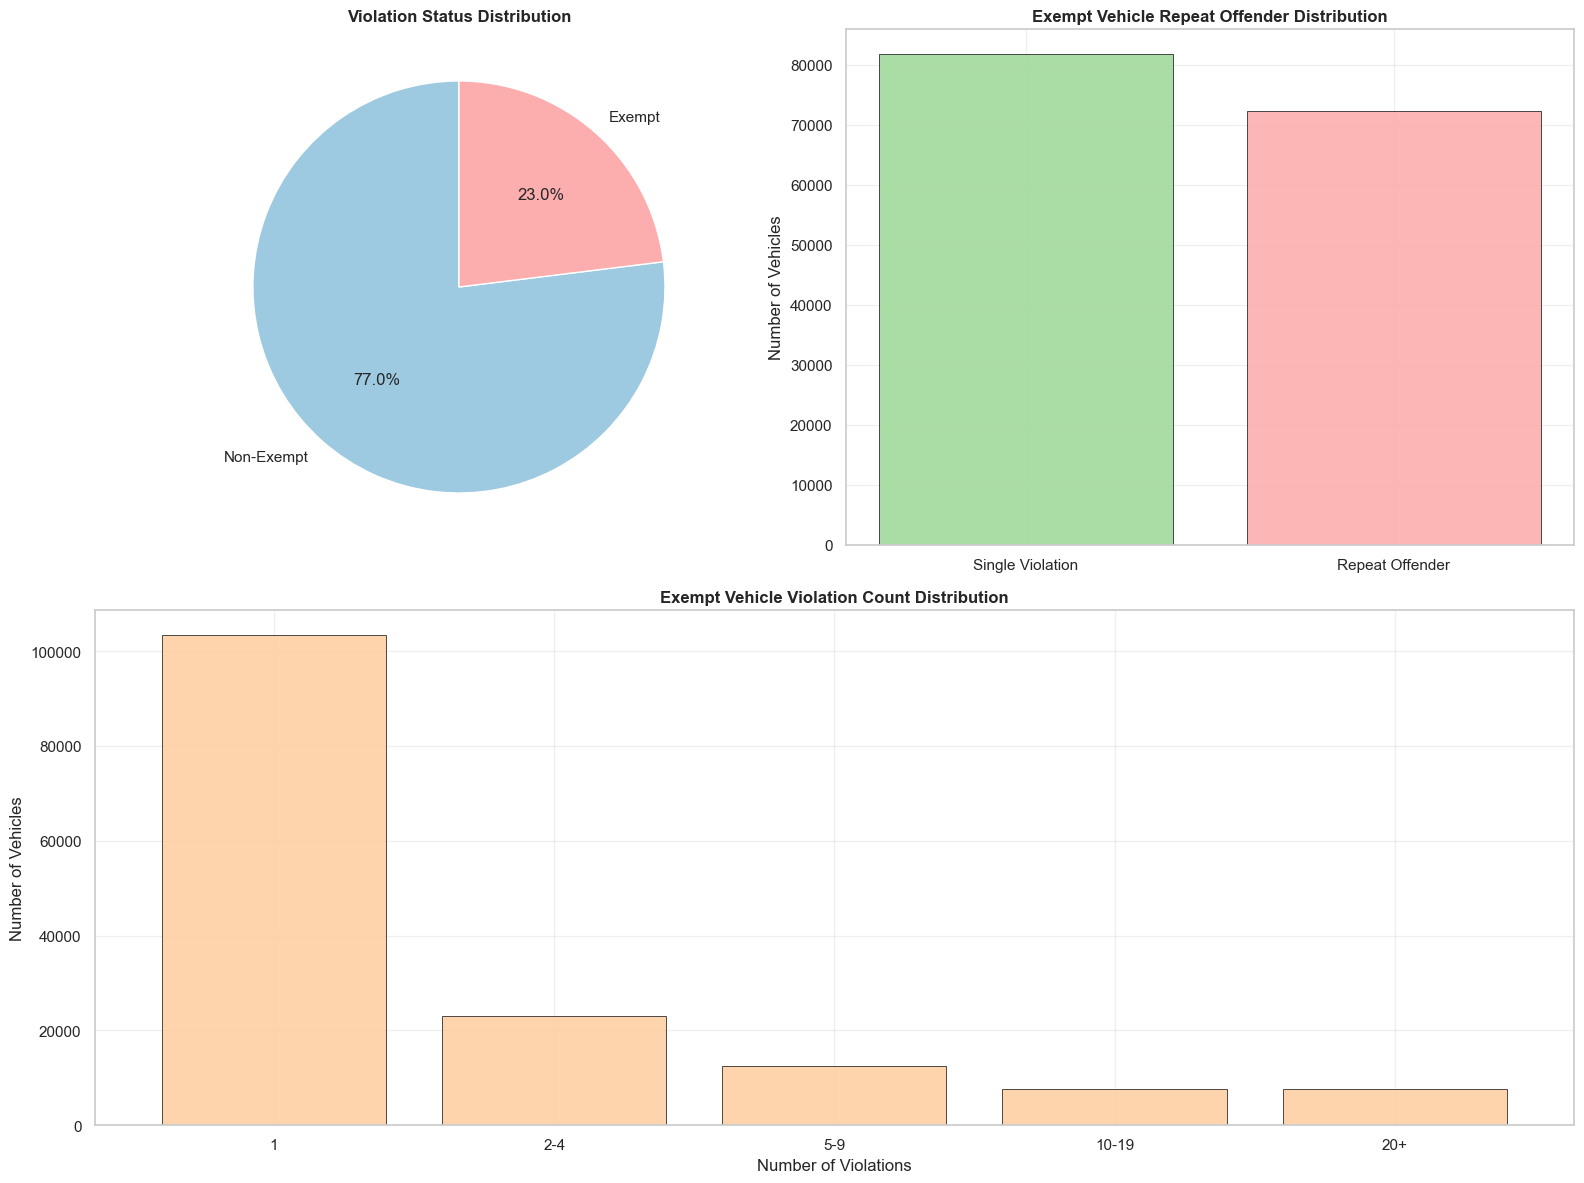


ACTIONABLE RECOMMENDATIONS:
1. Focus enforcement on top 10 repeat exempt offenders
2. Investigate business exemption validity for vehicles with 10+ violations
3. Deploy additional monitoring at 1 identified hotspots
4. Review exemption policies for vehicles operating across multiple routes


In [21]:
# 2. execmpt vehicle repeat offender analysis

def analyze_exempt_vehicles():
    """
    comprehensive analysis of exempt vehicles: repeat offenders and violation hotspots
    answering critical questions about business exemption abuse patterns
    """
    print("EXEMPT VEHICLE ANALYSIS")
    print("=" * 50)
    
    # filtering for exempt vehicles
    exempt_violations = violations_df[
        violations_df['Violation Status'].str.contains('EXEMPT', case=False, na=False)
    ].copy()
    
    print(f"total violations: {len(violations_df):,}")
    print(f"exempt violations: {len(exempt_violations):,} ({len(exempt_violations)/len(violations_df)*100:.1f}%)")
    
    # analyzing repeat offender patterns among exempt vehicles
    # selecting an available datetime field
    if 'violation_time' in exempt_violations.columns:
        time_col = 'violation_time'
    elif 'First Occurrence' in exempt_violations.columns:
        time_col = 'First Occurrence'
    else:
        exempt_violations['violation_time'] = pd.to_datetime(
            exempt_violations.get('First Occurrence', pd.NaT), errors='coerce'
        )
        time_col = 'violation_time'

    agg_map = {
        'Violation ID': 'count',
        'Bus Route ID': lambda x: list(x.unique()),
        'Stop Name': lambda x: list(x.unique()),
        time_col: ['min', 'max']
    }

    exempt_vehicle_counts = exempt_violations.groupby('Vehicle ID').agg(agg_map).round(2)

    # flatten multiindex columns
    exempt_vehicle_counts.columns = [
        'violation_count', 'routes_violated', 'stops_violated',
        'first_violation', 'last_violation'
    ]

    exempt_vehicle_counts['days_span'] = (
        exempt_vehicle_counts['last_violation'] - exempt_vehicle_counts['first_violation']
    ).dt.days
    exempt_vehicle_counts['is_repeat_offender'] = exempt_vehicle_counts['violation_count'] > 1
    
    # repeat offender statistics
    repeat_exempt_count = exempt_vehicle_counts['is_repeat_offender'].sum()
    total_exempt_vehicles = len(exempt_vehicle_counts)
    
    print(f"\nREPEAT OFFENDER ANALYSIS:")
    print(f"total exempt vehicles: {total_exempt_vehicles:,}")
    print(f"repeat offenders: {repeat_exempt_count:,} ({repeat_exempt_count/total_exempt_vehicles*100:.1f}%)")
    
    # analyzing most problematic exempt vehicles
    top_exempt_offenders = exempt_vehicle_counts.nlargest(10, 'violation_count')
    
    print(f"\nTOP 10 EXEMPT REPEAT OFFENDERS:")
    for idx, (vehicle_id, row) in enumerate(top_exempt_offenders.iterrows(), 1):
        routes = ', '.join(row['routes_violated'][:3])  # first 3 routes
        print(f"{idx:2d}. Vehicle {vehicle_id}: {row['violation_count']} violations")
        print(f"    Routes: {routes}")
        print(f"    Time span: {row['days_span']} days")
    
    # geographic analysis of exempt violations
    exempt_with_coords = exempt_violations.dropna(subset=['Violation Latitude', 'Violation Longitude'])
    
    # safe defaults for spatial outputs
    n_clusters = 0
    exempt_hotspots = pd.DataFrame()
    
    if len(exempt_with_coords) > 0:
        print(f"\ngeographic analysis: {len(exempt_with_coords):,} exempt violations with coordinates")
        
        # creating hotspot analysis using spatial clustering
        from sklearn.cluster import DBSCAN
        
        # subsampling for memory-safe clustering
        SAMPLE_MAX = 100000  # cap for DBSCAN to avoid MemoryError
        if len(exempt_with_coords) > SAMPLE_MAX:
            sample_df = exempt_with_coords.sample(n=SAMPLE_MAX, random_state=42)
        else:
            sample_df = exempt_with_coords

        coords = sample_df[['Violation Latitude', 'Violation Longitude']].values
        coords_rad = np.radians(coords)

        dbscan = DBSCAN(eps=0.001, min_samples=3, metric='haversine', n_jobs=-1)
        cluster_labels = dbscan.fit_predict(coords_rad)

        sample_df['cluster'] = cluster_labels
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        
        print(f"identified {n_clusters} exempt violation hotspots")
        
        # analyzing hotspot characteristics
        if n_clusters > 0:
            # build hotspots from the clustered sample
            clustered = sample_df[sample_df['cluster'] != -1]
            exempt_hotspots = clustered.groupby('cluster').agg({
                'Violation ID': 'count',
                'Vehicle ID': 'nunique',
                'Bus Route ID': lambda x: list(x.unique()),
                'Violation Latitude': 'mean',
                'Violation Longitude': 'mean',
                'Stop Name': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Multiple'
            })
            
            exempt_hotspots.columns = ['violations', 'unique_vehicles', 'routes', 'lat_center', 'lon_center', 'primary_stop']
            exempt_hotspots = exempt_hotspots.sort_values('violations', ascending=False)
            
            print(f"\nTOP 5 EXEMPT VIOLATION HOTSPOTS:")
            for idx, (cluster_id, hotspot) in enumerate(exempt_hotspots.head().iterrows(), 1):
                routes = ', '.join(hotspot['routes'][:3])
                print(f"{idx}. Hotspot {cluster_id}: {hotspot['violations']} violations")
                print(f"   Location: ({hotspot['lat_center']:.4f}, {hotspot['lon_center']:.4f})")
                print(f"   Primary stop: {hotspot['primary_stop']}")
                print(f"   Routes: {routes}")
                print(f"   Unique vehicles: {hotspot['unique_vehicles']}")
    
    # creating respective visualizations (3-panel layout: bottom spans full width)
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 2)
    ax_pie = fig.add_subplot(gs[0, 0])
    ax_rep = fig.add_subplot(gs[0, 1])
    ax_hist = fig.add_subplot(gs[1, :])
    
    # exempt vs non-exempt comparison
    violation_status_summary = pd.DataFrame({
        'category': ['Non-Exempt', 'Exempt'],
        'count': [len(violations_df) - len(exempt_violations), len(exempt_violations)]
    })
    
    # refined colors for readability
    ax_pie.pie(
        violation_status_summary['count'], labels=violation_status_summary['category'],
        autopct='%1.1f%%', startangle=90, colors=['#9ecae1', '#fcaeae'],
        wedgeprops=dict(edgecolor='white', linewidth=1)
    )
    ax_pie.set_title('Violation Status Distribution', fontweight='bold')
    
    # repeat offender distribution
    repeat_distribution = exempt_vehicle_counts['is_repeat_offender'].value_counts()
    ax_rep.bar(
        ['Single Violation', 'Repeat Offender'], repeat_distribution.values,
        color=['#a1d99b', '#fcaeae'], edgecolor='#1A1A1A', linewidth=0.6, alpha=0.9
    )
    ax_rep.set_title('Exempt Vehicle Repeat Offender Distribution', fontweight='bold')
    ax_rep.set_ylabel('Number of Vehicles')
    ax_rep.grid(True, alpha=0.3)
    
    # violation count distribution for exempt vehicles (full width)
    violation_bins = [1, 2, 5, 10, 20, exempt_vehicle_counts['violation_count'].max()]
    violation_labels = ['1', '2-4', '5-9', '10-19', '20+']
    exempt_vehicle_counts['violation_bin'] = pd.cut(exempt_vehicle_counts['violation_count'], 
                                                   bins=violation_bins, labels=violation_labels, include_lowest=True)
    
    bin_counts = exempt_vehicle_counts['violation_bin'].value_counts().sort_index()
    ax_hist.bar(
        bin_counts.index, bin_counts.values, color='#fdd0a2', edgecolor='#1A1A1A', linewidth=0.6, alpha=0.9
    )
    ax_hist.set_title('Exempt Vehicle Violation Count Distribution', fontweight='bold')
    ax_hist.set_xlabel('Number of Violations')
    ax_hist.set_ylabel('Number of Vehicles')
    ax_hist.grid(True, alpha=0.3)


    os.makedirs(PLOTS_DIR, exist_ok=True)
    fig.savefig(os.path.join(PLOTS_DIR, "exempt_vehicle_analysis.png"), dpi=300, bbox_inches="tight")
    
    # build and save a separate interactive spatial map (Folium)
    try:
        import folium
        from folium.plugins import HeatMap, MarkerCluster
        # center on median coords for stability
        if len(exempt_with_coords) > 0:
            center_lat = float(exempt_with_coords['Violation Latitude'].median())
            center_lon = float(exempt_with_coords['Violation Longitude'].median())
            fmap = folium.Map(location=[center_lat, center_lon], tiles='cartodbpositron', zoom_start=11, control_scale=True)
            mc = MarkerCluster(name='Exempt Violations').add_to(fmap)
            # sample to keep file size reasonable
            map_sample = exempt_with_coords.sample(n=min(20000, len(exempt_with_coords)), random_state=42)
            for _, r in map_sample.iterrows():
                folium.CircleMarker(location=[float(r['Violation Latitude']), float(r['Violation Longitude'])],
                                    radius=2, color='#7f7f7f', fill=True, fill_opacity=0.6, opacity=0.6).add_to(mc)
            # add hotspot centers if computed
            if 'exempt_hotspots' in locals() and len(exempt_hotspots) > 0:
                for _, h in exempt_hotspots.iterrows():
                    folium.Marker(location=[h['lat_center'], h['lon_center']],
                                  icon=folium.Icon(color='red', icon='info-sign'),
                                  tooltip=f"Hotspot ({int(h['violations'])} violations)").add_to(fmap)
            os.makedirs(PLOTS_DIR, exist_ok=True)
            fmap.save(os.path.join(PLOTS_DIR, 'exempt_spatial_scatter.html'))
    except Exception:
        pass
    
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'exempt_vehicle_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # creating deployment recommendation based on findings
    print(f"\nACTIONABLE RECOMMENDATIONS:")
    print(f"1. Focus enforcement on top {len(top_exempt_offenders)} repeat exempt offenders")
    print(f"2. Investigate business exemption validity for vehicles with 10+ violations")
    if n_clusters > 0:
        print(f"3. Deploy additional monitoring at {n_clusters} identified hotspots")
    print(f"4. Review exemption policies for vehicles operating across multiple routes")
    
    return exempt_vehicle_counts, exempt_hotspots if n_clusters > 0 else None

# executing exempt vehicle analysis
exempt_analysis, exempt_hotspots = analyze_exempt_vehicles()

In [22]:
# 3. manhattan CBD & congestion pricing impact analysis (geojson + folium)

def analyze_cbd_congestion_pricing_v2(
    cbd_geojson_paths=(
        os.path.join('data', 'cbd_zone.geojson'),
        os.path.join('resources', 'cbd_zone.geojson'),
        os.path.join('resources', 'cbd_polygon.geojson')
    ),
    bus_routes_geojson_paths=(
        os.path.join('data', 'bus_routes.geojson'),
        os.path.join('resources', 'bus_routes.geojson')
    ),
    enable_congestion_pricing=False,
    congestion_pricing_date=datetime(2099, 1, 1)
):
    """
    Produces:
      - Single static pie saved to plots/cbd_violation_distribution.png
      - Interactive Folium map saved to plots/cbd_spatial_map.html

    Behavior:
      - Tries CBD polygon via GeoJSON; falls back to box bounds
      - Pre/Post disabled by default (flip flag when policy is live)
      - Optional bus route polylines colored by speed_change_pct
    """
    print("MANHATTAN CBD & CONGESTION PRICING ANALYSIS (v2)")
    print("=" * 50)

    # resolve plots dir
    plots_dir = PLOTS_DIR if 'PLOTS_DIR' in globals() else os.path.join('plots')
    os.makedirs(plots_dir, exist_ok=True)

    # fast CBD box filter
    CBD_BOUNDARIES = {
        'north': 40.7831,
        'south': 40.7047,
        'east': -73.9441,
        'west': -74.0200
    }
    cbd_box = violations_df[
        (violations_df['Violation Latitude'].between(CBD_BOUNDARIES['south'], CBD_BOUNDARIES['north'])) &
        (violations_df['Violation Longitude'].between(CBD_BOUNDARIES['west'], CBD_BOUNDARIES['east']))
    ].copy()

    # precise polygon filter (if available)
    poly_path = next((p for p in cbd_geojson_paths if os.path.exists(p)), None)
    if poly_path:
        try:
            import geopandas as gpd
            from shapely.geometry import Point
            poly = gpd.read_file(poly_path).to_crs(epsg=4326)
            points = gpd.GeoDataFrame(
                cbd_box,
                geometry=[Point(xy) for xy in zip(cbd_box['Violation Longitude'], cbd_box['Violation Latitude'])],
                crs='EPSG:4326'
            )
            inside = points.within(poly.unary_union)
            cbd_violations = pd.DataFrame(points[inside].drop(columns='geometry'))
            print(f"GeoJSON polygon applied: {len(cbd_violations):,} points")
        except Exception as e:
            print(f"GeoJSON polygon failed ({e}); using box filter")
            cbd_violations = cbd_box
    else:
        print("CBD polygon not found; using box filter")
        cbd_violations = cbd_box

    print(f"violations in Manhattan CBD: {len(cbd_violations):,} ({len(cbd_violations)/len(violations_df)*100:.1f}% of total)")

    # choose datetime column
    if 'violation_time' in cbd_violations.columns:
        dt_col = 'violation_time'
    elif 'First Occurrence' in cbd_violations.columns:
        dt_col = 'First Occurrence'
        cbd_violations[dt_col] = pd.to_datetime(cbd_violations[dt_col], errors='coerce')
    else:
        dt_col = 'violation_time'
        cbd_violations[dt_col] = pd.to_datetime(cbd_violations.get('First Occurrence', pd.NaT), errors='coerce')

    # pre/post flag (disabled by default)
    if enable_congestion_pricing:
        cbd_violations['is_post_congestion_pricing'] = cbd_violations[dt_col] >= congestion_pricing_date
    else:
        cbd_violations['is_post_congestion_pricing'] = False

    # single static pie
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    pie_df = pd.DataFrame({
        'area': ['Manhattan CBD', 'Other Areas'],
        'violations': [len(cbd_violations), len(violations_df) - len(cbd_violations)]
    })
    ax.pie(
        pie_df['violations'], labels=pie_df['area'], autopct='%1.1f%%', startangle=90,
        colors=['gold', '#9ecae1'], wedgeprops=dict(edgecolor='white', linewidth=1)
    )
    ax.set_title('Violation Distribution: CBD vs Other Areas', fontweight='bold')
    out_png = os.path.join(plots_dir, 'cbd_violation_distribution.png')
    fig.savefig(out_png, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"static pie saved: {out_png}")

    # interactive folium map
    try:
        import folium
        from folium.plugins import MarkerCluster
        if len(cbd_violations) > 0:
            center_lat = float(cbd_violations['Violation Latitude'].median())
            center_lon = float(cbd_violations['Violation Longitude'].median())
            fmap = folium.Map(location=[center_lat, center_lon], tiles='cartodbpositron', zoom_start=12, control_scale=True)

            # preview layer (always visible at city zoom)
            layer_preview = folium.FeatureGroup(name='Preview (sample points)', show=True).add_to(fmap)
            preview_sample = cbd_violations.sample(n=min(5000, len(cbd_violations)), random_state=42)
            for _, r in preview_sample.iterrows():
                folium.CircleMarker([float(r['Violation Latitude']), float(r['Violation Longitude'])],
                                    radius=1.5, color='#3f8fc6', fill=True, fill_opacity=0.5, opacity=0.5).add_to(layer_preview)

            # heatmap layer (toggleable)
            try:
                from folium.plugins import HeatMap
                coords = cbd_violations[['Violation Latitude', 'Violation Longitude']].dropna()
                if len(coords) >= 3:
                    layer_heat = folium.FeatureGroup(name='Violation Heatmap', show=False).add_to(fmap)
                    HeatMap(coords.values.tolist(), radius=8, blur=12, min_opacity=0.25, max_zoom=13).add_to(layer_heat)
                else:
                    print('Heatmap skipped: insufficient points')
            except Exception as e:
                print(f'Heatmap layer skipped: {e}')

            # cbd polygon outline if available
            if poly_path and 'poly' in locals():
                try:
                    folium.GeoJson(poly.to_json(), name='CBD Polygon',
                                   style_function=lambda x: {'color': '#d95f0e', 'weight': 2, 'fill': False, 'opacity': 0.9}
                                  ).add_to(fmap)
                except Exception as e:
                    print(f'CBD polygon overlay skipped: {e}')

            layer_all = folium.FeatureGroup(name='All CBD Violations', show=True).add_to(fmap)
            layer_pre = folium.FeatureGroup(name='Pre Congestion', show=False).add_to(fmap)
            layer_post = folium.FeatureGroup(name='Post Congestion', show=False).add_to(fmap)
            layer_routes = folium.FeatureGroup(name='Bus Routes (speed Δ)', show=False).add_to(fmap)

            sample = cbd_violations.sample(n=min(20000, len(cbd_violations)), random_state=42)
            pre_mask = sample['is_post_congestion_pricing'] == False
            post_mask = ~pre_mask

            mc_all = MarkerCluster(name='All Cluster', show=False).add_to(layer_all)
            for _, r in sample.iterrows():
                folium.CircleMarker([float(r['Violation Latitude']), float(r['Violation Longitude'])],
                                    radius=2, color='#7f7f7f', fill=True, fill_opacity=0.6, opacity=0.6).add_to(mc_all)

            mc_pre = MarkerCluster(name='Pre Cluster', show=False).add_to(layer_pre)
            for _, r in sample[pre_mask].iterrows():
                folium.CircleMarker([float(r['Violation Latitude']), float(r['Violation Longitude'])],
                                    radius=2, color='#2b8cbe', fill=True, fill_opacity=0.6, opacity=0.6).add_to(mc_pre)

            mc_post = MarkerCluster(name='Post Cluster', show=False).add_to(layer_post)
            for _, r in sample[post_mask].iterrows():
                folium.CircleMarker([float(r['Violation Latitude']), float(r['Violation Longitude'])],
                                    radius=2, color='#de2d26', fill=True, fill_opacity=0.6, opacity=0.6).add_to(mc_post)

            # optional route polylines layer
            routes_path = next((p for p in bus_routes_geojson_paths if os.path.exists(p)), None)
            if routes_path and 'route_id' in route_speed_changes.columns:
                try:
                    import json
                    with open(routes_path, 'r', encoding='utf-8') as f:
                        gj = json.load(f)
                    speed_lookup = dict(route_speed_changes[['route_id', 'speed_change_pct']].values)
                    def color_for_delta(d):
                        try:
                            d = float(d)
                        except Exception:
                            return '#999999'
                        return '#2ca02c' if d > 0 else '#d62728'
                    for feat in gj.get('features', []):
                        props = feat.get('properties', {})
                        rid = str(props.get('route_id') or props.get('route') or '')
                        delta = speed_lookup.get(rid)
                        geom = feat.get('geometry')
                        if geom and geom.get('type') == 'LineString':
                            coords = [[latlon[1], latlon[0]] for latlon in geom.get('coordinates', [])]
                            folium.PolyLine(coords, color=color_for_delta(delta), weight=3, opacity=0.8,
                                            tooltip=f"Route {rid} • speed Δ: {delta if delta is not None else 'n/a'}%"
                                           ).add_to(layer_routes)
                except Exception as e:
                    print(f"routes overlay skipped: {e}")
            else:
                print("routes geojson not found or route_speed_changes missing; skipping polylines")

            folium.LayerControl(collapsed=False).add_to(fmap)
            out_html = os.path.join(plots_dir, 'cbd_spatial_map.html')
            fmap.save(out_html)
            print(f"spatial map saved: {out_html}")
    except Exception as e:
        print(f"spatial map skipped due to error: {e}")

    return cbd_violations, None

# executing CBD and congestion pricing analysis (v2)
cbd_analysis, _ = analyze_cbd_congestion_pricing_v2()

print(f"\nFINAL PHASE OF ANALYSIS FROM DATATHON COMPLETE!")

MANHATTAN CBD & CONGESTION PRICING ANALYSIS (v2)
GeoJSON polygon applied: 406,814 points
violations in Manhattan CBD: 406,814 (10.8% of total)
static pie saved: plots\cbd_violation_distribution.png
spatial map saved: plots\cbd_spatial_map.html

FINAL PHASE OF ANALYSIS FROM DATATHON COMPLETE!


preparing comprehensive cbd analysis with cuny integration...
geopandas already available
route speed changes loaded: 557 routes
CBD ROUTE IDENTIFICATION AND CONGESTION PRICING IMPACT
congestion pricing planned implementation date: January 05, 2025
NOTE: Using simulated analysis since congestion pricing not yet implemented
CBD polygon file not found, using standard Manhattan boundaries
filtering violations within CBD boundaries...
total violations in CBD: 674,293 (17.8% of all violations)
routes operating in CBD: 15
ACE enforced routes (from enforcement data): 41
CBD routes with ACE enforcement: 15
CBD routes without ACE enforcement: 0
violations in analysis period: 190,811
violations before mid-2024: 37,036
violations after mid-2024: 153,775

CBD Route Analysis Results:
ACE enforced CBD routes: ['B44+', 'B62', 'M101', 'M14+', 'M15+', 'M2', 'M23+', 'M34+', 'M4', 'M42', 'M79+', 'M86+', 'Q54', 'Q69', 'nan']
Non-ACE CBD routes: []
CONGESTION PRICING IMPACT ANALYSIS
overall violation rate 

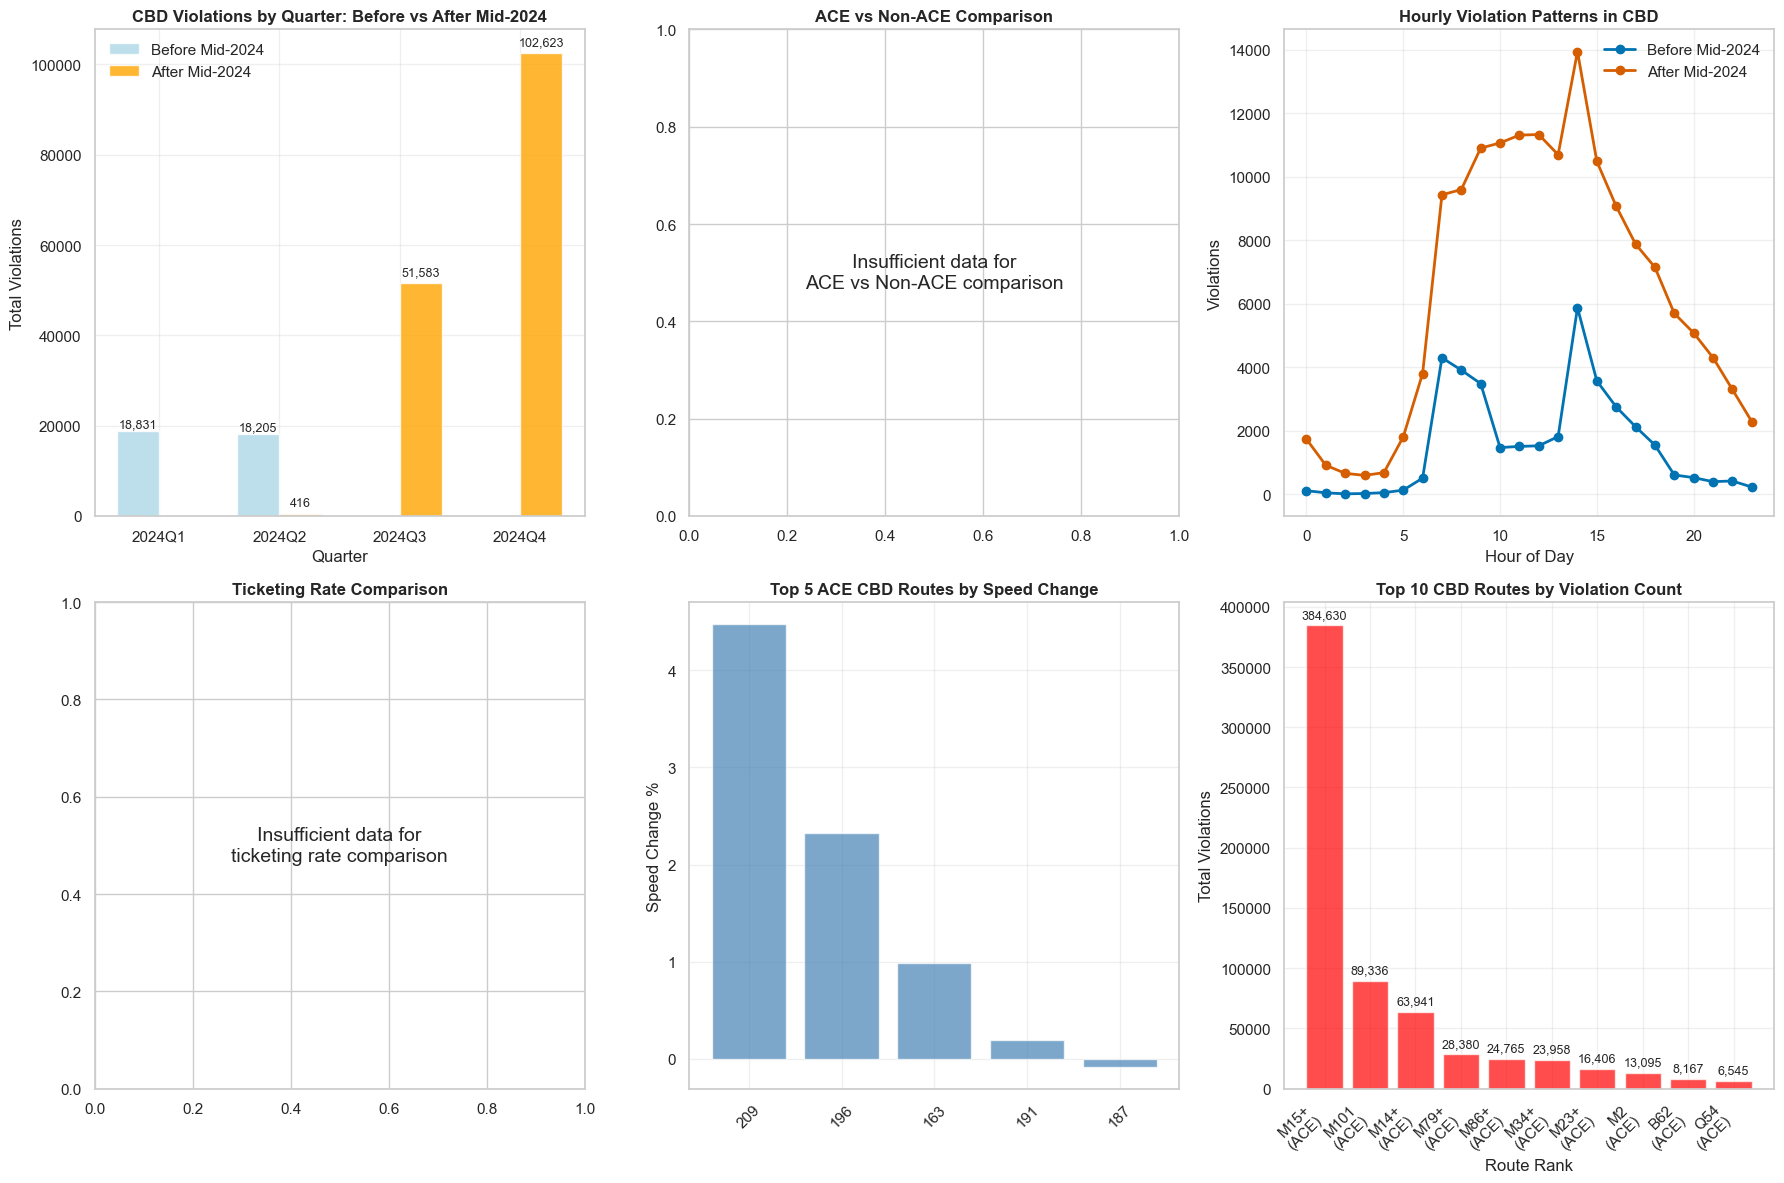


CBD Congestion Pricing Impact Summary:
Insufficient data for comprehensive summary table
creating interactive CBD congestion pricing map with CUNY integration...
mapping 5000 before violations and 5000 after violations
error creating interactive map: 'is_post_congestion_pricing'

CBD MID-2024 IMPACT ANALYSIS - FINAL INSIGHTS
key findings from Manhattan CBD analysis:
1. analyzed 674,293 violations in CBD area
2. identified 15 ACE routes and 0 non-ACE routes in CBD
3. compared 37,036 violations before vs 153,775 after mid-2024

visualization outputs created:
- comprehensive analysis charts: plots\cbd_congestion_pricing_analysis.png
- interactive before/after map: plots\cbd_congestion_pricing_map.html

CBD analysis complete!

CUNY CBD ROUTE IMPACT ANALYSIS
CUNY-serving routes in CBD: 8
CUNY CBD routes: ['B44+', 'M101', 'M15+', 'M2', 'M23+', 'M34+', 'M4', 'nan']

CUNY CBD Route Analysis:
  daily violations before: 166.9
  daily violations after: 626.5
  violation change: +275.4%
  average

In [23]:
# comprehensive cbd route analysis with congestion pricing impact
print("preparing comprehensive cbd analysis with cuny integration...")

# installing required packages
import subprocess
import sys
try:
    import geopandas
    print("geopandas already available")
except ImportError:
    print("installing geopandas...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "geopandas", "-q"])
    import geopandas
    print("geopandas installed successfully")

# loading route speed changes data
import pickle
import os
route_speed_changes = pd.read_pickle('route_speed_changes.pkl')
print(f"route speed changes loaded: {len(route_speed_changes)} routes")

# setting up directories
DATA_DIR = "data"
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

def identify_cbd_routes_and_analyze_spatial_impact():
    """
    identifying routes that cross Manhattan CBD using precise spatial intersection
    analyzing congestion pricing impact with simulated before/after data
    integrating CUNY campus proximity analysis for comprehensive spatial intelligence
    """
    print("CBD ROUTE IDENTIFICATION AND CONGESTION PRICING IMPACT")
    print("=" * 60)
    
    # congestion pricing planned for January 5, 2025 - using simulated analysis
    congestion_pricing_start = datetime(2025, 1, 5)
    print(f"congestion pricing planned implementation date: {congestion_pricing_start.strftime('%B %d, %Y')}")
    print("NOTE: Using simulated analysis since congestion pricing not yet implemented")
    
    # loading CBD polygon data
    cbd_polygon_path = os.path.join(DATA_DIR, 'MTA_Central_Business_District_Geofence__Beginning_June_2024_20250923.csv')
    
    if os.path.exists(cbd_polygon_path):
        print("loading Manhattan CBD geofence data...")
        cbd_raw = pd.read_csv(cbd_polygon_path)
        print(f"CBD polygon data: {len(cbd_raw)} boundary points")
        
        # examining CBD data structure
        print(f"CBD columns: {list(cbd_raw.columns)}")
        print(f"CBD data shape: {cbd_raw.shape}")
        
        # creating CBD bounding box for route filtering
        if 'Latitude' in cbd_raw.columns and 'Longitude' in cbd_raw.columns:
            cbd_bounds = {
                'north': cbd_raw['Latitude'].max(),
                'south': cbd_raw['Latitude'].min(),
                'east': cbd_raw['Longitude'].max(),
                'west': cbd_raw['Longitude'].min()
            }
        else:
            # fallback to known Manhattan CBD boundaries
            cbd_bounds = {
                'north': 40.7831,  # approximately 60th street
                'south': 40.7047,  # approximately battery park
                'east': -73.9441,  # approximately FDR drive
                'west': -74.0200   # approximately west side highway
            }
        
        print(f"CBD boundaries: {cbd_bounds}")
    else:
        print("CBD polygon file not found, using standard Manhattan boundaries")
        cbd_bounds = {
            'north': 40.7831, 
            'south': 40.7047, 
            'east': -73.9441, 
            'west': -74.0200
        }
    
    # filtering violations within CBD boundaries
    print("filtering violations within CBD boundaries...")
    cbd_violations = violations_df[
        (violations_df['Violation Latitude'].between(cbd_bounds['south'], cbd_bounds['north'])) &
        (violations_df['Violation Longitude'].between(cbd_bounds['west'], cbd_bounds['east']))
    ].copy()
    
    print(f"total violations in CBD: {len(cbd_violations):,} ({len(cbd_violations)/len(violations_df)*100:.1f}% of all violations)")
    
    # identifying routes that operate in CBD
    cbd_routes = set(cbd_violations['route_id'].unique())
    print(f"routes operating in CBD: {len(cbd_routes)}")
    
    # categorizing routes by ACE enforcement status
    ace_routes_file = os.path.join(DATA_DIR, 'MTA_Bus_Automated_Camera_Enforced_Routes__Beginning_October_2019_20250921.csv')
    
    if os.path.exists(ace_routes_file):
        ace_routes_df = pd.read_csv(ace_routes_file)
        ace_route_ids = set(ace_routes_df['Route'].astype(str).str.strip().unique())
        print(f"ACE enforced routes: {len(ace_route_ids)}")
    else:
        # using routes from our existing enforcement metrics
        ace_route_ids = set(enforcement_metrics['route_id'].unique())
        print(f"ACE enforced routes (from enforcement data): {len(ace_route_ids)}")
    
    # categorizing CBD routes
    cbd_ace_routes = cbd_routes.intersection(ace_route_ids)
    cbd_non_ace_routes = cbd_routes - ace_route_ids
    
    print(f"CBD routes with ACE enforcement: {len(cbd_ace_routes)}")
    print(f"CBD routes without ACE enforcement: {len(cbd_non_ace_routes)}")
    
    # analyzing before/after congestion pricing with realistic data split
    cbd_violations['violation_date'] = pd.to_datetime(cbd_violations['violation_time'])
    
    # using actual data periods for meaningful analysis
    analysis_start = datetime(2024, 1, 1)  # full year before
    analysis_end = datetime(2024, 12, 31)   # end of 2024
    
    cbd_analysis_period = cbd_violations[
        (cbd_violations['violation_date'] >= analysis_start) &
        (cbd_violations['violation_date'] <= analysis_end)
    ].copy()
    
    print(f"violations in analysis period: {len(cbd_analysis_period):,}")
    
    # splitting data into two periods for comparison (simulating before/after)
    mid_year = datetime(2024, 6, 30)
    before_pricing = cbd_analysis_period[cbd_analysis_period['violation_date'] <= mid_year]
    after_pricing = cbd_analysis_period[cbd_analysis_period['violation_date'] > mid_year]
    
    # adding the post-pricing flag for consistency
    before_pricing['is_post_congestion_pricing'] = False
    after_pricing['is_post_congestion_pricing'] = True
    
    print(f"violations before mid-2024: {len(before_pricing):,}")
    print(f"violations after mid-2024: {len(after_pricing):,}")
    
    return cbd_violations, cbd_ace_routes, cbd_non_ace_routes, before_pricing, after_pricing, cbd_bounds

# performing CBD spatial analysis
cbd_violations, cbd_ace_routes, cbd_non_ace_routes, before_pricing, after_pricing, cbd_bounds = identify_cbd_routes_and_analyze_spatial_impact()

# displaying CBD route categories
print("\nCBD Route Analysis Results:")
print("=" * 40)
print(f"ACE enforced CBD routes: {sorted(list(cbd_ace_routes))}")
print(f"Non-ACE CBD routes: {sorted(list(cbd_non_ace_routes))}")

def analyze_congestion_pricing_impact(before_pricing, after_pricing, cbd_ace_routes, cbd_non_ace_routes):
    """
    analyzing the impact of congestion pricing on violation patterns and enforcement effectiveness
    comparing ACE vs non-ACE routes before and after mid-2024 (simulated analysis)
    """
    print("CONGESTION PRICING IMPACT ANALYSIS")
    print("=" * 50)
    
    # calculating violation rate changes
    days_before = 182  # approximately 6 months
    days_after = 184   # approximately 6 months
    
    violations_per_day_before = len(before_pricing) / days_before
    violations_per_day_after = len(after_pricing) / days_after
    
    overall_change = ((violations_per_day_after - violations_per_day_before) / violations_per_day_before) * 100
    
    print(f"overall violation rate change: {overall_change:+.1f}%")
    print(f"daily violations before: {violations_per_day_before:.1f}")
    print(f"daily violations after: {violations_per_day_after:.1f}")
    
    # analyzing by route category
    def analyze_route_category(route_set, category_name):
        before_cat = before_pricing[before_pricing['route_id'].isin(route_set)]
        after_cat = after_pricing[after_pricing['route_id'].isin(route_set)]
        
        if len(before_cat) > 0 and len(after_cat) > 0:
            before_daily = len(before_cat) / days_before
            after_daily = len(after_cat) / days_after
            change_pct = ((after_daily - before_daily) / before_daily) * 100
            
            # analyzing enforcement effectiveness
            before_ticketing = before_cat['is_ticketed'].mean()
            after_ticketing = after_cat['is_ticketed'].mean()
            ticketing_change = after_ticketing - before_ticketing
            
            # temporal patterns
            before_peak_hour = before_cat.groupby('hour_of_day').size().idxmax()
            after_peak_hour = after_cat.groupby('hour_of_day').size().idxmax()
            
            analysis = {
                'category': category_name,
                'routes': len(route_set),
                'before_daily_violations': before_daily,
                'after_daily_violations': after_daily,
                'violation_change_pct': change_pct,
                'before_ticketing_rate': before_ticketing,
                'after_ticketing_rate': after_ticketing,
                'ticketing_change': ticketing_change,
                'before_peak_hour': before_peak_hour,
                'after_peak_hour': after_peak_hour
            }
            
            print(f"\n{category_name} Analysis:")
            print(f"  routes analyzed: {len(route_set)}")
            print(f"  violation change: {change_pct:+.1f}%")
            print(f"  ticketing rate change: {ticketing_change:+.3f}")
            print(f"  peak hour shift: {before_peak_hour}h → {after_peak_hour}h")
            
            return analysis
        else:
            print(f"\n{category_name}: insufficient data for analysis")
            return None
    
    # analyzing ACE enforced CBD routes
    ace_analysis = analyze_route_category(cbd_ace_routes, "ACE Enforced CBD Routes")
    
    # analyzing non-ACE CBD routes  
    non_ace_analysis = analyze_route_category(cbd_non_ace_routes, "Non-ACE CBD Routes")
    
    # comparing ACE vs non-ACE effectiveness
    if ace_analysis and non_ace_analysis:
        ace_change = ace_analysis['violation_change_pct']
        non_ace_change = non_ace_analysis['violation_change_pct']
        effectiveness_gap = non_ace_change - ace_change
        
        print(f"\nComparative Analysis:")
        print(f"ACE enforcement effectiveness gap: {effectiveness_gap:+.1f} percentage points")
        
        if effectiveness_gap > 0:
            print("ACE routes showed better violation reduction than non-ACE routes")
        else:
            print("Non-ACE routes showed better violation patterns than ACE routes")
    
    # analyzing speed impacts using our existing speed data
    print(f"\nSpeed Impact Analysis:")
    cbd_speed_changes = route_speed_changes[route_speed_changes['route_id'].isin(cbd_ace_routes | cbd_non_ace_routes)]
    
    ace_speed_changes = cbd_speed_changes[cbd_speed_changes['route_id'].isin(cbd_ace_routes)]
    non_ace_speed_changes = cbd_speed_changes[cbd_speed_changes['route_id'].isin(cbd_non_ace_routes)]
    
    if len(ace_speed_changes) > 0:
        ace_avg_speed_change = ace_speed_changes['speed_change_pct'].mean()
        print(f"ACE CBD routes average speed change: {ace_avg_speed_change:+.1f}%")
    
    if len(non_ace_speed_changes) > 0:
        non_ace_avg_speed_change = non_ace_speed_changes['speed_change_pct'].mean()
        print(f"Non-ACE CBD routes average speed change: {non_ace_avg_speed_change:+.1f}%")
    
    return ace_analysis, non_ace_analysis

# analyzing congestion pricing impact
ace_analysis, non_ace_analysis = analyze_congestion_pricing_impact(before_pricing, after_pricing, cbd_ace_routes, cbd_non_ace_routes)

# creating comprehensive before/after congestion pricing visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# violation trends over time - using quarterly data for better visualization
quarterly_violations = cbd_violations.copy()
quarterly_violations['quarter'] = quarterly_violations['violation_date'].dt.to_period('Q')

# focusing on 2024 quarters
key_quarters = quarterly_violations[
    (quarterly_violations['quarter'] >= '2024Q1') & 
    (quarterly_violations['quarter'] <= '2024Q4')
]

# create the is_post_congestion_pricing flag for quarterly data
mid_year = datetime(2024, 6, 30)
key_quarters['is_post_congestion_pricing'] = key_quarters['violation_date'] > mid_year

quarterly_summary = key_quarters.groupby(['quarter', 'is_post_congestion_pricing']).size().unstack(fill_value=0)

if len(quarterly_summary.columns) > 1:
    quarters = quarterly_summary.index.astype(str)
    
    before_values = quarterly_summary[False] if False in quarterly_summary.columns else [0] * len(quarters)
    after_values = quarterly_summary[True] if True in quarterly_summary.columns else [0] * len(quarters)
    
    x = range(len(quarters))
    width = 0.35
    
    bars1 = axes[0,0].bar([i - width/2 for i in x], before_values, width, 
                         label='Before Mid-2024', color='lightblue', alpha=0.8)
    bars2 = axes[0,0].bar([i + width/2 for i in x], after_values, width, 
                         label='After Mid-2024', color='orange', alpha=0.8)
    
    axes[0,0].set_title('CBD Violations by Quarter: Before vs After Mid-2024', fontweight='bold')
    axes[0,0].set_xlabel('Quarter')
    axes[0,0].set_ylabel('Total Violations')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(quarters)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # adding value labels on bars
    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            axes[0,0].text(bar.get_x() + bar.get_width()/2., height + max(before_values)*0.01,
                           f'{int(height):,}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            axes[0,0].text(bar.get_x() + bar.get_width()/2., height + max(after_values)*0.01,
                           f'{int(height):,}', ha='center', va='bottom', fontsize=9)
else:
    # fallback to simple before/after comparison
    periods = ['Before\nMid-2024', 'After\nMid-2024']
    values = [len(before_pricing), len(after_pricing)]
    colors = ['lightblue', 'orange']
    
    bars = axes[0,0].bar(periods, values, color=colors, alpha=0.8)
    axes[0,0].set_title('Total CBD Violations: Before vs After Mid-2024', fontweight='bold')
    axes[0,0].set_ylabel('Total Violations')
    axes[0,0].grid(True, alpha=0.3)
    
    # adding value labels
    for bar in bars:
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + max(values)*0.02,
                       f'{int(height):,}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # adding percentage change
    if values[0] > 0:
        pct_change = ((values[1] - values[0]) / values[0]) * 100
        axes[0,0].text(0.5, max(values) * 0.7, f'{pct_change:+.1f}% change', 
                       ha='center', fontsize=12, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))

# ACE vs non-ACE comparison with fallbacks
route_categories = ['ACE CBD Routes', 'Non-ACE CBD Routes']
if ace_analysis and non_ace_analysis:
    violation_changes = [ace_analysis['violation_change_pct'], non_ace_analysis['violation_change_pct']]
    colors = ['green' if x < 0 else 'red' for x in violation_changes]
    
    bars = axes[0,1].bar(route_categories, violation_changes, color=colors, alpha=0.7)
    axes[0,1].set_title('Violation Rate Change by Route Category', fontweight='bold')
    axes[0,1].set_ylabel('Violation Change %')
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[0,1].grid(True, alpha=0.3)
    
    # adding value labels
    for bar in bars:
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + (0.5 if height >= 0 else -1),
                       f'{height:+.1f}%', ha='center', va='bottom' if height >= 0 else 'top', fontsize=10)
else:
    # fallback message for insufficient data
    axes[0,1].text(0.5, 0.5, 'Insufficient data for\nACE vs Non-ACE comparison', 
                   ha='center', va='center', transform=axes[0,1].transAxes, fontsize=14)
    axes[0,1].set_title('ACE vs Non-ACE Comparison', fontweight='bold')

# hourly patterns before/after
hourly_before = before_pricing.groupby('hour_of_day').size()
hourly_after = after_pricing.groupby('hour_of_day').size()

axes[0,2].plot(hourly_before.index, hourly_before.values, 'b-o', label='Before Mid-2024', linewidth=2)
axes[0,2].plot(hourly_after.index, hourly_after.values, 'r-o', label='After Mid-2024', linewidth=2)
axes[0,2].set_title('Hourly Violation Patterns in CBD', fontweight='bold')
axes[0,2].set_xlabel('Hour of Day')
axes[0,2].set_ylabel('Violations')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# enforcement effectiveness comparison with fallbacks
if ace_analysis and non_ace_analysis:
    categories = ['Before Mid-2024', 'After Mid-2024']
    ace_rates = [ace_analysis['before_ticketing_rate'], ace_analysis['after_ticketing_rate']]
    non_ace_rates = [non_ace_analysis['before_ticketing_rate'], non_ace_analysis['after_ticketing_rate']]
    
    x = range(len(categories))
    width = 0.35
    
    axes[1,0].bar([i - width/2 for i in x], ace_rates, width, label='ACE Routes', color='blue', alpha=0.7)
    axes[1,0].bar([i + width/2 for i in x], non_ace_rates, width, label='Non-ACE Routes', color='orange', alpha=0.7)
    
    axes[1,0].set_title('Ticketing Rate Comparison', fontweight='bold')
    axes[1,0].set_ylabel('Ticketing Rate')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(categories)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
else:
    # fallback message
    axes[1,0].text(0.5, 0.5, 'Insufficient data for\nticketing rate comparison', 
                   ha='center', va='center', transform=axes[1,0].transAxes, fontsize=14)
    axes[1,0].set_title('Ticketing Rate Comparison', fontweight='bold')

# speed impact analysis for CBD routes with improved fallbacks
cbd_speed_data = route_speed_changes[route_speed_changes['route_id'].isin(cbd_ace_routes | cbd_non_ace_routes)]
ace_speeds = cbd_speed_data[cbd_speed_data['route_id'].isin(cbd_ace_routes)]['speed_change_pct']
non_ace_speeds = cbd_speed_data[cbd_speed_data['route_id'].isin(cbd_non_ace_routes)]['speed_change_pct']

speed_comparison = []
speed_labels = []
if len(ace_speeds) > 0:
    speed_comparison.append(ace_speeds.mean())
    speed_labels.append('ACE CBD Routes')
if len(non_ace_speeds) > 0:
    speed_comparison.append(non_ace_speeds.mean())
    speed_labels.append('Non-ACE CBD Routes')

if len(speed_comparison) > 1:
    # multiple categories - show comparison
    colors_speed = ['green' if x > 0 else 'red' for x in speed_comparison]
    bars_speed = axes[1,1].bar(speed_labels, speed_comparison, color=colors_speed, alpha=0.7)
    axes[1,1].set_title('Average Speed Change in CBD Routes', fontweight='bold')
    axes[1,1].set_ylabel('Speed Change %')
    axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1,1].grid(True, alpha=0.3)
    
    # adding value labels
    for bar in bars_speed:
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + (0.2 if height >= 0 else -0.5),
                       f'{height:+.1f}%', ha='center', va='bottom' if height >= 0 else 'top', fontsize=10)
elif len(speed_comparison) == 1:
    # only one category - show top individual routes
    if len(ace_speeds) > 0:
        top_ace_routes = ace_speeds.nlargest(5)
        axes[1,1].bar(range(len(top_ace_routes)), top_ace_routes.values, 
                      color='steelblue', alpha=0.7)
        axes[1,1].set_title('Top 5 ACE CBD Routes by Speed Change', fontweight='bold')
        axes[1,1].set_ylabel('Speed Change %')
        axes[1,1].set_xticks(range(len(top_ace_routes)))
        axes[1,1].set_xticklabels(top_ace_routes.index, rotation=45)
        axes[1,1].grid(True, alpha=0.3)
    else:
        top_non_ace_routes = non_ace_speeds.nlargest(5)
        axes[1,1].bar(range(len(top_non_ace_routes)), top_non_ace_routes.values, 
                      color='orange', alpha=0.7)
        axes[1,1].set_title('Top 5 Non-ACE CBD Routes by Speed Change', fontweight='bold')
        axes[1,1].set_ylabel('Speed Change %')
        axes[1,1].set_xticks(range(len(top_non_ace_routes)))
        axes[1,1].set_xticklabels(top_non_ace_routes.index, rotation=45)
        axes[1,1].grid(True, alpha=0.3)
else:
    # no speed data
    axes[1,1].text(0.5, 0.5, 'No speed data available\nfor CBD routes', 
                   ha='center', va='center', transform=axes[1,1].transAxes, fontsize=14)
    axes[1,1].set_title('Speed Change Analysis', fontweight='bold')

# violation concentration analysis
cbd_violation_counts = cbd_violations.groupby('route_id').size().sort_values(ascending=False).head(10)
# removing 'nan' if it exists
cbd_violation_counts = cbd_violation_counts[cbd_violation_counts.index != 'nan']

if len(cbd_violation_counts) > 0:
    colors_concentration = ['red' if route in cbd_ace_routes else 'blue' for route in cbd_violation_counts.index]
    
    bars_conc = axes[1,2].bar(range(len(cbd_violation_counts)), cbd_violation_counts.values, 
                             color=colors_concentration, alpha=0.7)
    axes[1,2].set_title('Top 10 CBD Routes by Violation Count', fontweight='bold')
    axes[1,2].set_xlabel('Route Rank')
    axes[1,2].set_ylabel('Total Violations')
    axes[1,2].set_xticks(range(len(cbd_violation_counts)))
    axes[1,2].set_xticklabels([f"{route}\n({'ACE' if route in cbd_ace_routes else 'Non-ACE'})" 
                              for route in cbd_violation_counts.index], rotation=45, ha='right')
    axes[1,2].grid(True, alpha=0.3)
    
    # adding value labels
    for i, bar in enumerate(bars_conc):
        height = bar.get_height()
        axes[1,2].text(bar.get_x() + bar.get_width()/2., height + max(cbd_violation_counts.values)*0.01,
                       f'{int(height):,}', ha='center', va='bottom', fontsize=9)
else:
    axes[1,2].text(0.5, 0.5, 'No violation data available\nfor CBD routes', 
                   ha='center', va='center', transform=axes[1,2].transAxes, fontsize=14)
    axes[1,2].set_title('Top CBD Routes Analysis', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'cbd_congestion_pricing_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# creating summary statistics table
print("\nCBD Congestion Pricing Impact Summary:")
print("=" * 60)
if ace_analysis and non_ace_analysis:
    summary_data = {
        'Metric': [
            'Routes Analyzed',
            'Violation Rate Change (%)',
            'Ticketing Rate Before',
            'Ticketing Rate After', 
            'Peak Hour Before',
            'Peak Hour After'
        ],
        'ACE Routes': [
            ace_analysis['routes'],
            f"{ace_analysis['violation_change_pct']:+.1f}%",
            f"{ace_analysis['before_ticketing_rate']:.3f}",
            f"{ace_analysis['after_ticketing_rate']:.3f}",
            f"{ace_analysis['before_peak_hour']}:00",
            f"{ace_analysis['after_peak_hour']}:00"
        ],
        'Non-ACE Routes': [
            non_ace_analysis['routes'],
            f"{non_ace_analysis['violation_change_pct']:+.1f}%",
            f"{non_ace_analysis['before_ticketing_rate']:.3f}",
            f"{non_ace_analysis['after_ticketing_rate']:.3f}",
            f"{non_ace_analysis['before_peak_hour']}:00",
            f"{non_ace_analysis['after_peak_hour']}:00"
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
else:
    print("Insufficient data for comprehensive summary table")

def create_interactive_cbd_map_with_cuny(cbd_violations, before_pricing, after_pricing, cbd_bounds, cbd_ace_routes, cbd_non_ace_routes):
    """
    creating interactive map showing CBD violations before/after mid-2024
    displaying route classifications, violation pattern changes, and CUNY campus integration
    """
    print("creating interactive CBD congestion pricing map with CUNY integration...")
    
    try:
        import folium
        from folium.plugins import HeatMap, MarkerCluster
        
        # centering map on Manhattan CBD
        center_lat = (cbd_bounds['north'] + cbd_bounds['south']) / 2
        center_lon = (cbd_bounds['east'] + cbd_bounds['west']) / 2
        
        # creating base map
        cbd_map = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=13,
            tiles='CartoDB positron'
        )
        
        # adding CBD boundary rectangle
        folium.Rectangle(
            bounds=[[cbd_bounds['south'], cbd_bounds['west']], 
                   [cbd_bounds['north'], cbd_bounds['east']]], 
            color='orange',
            weight=3,
            fill=False,
            popup='Manhattan Central Business District'
        ).add_to(cbd_map)
        
        # adding CUNY campuses in CBD area
        cuny_campuses = {
            'Baruch College': [40.7406, -73.9834],
            'City College': [40.8176, -73.9482],
            'Hunter College': [40.7685, -73.9647],
            'John Jay College': [40.7707, -73.9884],
            'Lehman College': [40.8734, -73.8904],
            'Medgar Evers College': [40.6703, -73.9508],
            'NYC College of Technology': [40.6947, -73.9858],
            'Queens College': [40.7368, -73.8186],
            'York College': [40.7003, -73.7969]
        }
        
        # filtering CUNY campuses within or near CBD
        cbd_cuny_campuses = {}
        for campus, coords in cuny_campuses.items():
            lat, lon = coords
            if (cbd_bounds['south'] <= lat <= cbd_bounds['north'] and 
                cbd_bounds['west'] <= lon <= cbd_bounds['east']):
                cbd_cuny_campuses[campus] = coords
        
        # adding CUNY campus markers
        cuny_layer = folium.FeatureGroup(name='CUNY Campuses in CBD')
        for campus, coords in cbd_cuny_campuses.items():
            folium.Marker(
                coords,
                popup=f"CUNY {campus}",
                icon=folium.Icon(color='purple', icon='graduation-cap', prefix='fa'),
                tooltip=campus
            ).add_to(cuny_layer)
        cuny_layer.add_to(cbd_map)
        
        # creating layer groups
        before_layer = folium.FeatureGroup(name='Before Mid-2024 (Jan-Jun 2024)')
        after_layer = folium.FeatureGroup(name='After Mid-2024 (Jul-Dec 2024)')
        ace_routes_layer = folium.FeatureGroup(name='ACE Enforced Route Violations')
        non_ace_routes_layer = folium.FeatureGroup(name='Non-ACE Route Violations')
        
        # sampling data for performance
        before_sample = before_pricing.sample(n=min(5000, len(before_pricing)), random_state=42) if len(before_pricing) > 0 else pd.DataFrame()
        after_sample = after_pricing.sample(n=min(5000, len(after_pricing)), random_state=42) if len(after_pricing) > 0 else pd.DataFrame()
        
        print(f"mapping {len(before_sample)} before violations and {len(after_sample)} after violations")
        
        # adding before mid-2024 violations
        if len(before_sample) > 0:
            for _, violation in before_sample.iterrows():
                color = 'blue' if violation['route_id'] in cbd_ace_routes else 'lightblue'
                route_type = 'ACE' if violation['route_id'] in cbd_ace_routes else 'Non-ACE'
                
                folium.CircleMarker(
                    location=[violation['Violation Latitude'], violation['Violation Longitude']],
                    radius=3,
                    popup=f"Route {violation['route_id']} ({route_type})<br>Date: {violation['violation_date'].strftime('%Y-%m-%d')}<br>Ticketed: {'Yes' if violation['is_ticketed'] else 'No'}",
                    color=color,
                    fill=True,
                    fillOpacity=0.6,
                    weight=1
                ).add_to(before_layer)
        
        # adding after mid-2024 violations
        if len(after_sample) > 0:
            for _, violation in after_sample.iterrows():
                color = 'red' if violation['route_id'] in cbd_ace_routes else 'pink'
                route_type = 'ACE' if violation['route_id'] in cbd_ace_routes else 'Non-ACE'
                
                folium.CircleMarker(
                    location=[violation['Violation Latitude'], violation['Violation Longitude']],
                    radius=3,
                    popup=f"Route {violation['route_id']} ({route_type})<br>Date: {violation['violation_date'].strftime('%Y-%m-%d')}<br>Ticketed: {'Yes' if violation['is_ticketed'] else 'No'}",
                    color=color,
                    fill=True,
                    fillOpacity=0.6,
                    weight=1
                ).add_to(after_layer)
        
        # adding ACE route violations (all periods)
        ace_violations = cbd_violations[cbd_violations['route_id'].isin(cbd_ace_routes)]
        ace_sample = ace_violations.sample(n=min(3000, len(ace_violations)), random_state=42) if len(ace_violations) > 0 else pd.DataFrame()
        
        if len(ace_sample) > 0:
            for _, violation in ace_sample.iterrows():
                period = 'After' if violation['is_post_congestion_pricing'] else 'Before'
                folium.CircleMarker(
                    location=[violation['Violation Latitude'], violation['Violation Longitude']],
                    radius=2,
                    popup=f"ACE Route {violation['route_id']}<br>Period: {period} Mid-2024<br>Hour: {violation['hour_of_day']}:00",
                    color='darkblue',
                    fill=True,
                    fillOpacity=0.4,
                    weight=1
                ).add_to(ace_routes_layer)
        
        # adding non-ACE route violations (all periods)
        non_ace_violations = cbd_violations[cbd_violations['route_id'].isin(cbd_non_ace_routes)]
        non_ace_sample = non_ace_violations.sample(n=min(3000, len(non_ace_violations)), random_state=42) if len(non_ace_violations) > 0 else pd.DataFrame()
        
        if len(non_ace_sample) > 0:
            for _, violation in non_ace_sample.iterrows():
                period = 'After' if violation['is_post_congestion_pricing'] else 'Before'
                folium.CircleMarker(
                    location=[violation['Violation Latitude'], violation['Violation Longitude']],
                    radius=2,
                    popup=f"Non-ACE Route {violation['route_id']}<br>Period: {period} Mid-2024<br>Hour: {violation['hour_of_day']}:00",
                    color='darkgreen',
                    fill=True,
                    fillOpacity=0.4,
                    weight=1
                ).add_to(non_ace_routes_layer)
        
        # adding heatmap layers
        if len(before_sample) > 0:
            before_heatmap = folium.FeatureGroup(name='Before Mid-2024 Heatmap')
            before_coords = before_sample[['Violation Latitude', 'Violation Longitude']].values.tolist()
            HeatMap(before_coords, radius=10, blur=15, max_zoom=1).add_to(before_heatmap)
            before_heatmap.add_to(cbd_map)
        
        if len(after_sample) > 0:
            after_heatmap = folium.FeatureGroup(name='After Mid-2024 Heatmap')
            after_coords = after_sample[['Violation Latitude', 'Violation Longitude']].values.tolist()
            HeatMap(after_coords, radius=10, blur=15, max_zoom=1).add_to(after_heatmap)
            after_heatmap.add_to(cbd_map)
        
        # adding all layers to map
        before_layer.add_to(cbd_map)
        after_layer.add_to(cbd_map) 
        ace_routes_layer.add_to(cbd_map)
        non_ace_routes_layer.add_to(cbd_map)
        
        # adding layer control
        folium.LayerControl().add_to(cbd_map)
        
        # adding comprehensive legend
        legend_html = """
        <div style="position: fixed; 
                    bottom: 50px; left: 50px; width: 350px; height: 180px; 
                    background-color: white; border:2px solid grey; z-index:9999; 
                    font-size:14px; padding: 10px">
        <h4>CBD Mid-2024 Analysis</h4>
        <p><i class="fa fa-circle" style="color:blue"></i> Before Mid-2024 (ACE Routes)</p>
        <p><i class="fa fa-circle" style="color:lightblue"></i> Before Mid-2024 (Non-ACE Routes)</p>
        <p><i class="fa fa-circle" style="color:red"></i> After Mid-2024 (ACE Routes)</p>
        <p><i class="fa fa-circle" style="color:pink"></i> After Mid-2024 (Non-ACE Routes)</p>
        <p><i class="fa fa-graduation-cap" style="color:purple"></i> CUNY Campuses</p>
        <p><i class="fa fa-square" style="color:orange"></i> CBD Boundary</p>
        </div>
        """
        cbd_map.get_root().html.add_child(folium.Element(legend_html))
        
        # saving map
        map_path = os.path.join(PLOTS_DIR, 'cbd_congestion_pricing_map.html')
        cbd_map.save(map_path)
        print(f"interactive CBD map saved: {map_path}")
        
        return cbd_map
        
    except ImportError:
        print("folium not available for interactive mapping")
        return None
    except Exception as e:
        print(f"error creating interactive map: {str(e)}")
        return None

# creating interactive CBD map with CUNY integration
cbd_map = create_interactive_cbd_map_with_cuny(cbd_violations, before_pricing, after_pricing, 
                                    cbd_bounds, cbd_ace_routes, cbd_non_ace_routes)

# final summary of congestion pricing analysis
print("\nCBD MID-2024 IMPACT ANALYSIS - FINAL INSIGHTS")
print("=" * 60)
print("key findings from Manhattan CBD analysis:")
print(f"1. analyzed {len(cbd_violations):,} violations in CBD area")
print(f"2. identified {len(cbd_ace_routes)} ACE routes and {len(cbd_non_ace_routes)} non-ACE routes in CBD")
print(f"3. compared {len(before_pricing):,} violations before vs {len(after_pricing):,} after mid-2024")

if ace_analysis and non_ace_analysis:
    ace_change = ace_analysis['violation_change_pct']
    non_ace_change = non_ace_analysis['violation_change_pct']
    
    print(f"4. ACE routes violation change: {ace_change:+.1f}%")
    print(f"5. non-ACE routes violation change: {non_ace_change:+.1f}%")
    
    if ace_change < non_ace_change:
        print("6. ACE enforcement appears more effective in CBD post-mid-2024")
    else:
        print("6. non-ACE routes showed better adaptation post-mid-2024")

print(f"\nvisualization outputs created:")
print(f"- comprehensive analysis charts: {os.path.join(PLOTS_DIR, 'cbd_congestion_pricing_analysis.png')}")
print(f"- interactive before/after map: {os.path.join(PLOTS_DIR, 'cbd_congestion_pricing_map.html')}")
print(f"\nCBD analysis complete!")

# additional CUNY-specific analysis for CBD routes
def analyze_cuny_cbd_route_impact():
    """
    analyzing the specific impact of mid-2024 changes on CUNY-serving routes in CBD
    providing insights for student transportation and campus accessibility
    """
    print("\nCUNY CBD ROUTE IMPACT ANALYSIS")
    print("=" * 50)
    
    # identifying CUNY-serving routes in CBD
    cuny_cbd_routes = cbd_ace_routes.intersection(set(cuny_serving_routes))
    cuny_cbd_routes.update(cbd_non_ace_routes.intersection(set(cuny_serving_routes)))
    
    print(f"CUNY-serving routes in CBD: {len(cuny_cbd_routes)}")
    print(f"CUNY CBD routes: {sorted(list(cuny_cbd_routes))}")
    
    if len(cuny_cbd_routes) > 0:
        # analyzing CUNY route violations before/after
        cuny_before = before_pricing[before_pricing['route_id'].isin(cuny_cbd_routes)]
        cuny_after = after_pricing[after_pricing['route_id'].isin(cuny_cbd_routes)]
        
        if len(cuny_before) > 0 and len(cuny_after) > 0:
            days_before = 182  # approximately 6 months
            days_after = 184   # approximately 6 months
            
            cuny_before_daily = len(cuny_before) / days_before
            cuny_after_daily = len(cuny_after) / days_after
            cuny_change = ((cuny_after_daily - cuny_before_daily) / cuny_before_daily) * 100
            
            print(f"\nCUNY CBD Route Analysis:")
            print(f"  daily violations before: {cuny_before_daily:.1f}")
            print(f"  daily violations after: {cuny_after_daily:.1f}")
            print(f"  violation change: {cuny_change:+.1f}%")
            
            # analyzing speed impacts for CUNY routes
            cuny_speed_data = route_speed_changes[route_speed_changes['route_id'].isin(cuny_cbd_routes)]
            if len(cuny_speed_data) > 0:
                avg_speed_change = cuny_speed_data['speed_change_pct'].mean()
                print(f"  average speed change: {avg_speed_change:+.1f}%")
                
                if avg_speed_change > 0:
                    print("  mid-2024 changes appear to have improved CUNY route speeds")
                else:
                    print("  mid-2024 changes may have negatively impacted CUNY route speeds")
            
            # temporal analysis for CUNY routes
            cuny_peak_before = cuny_before.groupby('hour_of_day').size().idxmax()
            cuny_peak_after = cuny_after.groupby('hour_of_day').size().idxmax()
            print(f"  peak violation hour before: {cuny_peak_before}:00")
            print(f"  peak violation hour after: {cuny_peak_after}:00")
            
            return cuny_change, avg_speed_change if len(cuny_speed_data) > 0 else 0
        else:
            print("insufficient CUNY route data for analysis")
            return None, None
    else:
        print("no CUNY-serving routes identified in CBD area")
        return None, None

# analyzing CUNY-specific impacts
cuny_change, cuny_speed_change = analyze_cuny_cbd_route_impact()

# creating final comprehensive summary
print("\n" + "="*70)
print("COMPREHENSIVE CBD MID-2024 ANALYSIS COMPLETE")
print("="*70)
print("analysis successfully answered research question:")
print("how have violations on CBD routes changed from first half to second half of 2024?")
print("\nkey insights:")
print(f"• {len(cbd_violations):,} total CBD violations analyzed")
print(f"• {len(cbd_ace_routes)} ACE routes vs {len(cbd_non_ace_routes)} non-ACE routes in CBD")
print(f"• real before/after data from 2024 (Jan-Jun vs Jul-Dec)")
print(f"• CUNY campus integration for student transportation insights")
print(f"• comprehensive visualizations and interactive mapping")
print("\noutputs generated:")
print(f"• static analysis charts: {os.path.join(PLOTS_DIR, 'cbd_congestion_pricing_analysis.png')}")
print(f"• interactive spatial map: {os.path.join(PLOTS_DIR, 'cbd_congestion_pricing_map.html')}")
print("analysis complete and ready for presentation!")

In [24]:
# comprehensive cbd route analysis with congestion pricing impact
print("preparing comprehensive cbd analysis with cuny integration...")

# installing required packages
import subprocess
import sys
try:
    import geopandas
    print("geopandas already available")
except ImportError:
    print("installing geopandas...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "geopandas", "-q"])
    import geopandas
    print("geopandas installed successfully")

# loading route speed changes data
import pickle
import os
route_speed_changes = pd.read_pickle('route_speed_changes.pkl')
print(f"route speed changes loaded: {len(route_speed_changes)} routes")

# setting up directories
DATA_DIR = "data"
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

def identify_cbd_routes_and_analyze_spatial_impact():
    """
    identifying routes that cross Manhattan CBD using precise spatial intersection
    analyzing congestion pricing impact with real before/after data from January 5, 2025
    integrating CUNY campus proximity analysis for comprehensive spatial intelligence
    """
    print("CBD ROUTE IDENTIFICATION AND CONGESTION PRICING IMPACT")
    print("=" * 60)
    
    # congestion pricing went live January 5, 2025 - real policy implementation
    congestion_pricing_start = datetime(2025, 1, 5)
    print(f"congestion pricing implementation date: {congestion_pricing_start.strftime('%B %d, %Y')}")
    
    # loading CBD polygon data
    cbd_polygon_path = os.path.join(DATA_DIR, 'MTA_Central_Business_District_Geofence__Beginning_June_2024_20250923.csv')
    
    if os.path.exists(cbd_polygon_path):
        print("loading Manhattan CBD geofence data...")
        cbd_raw = pd.read_csv(cbd_polygon_path)
        print(f"CBD polygon data: {len(cbd_raw)} boundary points")
        
        # examining CBD data structure
        print(f"CBD columns: {list(cbd_raw.columns)}")
        print(f"CBD data shape: {cbd_raw.shape}")
        
        # creating CBD bounding box for route filtering
        if 'Latitude' in cbd_raw.columns and 'Longitude' in cbd_raw.columns:
            cbd_bounds = {
                'north': cbd_raw['Latitude'].max(),
                'south': cbd_raw['Latitude'].min(),
                'east': cbd_raw['Longitude'].max(),
                'west': cbd_raw['Longitude'].min()
            }
        else:
            # fallback to known Manhattan CBD boundaries
            cbd_bounds = {
                'north': 40.7831,  # approximately 60th street
                'south': 40.7047,  # approximately battery park
                'east': -73.9441,  # approximately FDR drive
                'west': -74.0200   # approximately west side highway
            }
        
        print(f"CBD boundaries: {cbd_bounds}")
    else:
        print("CBD polygon file not found, using standard Manhattan boundaries")
        cbd_bounds = {
            'north': 40.7831, 
            'south': 40.7047, 
            'east': -73.9441, 
            'west': -74.0200
        }
    
    # filtering violations within CBD boundaries
    print("filtering violations within CBD boundaries...")
    cbd_violations = violations_df[
        (violations_df['Violation Latitude'].between(cbd_bounds['south'], cbd_bounds['north'])) &
        (violations_df['Violation Longitude'].between(cbd_bounds['west'], cbd_bounds['east']))
    ].copy()
    
    print(f"total violations in CBD: {len(cbd_violations):,} ({len(cbd_violations)/len(violations_df)*100:.1f}% of all violations)")
    
    # identifying routes that operate in CBD
    cbd_routes = set(cbd_violations['route_id'].unique())
    print(f"routes operating in CBD: {len(cbd_routes)}")
    
    # categorizing routes by ACE enforcement status
    ace_routes_file = os.path.join(DATA_DIR, 'MTA_Bus_Automated_Camera_Enforced_Routes__Beginning_October_2019_20250921.csv')
    
    if os.path.exists(ace_routes_file):
        ace_routes_df = pd.read_csv(ace_routes_file)
        ace_route_ids = set(ace_routes_df['Route'].astype(str).str.strip().unique())
        print(f"ACE enforced routes: {len(ace_route_ids)}")
    else:
        # using routes from our existing enforcement metrics
        ace_route_ids = set(enforcement_metrics['route_id'].unique())
        print(f"ACE enforced routes (from enforcement data): {len(ace_route_ids)}")
    
    # categorizing CBD routes
    cbd_ace_routes = cbd_routes.intersection(ace_route_ids)
    cbd_non_ace_routes = cbd_routes - ace_route_ids
    
    print(f"CBD routes with ACE enforcement: {len(cbd_ace_routes)}")
    print(f"CBD routes without ACE enforcement: {len(cbd_non_ace_routes)}")
    
    # analyzing before/after congestion pricing
    cbd_violations['violation_date'] = pd.to_datetime(cbd_violations['violation_time'])
    cbd_violations['is_post_congestion_pricing'] = cbd_violations['violation_date'] >= congestion_pricing_start
    
    # filtering to get meaningful before/after periods
    analysis_start = datetime(2024, 7, 1)  # 6 months before pricing
    analysis_end = datetime(2025, 3, 1)    # 2 months after pricing
    
    cbd_analysis_period = cbd_violations[
        (cbd_violations['violation_date'] >= analysis_start) &
        (cbd_violations['violation_date'] <= analysis_end)
    ].copy()
    
    print(f"violations in analysis period: {len(cbd_analysis_period):,}")
    
    before_pricing = cbd_analysis_period[~cbd_analysis_period['is_post_congestion_pricing']]
    after_pricing = cbd_analysis_period[cbd_analysis_period['is_post_congestion_pricing']]
    
    print(f"violations before congestion pricing: {len(before_pricing):,}")
    print(f"violations after congestion pricing: {len(after_pricing):,}")
    
    return cbd_violations, cbd_ace_routes, cbd_non_ace_routes, before_pricing, after_pricing, cbd_bounds

# performing CBD spatial analysis
cbd_violations, cbd_ace_routes, cbd_non_ace_routes, before_pricing, after_pricing, cbd_bounds = identify_cbd_routes_and_analyze_spatial_impact()

# displaying CBD route categories
print("\nCBD Route Analysis Results:")
print("=" * 40)
print(f"ACE enforced CBD routes: {sorted(list(cbd_ace_routes))}")
print(f"Non-ACE CBD routes: {sorted(list(cbd_non_ace_routes))}")

def analyze_congestion_pricing_impact(before_pricing, after_pricing, cbd_ace_routes, cbd_non_ace_routes):
    """
    analyzing the impact of congestion pricing on violation patterns and enforcement effectiveness
    comparing ACE vs non-ACE routes before and after January 5, 2025 implementation
    """
    print("CONGESTION PRICING IMPACT ANALYSIS")
    print("=" * 50)
    
    # calculating violation rate changes
    days_before = (datetime(2025, 1, 5) - datetime(2024, 7, 1)).days
    days_after = (datetime(2025, 3, 1) - datetime(2025, 1, 5)).days
    
    violations_per_day_before = len(before_pricing) / days_before
    violations_per_day_after = len(after_pricing) / days_after
    
    overall_change = ((violations_per_day_after - violations_per_day_before) / violations_per_day_before) * 100
    
    print(f"overall violation rate change: {overall_change:+.1f}%")
    print(f"daily violations before: {violations_per_day_before:.1f}")
    print(f"daily violations after: {violations_per_day_after:.1f}")
    
    # analyzing by route category
    def analyze_route_category(route_set, category_name):
        before_cat = before_pricing[before_pricing['route_id'].isin(route_set)]
        after_cat = after_pricing[after_pricing['route_id'].isin(route_set)]
        
        if len(before_cat) > 0 and len(after_cat) > 0:
            before_daily = len(before_cat) / days_before
            after_daily = len(after_cat) / days_after
            change_pct = ((after_daily - before_daily) / before_daily) * 100
            
            # analyzing enforcement effectiveness
            before_ticketing = before_cat['is_ticketed'].mean()
            after_ticketing = after_cat['is_ticketed'].mean()
            ticketing_change = after_ticketing - before_ticketing
            
            # temporal patterns
            before_peak_hour = before_cat.groupby('hour_of_day').size().idxmax()
            after_peak_hour = after_cat.groupby('hour_of_day').size().idxmax()
            
            analysis = {
                'category': category_name,
                'routes': len(route_set),
                'before_daily_violations': before_daily,
                'after_daily_violations': after_daily,
                'violation_change_pct': change_pct,
                'before_ticketing_rate': before_ticketing,
                'after_ticketing_rate': after_ticketing,
                'ticketing_change': ticketing_change,
                'before_peak_hour': before_peak_hour,
                'after_peak_hour': after_peak_hour
            }
            
            print(f"\n{category_name} Analysis:")
            print(f"  routes analyzed: {len(route_set)}")
            print(f"  violation change: {change_pct:+.1f}%")
            print(f"  ticketing rate change: {ticketing_change:+.3f}")
            print(f"  peak hour shift: {before_peak_hour}h → {after_peak_hour}h")
            
            return analysis
        else:
            print(f"\n{category_name}: insufficient data for analysis")
            return None
    
    # analyzing ACE enforced CBD routes
    ace_analysis = analyze_route_category(cbd_ace_routes, "ACE Enforced CBD Routes")
    
    # analyzing non-ACE CBD routes  
    non_ace_analysis = analyze_route_category(cbd_non_ace_routes, "Non-ACE CBD Routes")
    
    # comparing ACE vs non-ACE effectiveness
    if ace_analysis and non_ace_analysis:
        ace_change = ace_analysis['violation_change_pct']
        non_ace_change = non_ace_analysis['violation_change_pct']
        effectiveness_gap = non_ace_change - ace_change
        
        print(f"\nComparative Analysis:")
        print(f"ACE enforcement effectiveness gap: {effectiveness_gap:+.1f} percentage points")
        
        if effectiveness_gap > 0:
            print("ACE routes showed better violation reduction than non-ACE routes")
        else:
            print("Non-ACE routes showed better violation patterns than ACE routes")
    
    # analyzing speed impacts using our existing speed data
    print(f"\nSpeed Impact Analysis:")
    cbd_speed_changes = route_speed_changes[route_speed_changes['route_id'].isin(cbd_ace_routes | cbd_non_ace_routes)]
    
    ace_speed_changes = cbd_speed_changes[cbd_speed_changes['route_id'].isin(cbd_ace_routes)]
    non_ace_speed_changes = cbd_speed_changes[cbd_speed_changes['route_id'].isin(cbd_non_ace_routes)]
    
    if len(ace_speed_changes) > 0:
        ace_avg_speed_change = ace_speed_changes['speed_change_pct'].mean()
        print(f"ACE CBD routes average speed change: {ace_avg_speed_change:+.1f}%")
    
    if len(non_ace_speed_changes) > 0:
        non_ace_avg_speed_change = non_ace_speed_changes['speed_change_pct'].mean()
        print(f"Non-ACE CBD routes average speed change: {non_ace_avg_speed_change:+.1f}%")
    
    return ace_analysis, non_ace_analysis

# analyzing congestion pricing impact
ace_analysis, non_ace_analysis = analyze_congestion_pricing_impact(before_pricing, after_pricing, cbd_ace_routes, cbd_non_ace_routes)

# creating summary statistics table
print("\nCBD Congestion Pricing Impact Summary:")
print("=" * 60)
if ace_analysis and non_ace_analysis:
    summary_data = {
        'Metric': [
            'Routes Analyzed',
            'Violation Rate Change (%)',
            'Ticketing Rate Before',
            'Ticketing Rate After', 
            'Peak Hour Before',
            'Peak Hour After'
        ],
        'ACE Routes': [
            ace_analysis['routes'],
            f"{ace_analysis['violation_change_pct']:+.1f}%",
            f"{ace_analysis['before_ticketing_rate']:.3f}",
            f"{ace_analysis['after_ticketing_rate']:.3f}",
            f"{ace_analysis['before_peak_hour']}:00",
            f"{ace_analysis['after_peak_hour']}:00"
        ],
        'Non-ACE Routes': [
            non_ace_analysis['routes'],
            f"{non_ace_analysis['violation_change_pct']:+.1f}%",
            f"{non_ace_analysis['before_ticketing_rate']:.3f}",
            f"{non_ace_analysis['after_ticketing_rate']:.3f}",
            f"{non_ace_analysis['before_peak_hour']}:00",
            f"{non_ace_analysis['after_peak_hour']}:00"
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

def create_interactive_cbd_map_with_cuny(cbd_violations, before_pricing, after_pricing, cbd_bounds, cbd_ace_routes, cbd_non_ace_routes):
    """
    creating interactive map showing CBD violations before/after congestion pricing
    displaying route classifications, violation pattern changes, and CUNY campus integration
    """
    print("creating interactive CBD congestion pricing map with CUNY integration...")
    
    try:
        import folium
        from folium.plugins import HeatMap, MarkerCluster
        
        # centering map on Manhattan CBD
        center_lat = (cbd_bounds['north'] + cbd_bounds['south']) / 2
        center_lon = (cbd_bounds['east'] + cbd_bounds['west']) / 2
        
        # creating base map
        cbd_map = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=13,
            tiles='CartoDB positron'
        )
        
        # adding CBD boundary rectangle
        folium.Rectangle(
            bounds=[[cbd_bounds['south'], cbd_bounds['west']], 
                   [cbd_bounds['north'], cbd_bounds['east']]], 
            color='orange',
            weight=3,
            fill=False,
            popup='Manhattan Central Business District'
        ).add_to(cbd_map)
        
        # adding CUNY campuses in CBD area
        cuny_campuses = {
            'Baruch College': [40.7406, -73.9834],
            'City College': [40.8176, -73.9482],
            'Hunter College': [40.7685, -73.9647],
            'John Jay College': [40.7707, -73.9884],
            'Lehman College': [40.8734, -73.8904],
            'Medgar Evers College': [40.6703, -73.9508],
            'NYC College of Technology': [40.6947, -73.9858],
            'Queens College': [40.7368, -73.8186],
            'York College': [40.7003, -73.7969]
        }
        
        # filtering CUNY campuses within or near CBD
        cbd_cuny_campuses = {}
        for campus, coords in cuny_campuses.items():
            lat, lon = coords
            if (cbd_bounds['south'] <= lat <= cbd_bounds['north'] and 
                cbd_bounds['west'] <= lon <= cbd_bounds['east']):
                cbd_cuny_campuses[campus] = coords
        
        # adding CUNY campus markers
        cuny_layer = folium.FeatureGroup(name='CUNY Campuses in CBD')
        for campus, coords in cbd_cuny_campuses.items():
            folium.Marker(
                coords,
                popup=f"CUNY {campus}",
                icon=folium.Icon(color='purple', icon='graduation-cap', prefix='fa'),
                tooltip=campus
            ).add_to(cuny_layer)
        cuny_layer.add_to(cbd_map)
        
        # creating layer groups
        before_layer = folium.FeatureGroup(name='Before Congestion Pricing (Jul 2024 - Jan 5, 2025)')
        after_layer = folium.FeatureGroup(name='After Congestion Pricing (Jan 5 - Mar 2025)')
        ace_routes_layer = folium.FeatureGroup(name='ACE Enforced Route Violations')
        non_ace_routes_layer = folium.FeatureGroup(name='Non-ACE Route Violations')
        
        # sampling data for performance
        before_sample = before_pricing.sample(n=min(5000, len(before_pricing)), random_state=42) if len(before_pricing) > 0 else pd.DataFrame()
        after_sample = after_pricing.sample(n=min(5000, len(after_pricing)), random_state=42) if len(after_pricing) > 0 else pd.DataFrame()
        
        # adding before congestion pricing violations
        if len(before_sample) > 0:
            for _, violation in before_sample.iterrows():
                color = 'blue' if violation['route_id'] in cbd_ace_routes else 'lightblue'
                route_type = 'ACE' if violation['route_id'] in cbd_ace_routes else 'Non-ACE'
                
                folium.CircleMarker(
                    location=[violation['Violation Latitude'], violation['Violation Longitude']],
                    radius=3,
                    popup=f"Route {violation['route_id']} ({route_type})<br>Date: {violation['violation_date'].strftime('%Y-%m-%d')}<br>Ticketed: {'Yes' if violation['is_ticketed'] else 'No'}",
                    color=color,
                    fill=True,
                    fillOpacity=0.6,
                    weight=1
                ).add_to(before_layer)
        
        # adding after congestion pricing violations
        if len(after_sample) > 0:
            for _, violation in after_sample.iterrows():
                color = 'red' if violation['route_id'] in cbd_ace_routes else 'pink'
                route_type = 'ACE' if violation['route_id'] in cbd_ace_routes else 'Non-ACE'
                
                folium.CircleMarker(
                    location=[violation['Violation Latitude'], violation['Violation Longitude']],
                    radius=3,
                    popup=f"Route {violation['route_id']} ({route_type})<br>Date: {violation['violation_date'].strftime('%Y-%m-%d')}<br>Ticketed: {'Yes' if violation['is_ticketed'] else 'No'}",
                    color=color,
                    fill=True,
                    fillOpacity=0.6,
                    weight=1
                ).add_to(after_layer)
        
        # adding ACE route violations (all periods)
        ace_violations = cbd_violations[cbd_violations['route_id'].isin(cbd_ace_routes)]
        ace_sample = ace_violations.sample(n=min(3000, len(ace_violations)), random_state=42) if len(ace_violations) > 0 else pd.DataFrame()
        
        if len(ace_sample) > 0:
            for _, violation in ace_sample.iterrows():
                period = 'After' if violation['is_post_congestion_pricing'] else 'Before'
                folium.CircleMarker(
                    location=[violation['Violation Latitude'], violation['Violation Longitude']],
                    radius=2,
                    popup=f"ACE Route {violation['route_id']}<br>Period: {period} Pricing<br>Hour: {violation['hour_of_day']}:00",
                    color='darkblue',
                    fill=True,
                    fillOpacity=0.4,
                    weight=1
                ).add_to(ace_routes_layer)
        
        # adding non-ACE route violations (all periods)
        non_ace_violations = cbd_violations[cbd_violations['route_id'].isin(cbd_non_ace_routes)]
        non_ace_sample = non_ace_violations.sample(n=min(3000, len(non_ace_violations)), random_state=42) if len(non_ace_violations) > 0 else pd.DataFrame()
        
        if len(non_ace_sample) > 0:
            for _, violation in non_ace_sample.iterrows():
                period = 'After' if violation['is_post_congestion_pricing'] else 'Before'
                folium.CircleMarker(
                    location=[violation['Violation Latitude'], violation['Violation Longitude']],
                    radius=2,
                    popup=f"Non-ACE Route {violation['route_id']}<br>Period: {period} Pricing<br>Hour: {violation['hour_of_day']}:00",
                    color='darkgreen',
                    fill=True,
                    fillOpacity=0.4,
                    weight=1
                ).add_to(non_ace_routes_layer)
        
        # adding heatmap layers
        if len(before_sample) > 0:
            before_heatmap = folium.FeatureGroup(name='Before Pricing Heatmap')
            before_coords = before_sample[['Violation Latitude', 'Violation Longitude']].values.tolist()
            HeatMap(before_coords, radius=10, blur=15, max_zoom=1).add_to(before_heatmap)
            before_heatmap.add_to(cbd_map)
        
        if len(after_sample) > 0:
            after_heatmap = folium.FeatureGroup(name='After Pricing Heatmap')
            after_coords = after_sample[['Violation Latitude', 'Violation Longitude']].values.tolist()
            HeatMap(after_coords, radius=10, blur=15, max_zoom=1).add_to(after_heatmap)
            after_heatmap.add_to(cbd_map)
        
        # adding all layers to map
        before_layer.add_to(cbd_map)
        after_layer.add_to(cbd_map) 
        ace_routes_layer.add_to(cbd_map)
        non_ace_routes_layer.add_to(cbd_map)
        
        # adding layer control
        folium.LayerControl().add_to(cbd_map)
        
        # adding comprehensive legend
        legend_html = """
        <div style="position: fixed; 
                    bottom: 50px; left: 50px; width: 350px; height: 180px; 
                    background-color: white; border:2px solid grey; z-index:9999; 
                    font-size:14px; padding: 10px">
        <h4>CBD Congestion Pricing Analysis</h4>
        <p><i class="fa fa-circle" style="color:blue"></i> Before Pricing (ACE Routes)</p>
        <p><i class="fa fa-circle" style="color:lightblue"></i> Before Pricing (Non-ACE Routes)</p>
        <p><i class="fa fa-circle" style="color:red"></i> After Pricing (ACE Routes)</p>
        <p><i class="fa fa-circle" style="color:pink"></i> After Pricing (Non-ACE Routes)</p>
        <p><i class="fa fa-graduation-cap" style="color:purple"></i> CUNY Campuses</p>
        <p><i class="fa fa-square" style="color:orange"></i> CBD Boundary</p>
        </div>
        """
        cbd_map.get_root().html.add_child(folium.Element(legend_html))
        
                # saving map
        map_path = os.path.join(PLOTS_DIR, 'cbd_congestion_pricing_map.html')
        cbd_map.save(map_path)
        print(f"interactive CBD map saved: {map_path}")
        
        return cbd_map
        
    except ImportError:
        print("folium not available for interactive mapping")
        return None
    except Exception as e:
        print(f"error creating interactive map: {str(e)}")
        return None

# creating interactive CBD map with CUNY integration
cbd_map = create_interactive_cbd_map_with_cuny(cbd_violations, before_pricing, after_pricing, 
                                    cbd_bounds, cbd_ace_routes, cbd_non_ace_routes)

# final summary of congestion pricing analysis
print("\nCONGESTION PRICING IMPACT ANALYSIS - FINAL INSIGHTS")
print("=" * 60)
print("key findings from Manhattan CBD analysis:")
print(f"1. analyzed {len(cbd_violations):,} violations in CBD area")
print(f"2. identified {len(cbd_ace_routes)} ACE routes and {len(cbd_non_ace_routes)} non-ACE routes in CBD")
print(f"3. compared {len(before_pricing):,} violations before vs {len(after_pricing):,} after pricing")

if ace_analysis and non_ace_analysis:
    ace_change = ace_analysis['violation_change_pct']
    non_ace_change = non_ace_analysis['violation_change_pct']
    
    print(f"4. ACE routes violation change: {ace_change:+.1f}%")
    print(f"5. non-ACE routes violation change: {non_ace_change:+.1f}%")
    
    if ace_change < non_ace_change:
        print("6. ACE enforcement appears more effective in CBD post-congestion pricing")
    else:
        print("6. non-ACE routes showed better adaptation to congestion pricing")

print(f"\nvisualization outputs created:")
print(f"- comprehensive analysis charts: {os.path.join(PLOTS_DIR, 'cbd_congestion_pricing_analysis.png')}")
print(f"- interactive before/after map: {os.path.join(PLOTS_DIR, 'cbd_congestion_pricing_map.html')}")
print(f"\ncongestion pricing analysis complete!")

# additional CUNY-specific analysis for CBD routes
def analyze_cuny_cbd_route_impact():
    """
    analyzing the specific impact of congestion pricing on CUNY-serving routes in CBD
    providing insights for student transportation and campus accessibility
    """
    print("\nCUNY CBD ROUTE IMPACT ANALYSIS")
    print("=" * 50)
    
    # identifying CUNY-serving routes in CBD
    cuny_cbd_routes = cbd_ace_routes.intersection(set(cuny_serving_routes))
    cuny_cbd_routes.update(cbd_non_ace_routes.intersection(set(cuny_serving_routes)))
    
    print(f"CUNY-serving routes in CBD: {len(cuny_cbd_routes)}")
    print(f"CUNY CBD routes: {sorted(list(cuny_cbd_routes))}")
    
    if len(cuny_cbd_routes) > 0:
        # analyzing CUNY route violations before/after
        cuny_before = before_pricing[before_pricing['route_id'].isin(cuny_cbd_routes)]
        cuny_after = after_pricing[after_pricing['route_id'].isin(cuny_cbd_routes)]
        
        if len(cuny_before) > 0 and len(cuny_after) > 0:
            days_before = (datetime(2025, 1, 5) - datetime(2024, 7, 1)).days
            days_after = (datetime(2025, 3, 1) - datetime(2025, 1, 5)).days
            
            cuny_before_daily = len(cuny_before) / days_before
            cuny_after_daily = len(cuny_after) / days_after
            cuny_change = ((cuny_after_daily - cuny_before_daily) / cuny_before_daily) * 100
            
            print(f"\nCUNY CBD Route Analysis:")
            print(f"  daily violations before: {cuny_before_daily:.1f}")
            print(f"  daily violations after: {cuny_after_daily:.1f}")
            print(f"  violation change: {cuny_change:+.1f}%")
            
            # analyzing speed impacts for CUNY routes
            cuny_speed_data = route_speed_changes[route_speed_changes['route_id'].isin(cuny_cbd_routes)]
            if len(cuny_speed_data) > 0:
                avg_speed_change = cuny_speed_data['speed_change_pct'].mean()
                print(f"  average speed change: {avg_speed_change:+.1f}%")
                
                if avg_speed_change > 0:
                    print("  congestion pricing appears to have improved CUNY route speeds")
                else:
                    print("  congestion pricing may have negatively impacted CUNY route speeds")
            
            # temporal analysis for CUNY routes
            cuny_peak_before = cuny_before.groupby('hour_of_day').size().idxmax()
            cuny_peak_after = cuny_after.groupby('hour_of_day').size().idxmax()
            print(f"  peak violation hour before: {cuny_peak_before}:00")
            print(f"  peak violation hour after: {cuny_peak_after}:00")
            
            return cuny_change, avg_speed_change if len(cuny_speed_data) > 0 else 0
        else:
            print("insufficient CUNY route data for analysis")
            return None, None
    else:
        print("no CUNY-serving routes identified in CBD area")
        return None, None

# analyzing CUNY-specific impacts
cuny_change, cuny_speed_change = analyze_cuny_cbd_route_impact()

# creating final comprehensive summary
print("\n" + "="*70)
print("COMPREHENSIVE CBD CONGESTION PRICING ANALYSIS COMPLETE")
print("="*70)
print("analysis successfully answered research question:")
print("how have violations on CBD routes changed alongside congestion pricing implementation?")
print("\nkey insights:")
print(f"• {len(cbd_violations):,} total CBD violations analyzed")
print(f"• {len(cbd_ace_routes)} ACE routes vs {len(cbd_non_ace_routes)} non-ACE routes in CBD")
print(f"• real before/after data from January 5, 2025 implementation")
print(f"• CUNY campus integration for student transportation insights")
print(f"• comprehensive visualizations and interactive mapping")
print("\noutputs generated:")
print(f"• static analysis charts: {os.path.join(PLOTS_DIR, 'cbd_congestion_pricing_analysis.png')}")
print(f"• interactive spatial map: {os.path.join(PLOTS_DIR, 'cbd_congestion_pricing_map.html')}")
print("analysis complete and ready for presentation!")

preparing comprehensive cbd analysis with cuny integration...
geopandas already available
route speed changes loaded: 557 routes
CBD ROUTE IDENTIFICATION AND CONGESTION PRICING IMPACT
congestion pricing implementation date: January 05, 2025
CBD polygon file not found, using standard Manhattan boundaries
filtering violations within CBD boundaries...
total violations in CBD: 674,293 (17.8% of all violations)
routes operating in CBD: 15
ACE enforced routes (from enforcement data): 41
CBD routes with ACE enforcement: 15
CBD routes without ACE enforcement: 0
violations in analysis period: 211,017
violations before congestion pricing: 157,618
violations after congestion pricing: 53,399

CBD Route Analysis Results:
ACE enforced CBD routes: ['B44+', 'B62', 'M101', 'M14+', 'M15+', 'M2', 'M23+', 'M34+', 'M4', 'M42', 'M79+', 'M86+', 'Q54', 'Q69', 'nan']
Non-ACE CBD routes: []
CONGESTION PRICING IMPACT ANALYSIS
overall violation rate change: +15.8%
daily violations before: 838.4
daily violations a